# To enable GPU on Google Colab, on the top left Click Edit=>Notebook Settings and get the Free GPU

In [ ]:
!ls

sample_data


In [ ]:
!git clone https://github.com/naotokui/CreativeGAN-Rhythm.git

Cloning into 'CreativeGAN-Rhythm'...
remote: Enumerating objects: 358, done.
remote: Total 358 (delta 0), reused 0 (delta 0), pack-reused 358
Receiving objects: 100% (358/358), 249.31 MiB | 30.24 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [ ]:
%cd CreativeGAN-Rhythm

/content/CreativeGAN-Rhythm


In [ ]:
!wget https://www.dropbox.com/s/a8mwk8rdv08cu2l/data.zip



--2021-02-06 09:02:42--  https://www.dropbox.com/s/a8mwk8rdv08cu2l/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/a8mwk8rdv08cu2l/data.zip [following]
--2021-02-06 09:02:42--  https://www.dropbox.com/s/raw/a8mwk8rdv08cu2l/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbcab11a75e0431210b4394fa69.dl.dropboxusercontent.com/cd/0/inline/BIZq5XeguZoikxfd406ZQglCS7dLHBJEN009HUOJKrDD3flA3GaHXGBu4jiTq4h6Vngdfi2RiPbFMtD3OHscW8zRf-NgweOCzf_iBL3oN53SlXPdTCEH8nCIuL9FkM3Wcg4/file# [following]
--2021-02-06 09:02:42--  https://ucbcab11a75e0431210b4394fa69.dl.dropboxusercontent.com/cd/0/inline/BIZq5XeguZoikxfd406ZQglCS7dLHBJEN009HUOJKrDD3flA3GaHXGBu4jiTq4h6Vngdfi2RiPbFMtD3OHscW8zRf-NgweOCzf_iBL3oN53SlXPdTCEH8nCIuL9

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/matrices_drum_gm_clean.npz  
  inflating: data/matrices_drum_gm_clean_no_fill.npz  


In [ ]:
!pip install pretty_midi


     |████████████████████████████████| 5.6MB 5.7MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=c816cdc1aabe3c5c5e614133278223bc42053e7a50aee819c3c9632b603ba4f5
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
!pip install tensorboard_logger

# Testing Data

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import SubsetRandomSampler
from torch.autograd import Variable


In [ ]:
import numpy as np

matrices_onsets = np.load("./data/matrices_drum_gm_clean_no_fill.npz")['onsets']
matrices_velos = np.load("./data/matrices_drum_gm_clean_no_fill.npz")['velocities']
matrices_offsets = np.load("./data/matrices_drum_gm_clean_no_fill.npz")['offsets']
matrices_genres = np.load("./data/matrices_drum_gm_clean_no_fill.npz")['genre_ids']
matrices_drums = matrices_velos
GENRES           = np.load("./data/matrices_drum_gm_clean_no_fill.npz")['genres']
NB_GENRES = len(GENRES)

print("Genres", GENRES)
print("# of Genres", NB_GENRES)
print(matrices_onsets.shape)

Genres ['techno' 'house' 'dnb' 'jungle' 'downtempo' 'trance' 'garage' 'old_skool'
 'breakbeat']
# of Genres 9
(1686, 32, 9)


In [ ]:
from rhythm_can.constants import *
from rhythm_can.utils import *
%matplotlib inline

print("DRUM_CLASSES:", DRUM_CLASSES)
print("# of drum instruments:", nb_notes)

print("dimentionality of random input z:", len_input)
print("resolution of one bar:", resolution*4) # how many grids in one bar
print("length of rhythm pattern to be generated:", len_seq, "beats" )

DRUM_CLASSES: ['Kick', 'Snare', 'Hi-hat closed', 'Hi-hat open', 'Low Tom', 'High Tom', 'Cymbal', 'Clap/Cowbell', 'Rim']
# of drum instruments: 9
dimentionality of random input z: 100
resolution of one bar: 16
length of rhythm pattern to be generated: 32 beats


#Data Loader

In [ ]:
class drum_dataloader():
    def __init__(self,
                 root,
                 ):
        print("Loading post_preccessed data....")
        self.matrices_onsets = np.load(root)['onsets']
        self.matrices_velos = np.load(root)['velocities']
        self.matrices_offsets = np.load(root)['offsets']
        self.matrices_genres = np.load(root)['genre_ids'].reshape(-1,1)
        self.GENRES = np.load(root)['genres']
        print("Loading successful")
        print("X shape: ",self.matrices_velos.shape)
        print("Label shape: ",self.matrices_genres.shape)

    def __getitem__(self, index):
        drum = self.matrices_velos[index, :, :]
        label = self.matrices_genres[index,:]

        drum = torch.FloatTensor(drum)
        label = torch.LongTensor(label)

        return(drum,label) 

    def __len__(self):
        return len(self.matrices_velos)

In [ ]:
drum_dataset = drum_dataloader(
        root = "./data/matrices_drum_gm_clean_no_fill.npz"
        )


Loading post_preccessed data....
Loading successful
X shape:  (1686, 32, 9)
Label shape:  (1686, 1)


# Discriminator

In [ ]:
class discriminator(nn.Module):
    def __init__(self,NB_GENRES = 9,len_input= 100,len_seq= 32,nb_notes=9):
        super(discriminator, self).__init__()
        self.NB_GENRES = NB_GENRES
        self.len_input = len_input
        self.len_seq = len_seq
        self.nb_notes = nb_notes


        self.embedding1 = torch.nn.Embedding(NB_GENRES,np.prod((len_seq, nb_notes)))
        # #LSTM block
        #=========================================        
        self.bidirectional3 = torch.nn.LSTM(18,hidden_size = 64,
                                            num_layers = 2, 
                                            batch_first = True,
                                            bidirectional = True)

        self.drop1 = torch.nn.Dropout(0.3)
        self.l1 = torch.nn.Linear(128, 512)
        self.LeakyReLU1 = torch.nn.LeakyReLU(0.01)
        
        self.drop2 = torch.nn.Dropout(0.3)
        self.l2 = torch.nn.Linear(512, 256)
        self.LeakyReLU2 = torch.nn.LeakyReLU(0.01)
        self.l3 = torch.nn.Linear(256, 1)
        #=========================================
        self.sg = torch.nn.Sigmoid()


    def forward(self, x,label,has_mask = True):

        B = x.shape[0]
        label = self.embedding1(label)#(B,1)->(B,1,288)
        label = label.squeeze(1) #(B,1,288)->(B,288)
        label = label.view(B,self.len_seq, self.nb_notes)#(B,288)->(B,32,9)
        x = torch.cat([x,label],axis = 2)#(B,32,9),(B,32,9)->(B,32,18)

        #LSTM block
        # #=========================================
        x,_ = self.bidirectional3(x)#(B,32,128)->(B,32,128)

        x = x[:,-1,:].view(B,-1)#Take the last output: (B,32,128)->(B,1,128)->(B,128)
        x = self.drop1(x)
        x = self.l1(x)#(B,128)->(B,512)
        x = self.LeakyReLU1(x)

        x = self.drop2(x)
        x = self.l2(x)#(B,512)->(B,256)
        x = self.LeakyReLU2(x)
        x = self.l3(x)#(B,256)->(B,1)
        #=========================================

        x = self.sg(x)
        return x


# Generator

In [ ]:
class generator(nn.Module):
    def __init__(self,NB_GENRES = 9,
                 len_input= 100,
                 len_seq= 32,
                 nb_notes=9,
                 batch_size = 32,
                 device = 'cuda',
                 num_layers = 5,
                 hidden_size = 128):
        super(generator, self).__init__()
        self.NB_GENRES = NB_GENRES
        self.len_input = len_input
        self.len_seq = len_seq
        self.nb_notes = nb_notes
        self.device = device

        self.hidden_size = 128
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.embedding1 = torch.nn.Embedding(NB_GENRES,len_input)        
        self.l1 = torch.nn.Linear(len_input, 512)
        self.LeakyReLU1 = torch.nn.LeakyReLU(0.2)

        self.bn1 = torch.nn.BatchNorm1d(512, momentum=0.9)
        self.bn2 = torch.nn.BatchNorm1d(1024, momentum=0.9)

        self.l2 = torch.nn.Linear(512, 1024)
        self.LeakyReLU2 = torch.nn.LeakyReLU(0.2)

        self.drop1 = torch.nn.Dropout(0.3)

        #LSTM block
        # #=========================================
        self.LSTM1 = torch.nn.LSTM(32,hidden_size = 128,
                                   num_layers = self.num_layers,
                                   batch_first = True,
                                   bidirectional = False)
        # #=========================================

        self.sg = torch.nn.Sigmoid() 
        self.lstm2out = nn.Linear(128, 9)

    def init_hidden(self):
        self.hidden = (Variable(torch.zeros(self.num_layers, 
                                            self.batch_size, 
                                            self.hidden_size)).to(self.device),
                        Variable(torch.zeros(self.num_layers, 
                                             self.batch_size, 
                                             self.hidden_size)).to(self.device))

    def forward(self, x,label):

        B = x.shape[0]


        label = self.embedding1(label)#(B,1)->(B,1,100)

        label = label.squeeze(1)#(B,1,100)->(B,100)

        x = torch.mul(x,label)#(B,100),(B,100)->(B,100)


        x = self.l1(x) #(B,100)->(B,512)
        x = self.LeakyReLU1(x) 
        
        x = self.bn1(x)
        x =self.l2(x)  #(B,512) ->(B,1024)
        x =self.LeakyReLU2(x) 
        x =self.bn2(x)  
        x = x.view(B,32,32)#(B,1024) ->(B,32,32)
        x = self.drop1(x) 

        x,_ =self.LSTM1(x)  #(B,32,32) ->(B,32,128)
        x = self.lstm2out(x)
        x = self.sg(x) 
        return x

# Utility




In [ ]:
from math import log10

class metrics_manager(object):
	def __init__(self,name_list = ['miou']):
		self.metrics_dict={}
		for name in name_list:
			self.metrics_dict[name] = AverageMeter()
	def add_metrics(self,name_list):
		for name in name_list:
			self.metrics_dict[name] = AverageMeter()
	def update(self,name,value):
		self.metrics_dict[name].update(value)
	def reset(self):
		for name in self.metrics_dict:
			self.metrics_dict[name].reset()
	def return_metrics(self):
		return(self.metrics_dict)
	def summary(self):
		summery_dict={}
		for name in self.metrics_dict: 
			summery_dict[name]=self.metrics_dict[name].avg
		return(summery_dict)

def PSNR(mse, peak=1.):
	return 10 * log10((peak ** 2) / mse)

class AverageMeter(object):
	"""Computes and stores the average and current value"""

	def __init__(self):
		self.reset()

	def reset(self):
		self.val = 0
		self.avg = 0
		self.sum = 0
		self.count = 0

	def update(self, val, n=1):
		self.val = val
		self.sum += val * n
		self.count += n
		self.avg = self.sum / self.count

In [ ]:
metrics_list = ['discriminator_loss','generator_loss']
manager_train = metrics_manager(metrics_list)

# Training

In [ ]:
train_d = True
train_g = True
opt = {}
device = 'cuda'
# device = 'cpu'
K_unrolled_d = 5
K_unrolled_g = 1
batch_size = 34
MAX_LOSS_RATIO = 3
MAX_EPOCH = 1000

In [ ]:


train_loader = torch.utils.data.DataLoader(
        drum_dataset,
        batch_size=batch_size,
        pin_memory=True,
        drop_last=True,
        num_workers=32)


# train_sampler = SubsetRandomSampler(range(1686))
# train_loader = torch.utils.data.DataLoader(
#         drum_dataset,
#         batch_size=batch_size,
#         sampler=train_sampler,
#         pin_memory=True,
#         drop_last=True,
#         num_workers=32)

In [ ]:
f_loss = torch.nn.BCELoss().to(device)
# f_loss = torch.nn.CrossEntropyLoss().to(device)


epoch: 0
m_d_loss: 0.4002691367941519     m_g_loss: 4.8854022086883075


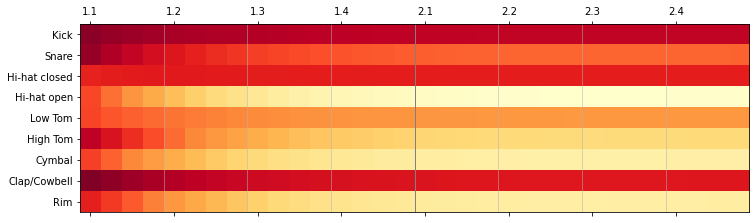

epoch: 1
m_d_loss: 0.17189659214019776     m_g_loss: 7.961168775753099


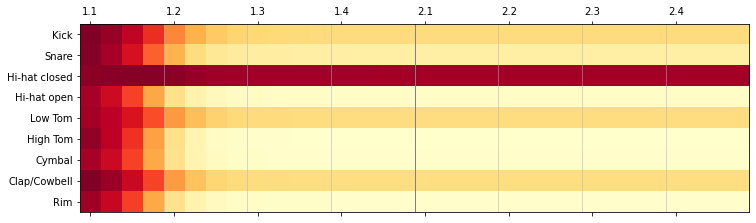

epoch: 2
m_d_loss: 0.17482193236549695     m_g_loss: 6.135369281379544


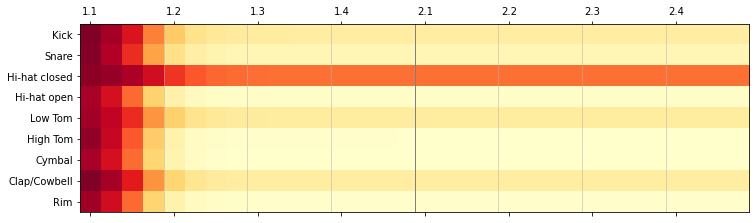

epoch: 3
m_d_loss: 0.199931348323822     m_g_loss: 5.639949302284085


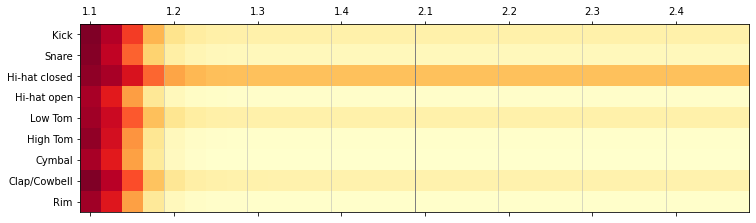

epoch: 4
m_d_loss: 0.17467915837963421     m_g_loss: 5.600145563787343


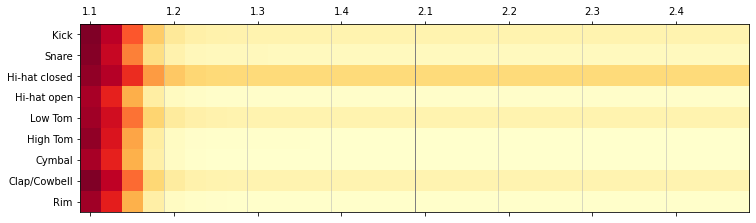

epoch: 5
m_d_loss: 0.167492018699646     m_g_loss: 7.155654975346157


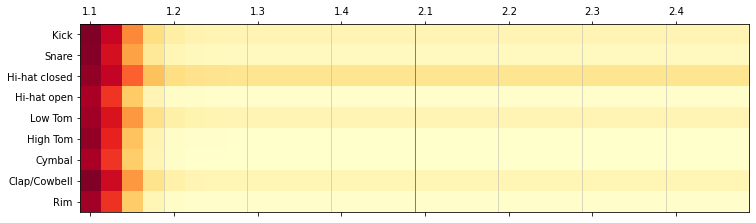

epoch: 6
m_d_loss: 0.17805322644611202     m_g_loss: 6.311708528168348


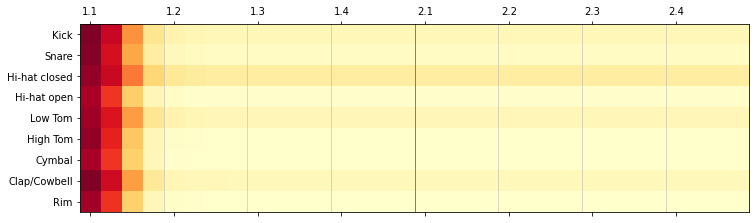

epoch: 7
m_d_loss: 0.3132932149938174     m_g_loss: 4.980570582710967


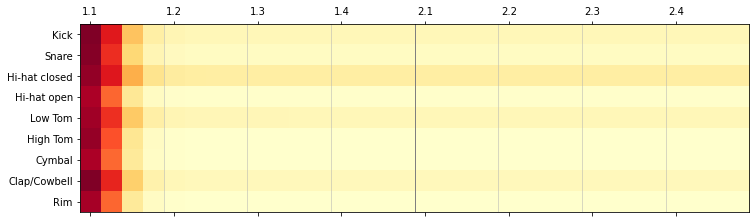

epoch: 8
m_d_loss: 0.19418752789497376     m_g_loss: 3.9848091164413764


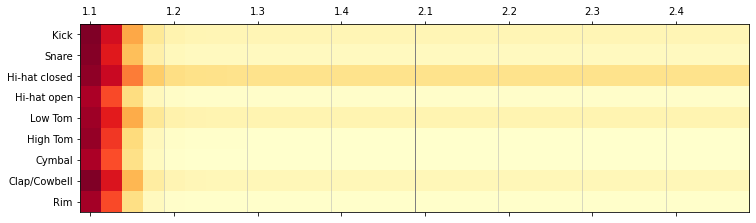

epoch: 9
m_d_loss: 0.18257992751896382     m_g_loss: 5.240272541435397


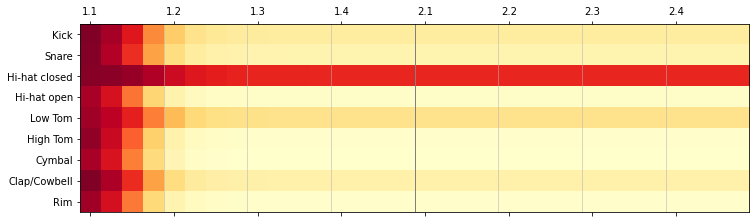

epoch: 10
m_d_loss: 0.17399835085868837     m_g_loss: 5.708221425815505


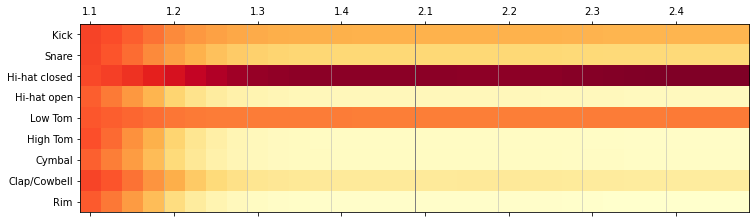

epoch: 11
m_d_loss: 0.1663511692235867     m_g_loss: 7.288950988224575


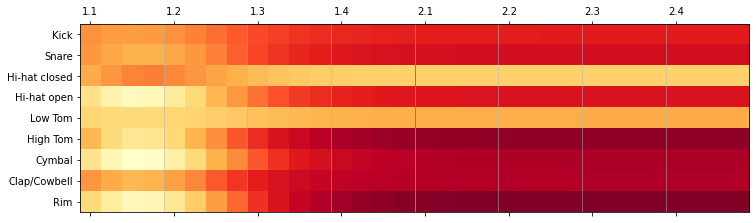

epoch: 12
m_d_loss: 0.16545126724243162     m_g_loss: 7.848968204186887


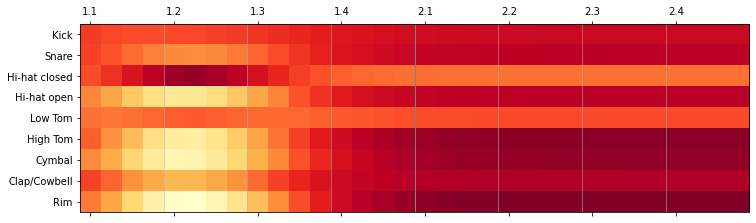

epoch: 13
m_d_loss: 0.16618173631529012     m_g_loss: 8.193406358057139


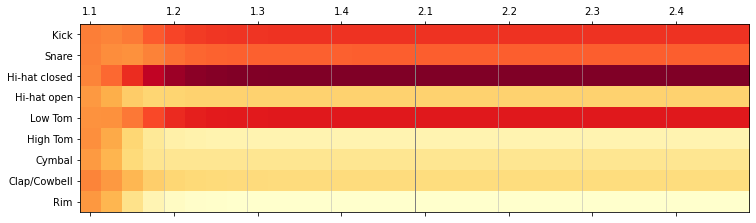

epoch: 14
m_d_loss: 0.16511036896705625     m_g_loss: 8.563471550844154


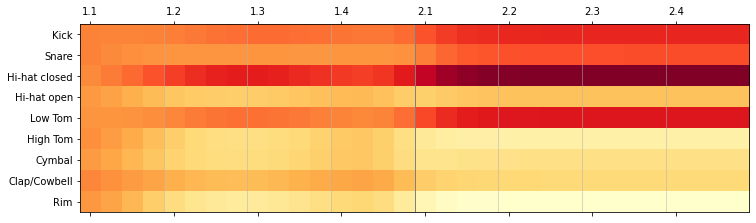

epoch: 15
m_d_loss: 0.16839247147242228     m_g_loss: 7.902123139829052


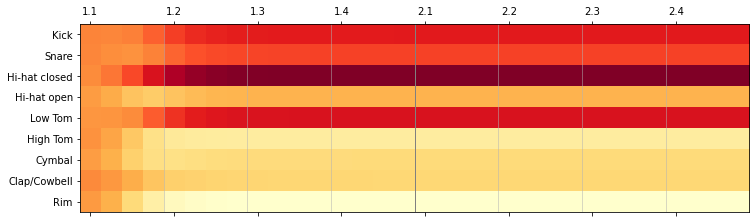

epoch: 16
m_d_loss: 0.16507770931720736     m_g_loss: 8.107945237840925


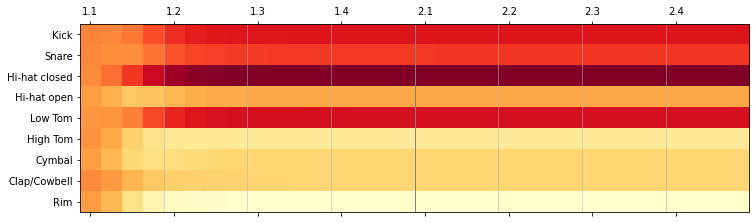

epoch: 17
m_d_loss: 0.16504769710203013     m_g_loss: 8.467104074906329


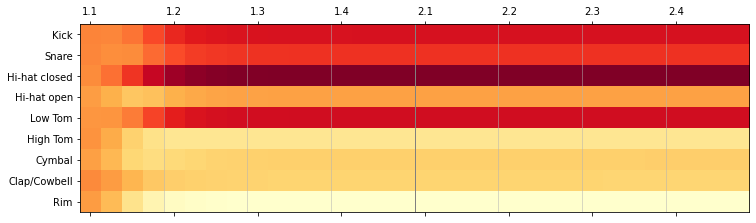

epoch: 18
m_d_loss: 0.16567916488647463     m_g_loss: 8.458825743928248


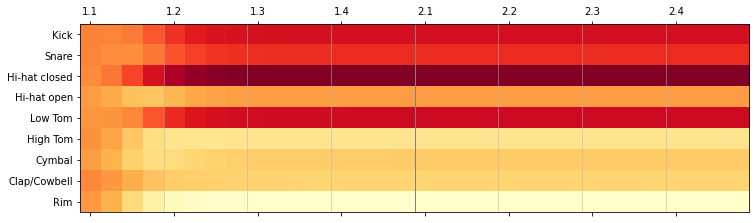

epoch: 19
m_d_loss: 0.16588405594229697     m_g_loss: 8.150079454694476


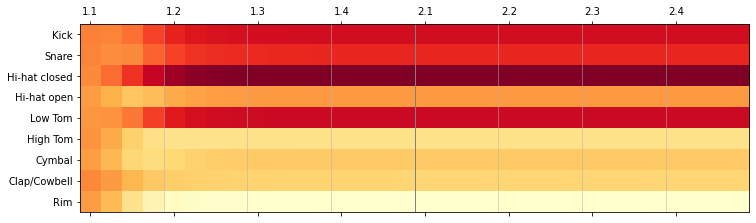

epoch: 20
m_d_loss: 0.16540324413776403     m_g_loss: 8.05280419758388


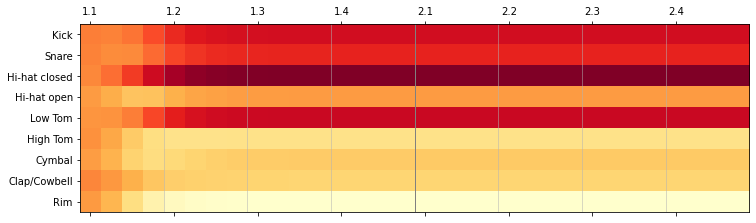

epoch: 21
m_d_loss: 0.1640926929811637     m_g_loss: 8.349749214795171


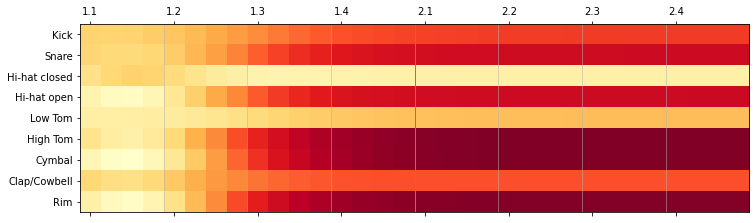

epoch: 22
m_d_loss: 0.16535045123100278     m_g_loss: 8.65992108169867


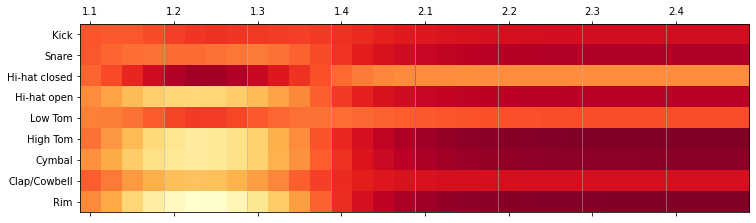

epoch: 23
m_d_loss: 0.16510482182105382     m_g_loss: 7.9651800953612035


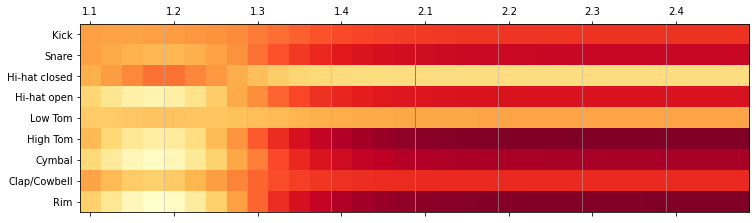

epoch: 24
m_d_loss: 0.16367198026180269     m_g_loss: 8.910672849538376


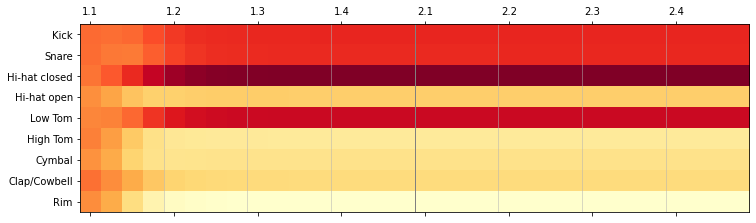

epoch: 25
m_d_loss: 0.1629348078121742     m_g_loss: 9.421589870842135


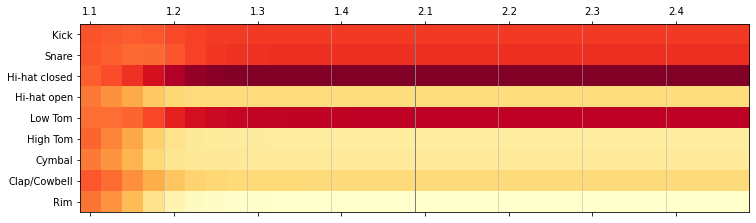

epoch: 26
m_d_loss: 0.1645367105007172     m_g_loss: 9.69619606952278


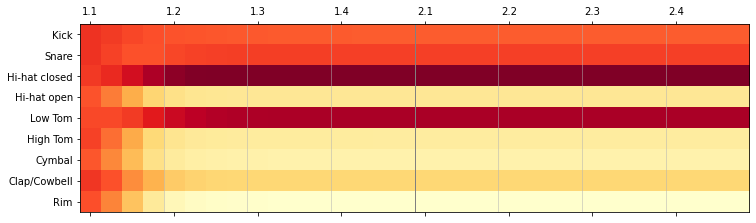

epoch: 27
m_d_loss: 0.1646898535390695     m_g_loss: 8.270900512228208


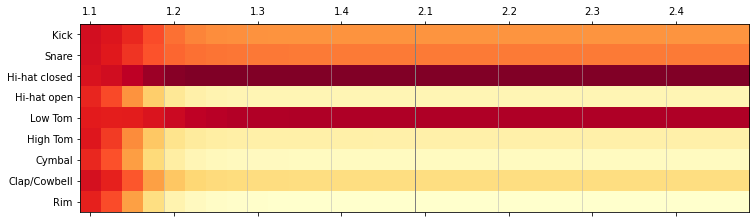

epoch: 28
m_d_loss: 0.16470986115932465     m_g_loss: 7.990218415552256


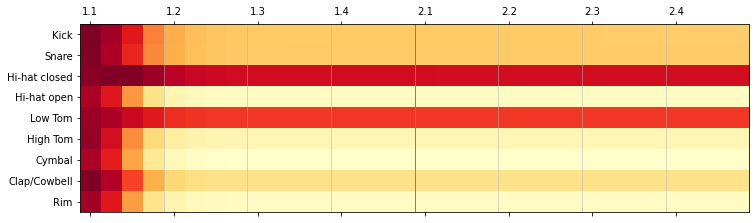

epoch: 29
m_d_loss: 0.1677345668276151     m_g_loss: 7.372319056063282


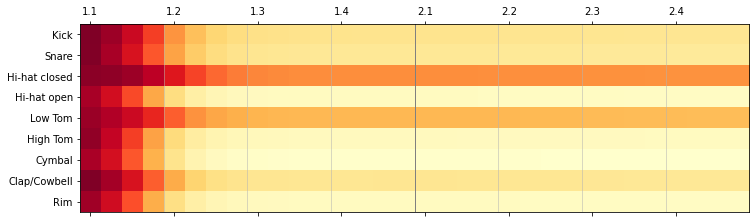

epoch: 30
m_d_loss: 0.164752116560936     m_g_loss: 7.550643658151432


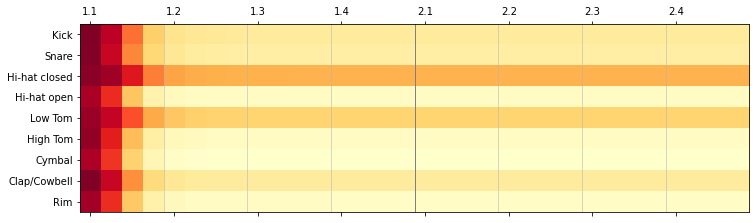

epoch: 31
m_d_loss: 0.16378082806865377     m_g_loss: 9.059747754311076


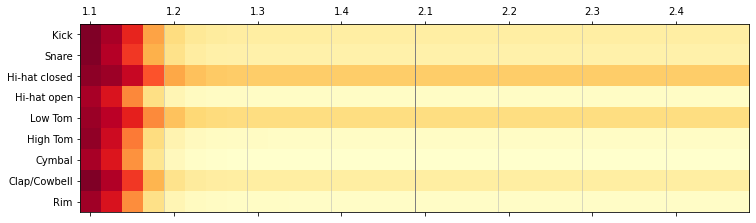

epoch: 32
m_d_loss: 0.16378952765464783     m_g_loss: 8.92697877300029


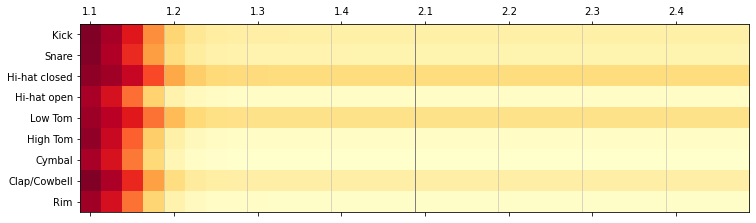

epoch: 33
m_d_loss: 0.16673813648521899     m_g_loss: 7.586625741452587


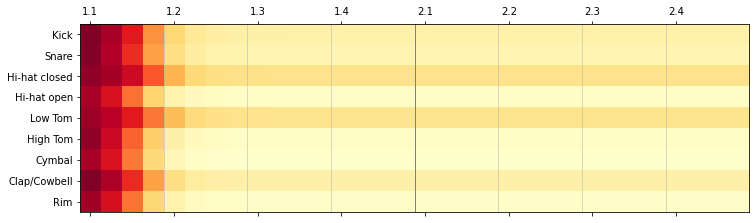

epoch: 34
m_d_loss: 0.1675257045030594     m_g_loss: 7.632701494255844


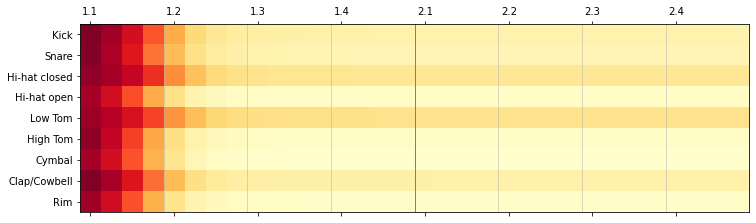

epoch: 35
m_d_loss: 0.1676346234977245     m_g_loss: 7.044311134182677


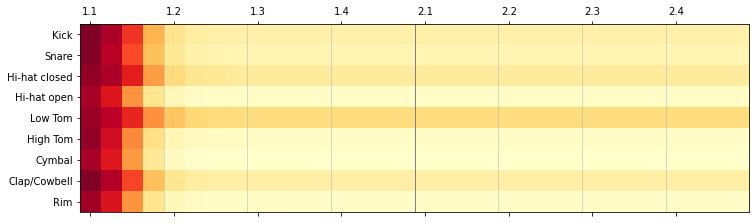

epoch: 36
m_d_loss: 0.16593059492111206     m_g_loss: 7.109475836461904


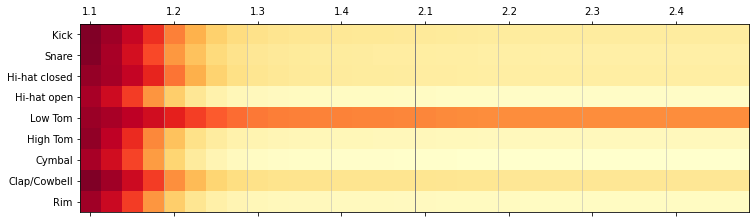

epoch: 37
m_d_loss: 0.16397731515268485     m_g_loss: 8.526840453245201


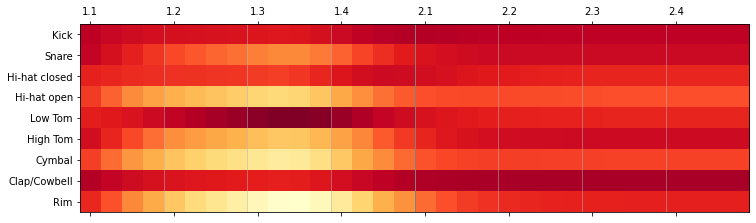

epoch: 38
m_d_loss: 0.16398277926445012     m_g_loss: 9.55526404478112


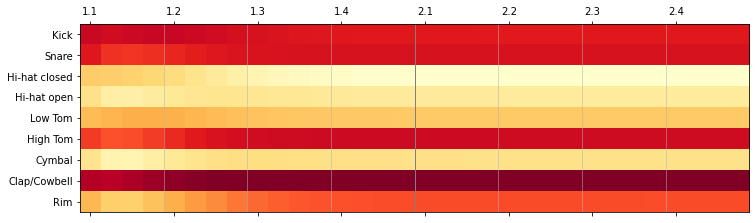

epoch: 39
m_d_loss: 0.16553204506635663     m_g_loss: 9.014015917875328


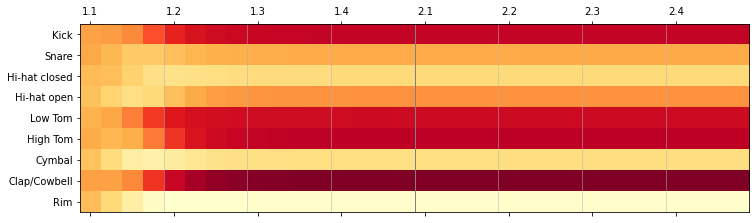

epoch: 40
m_d_loss: 0.16364721214771272     m_g_loss: 9.393282423214037


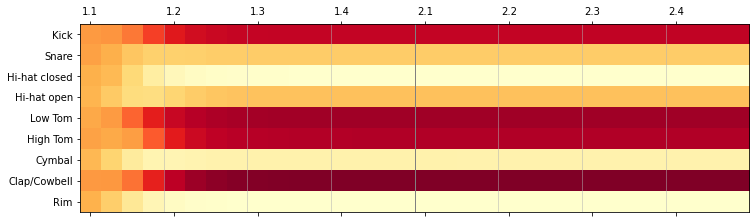

epoch: 41
m_d_loss: 0.16502360527714094     m_g_loss: 9.242262606718102


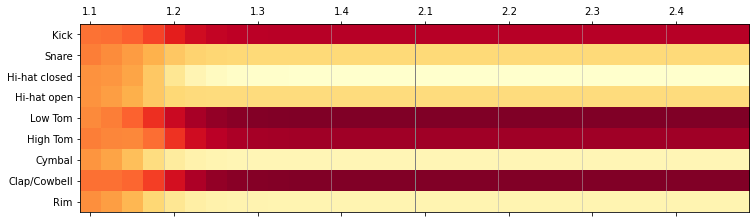

epoch: 42
m_d_loss: 0.16397112667560576     m_g_loss: 8.828374843208158


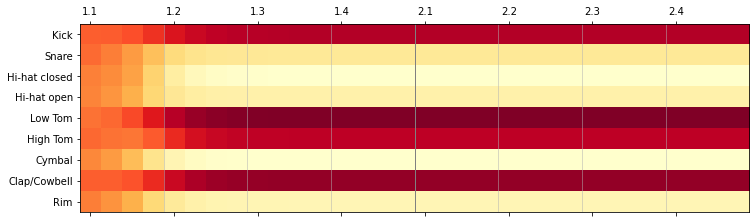

epoch: 43
m_d_loss: 0.16501591354608536     m_g_loss: 8.95255303869442


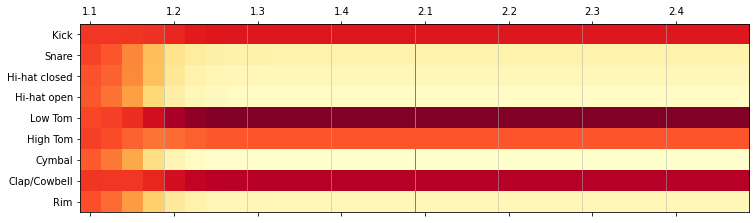

epoch: 44
m_d_loss: 0.1642369078397751     m_g_loss: 8.707492254218277


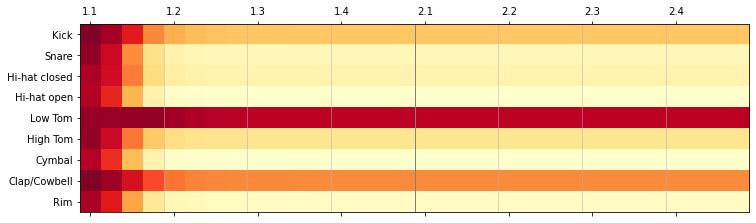

epoch: 45
m_d_loss: 0.16438649917642276     m_g_loss: 8.36236081804548


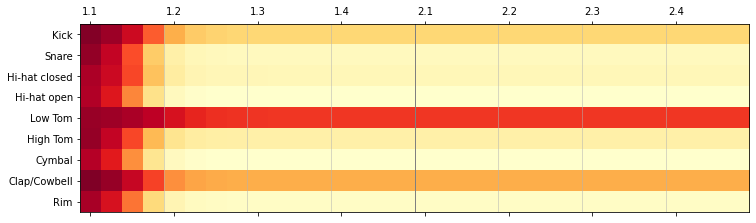

epoch: 46
m_d_loss: 0.16457682752609248     m_g_loss: 8.73673187956518


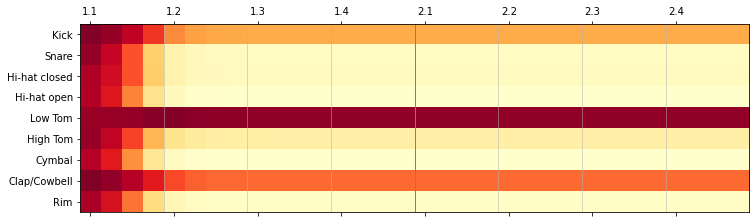

epoch: 47
m_d_loss: 0.16326301917433741     m_g_loss: 10.618865597004794


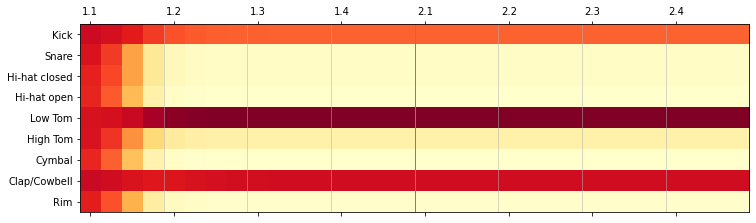

epoch: 48
m_d_loss: 0.16389045476913452     m_g_loss: 10.929745187564771


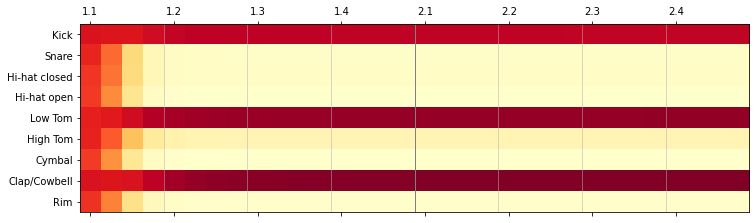

epoch: 49
m_d_loss: 0.16517761386930943     m_g_loss: 10.693798104111028


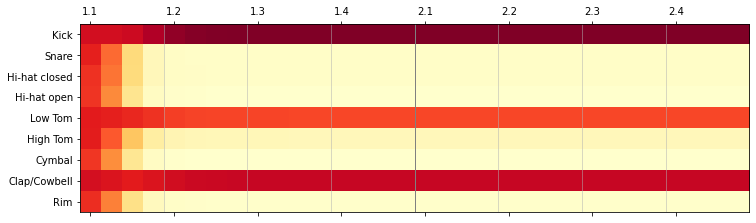

epoch: 50
m_d_loss: 0.1637518446445465     m_g_loss: 10.241860720576073


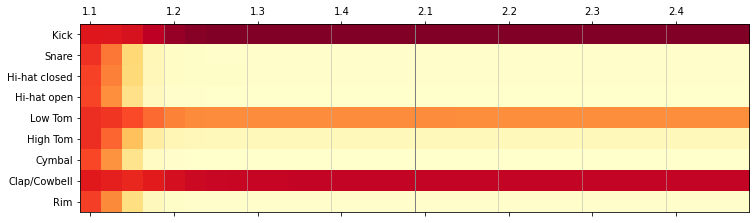

epoch: 51
m_d_loss: 0.16314967796206478     m_g_loss: 10.925393357568858


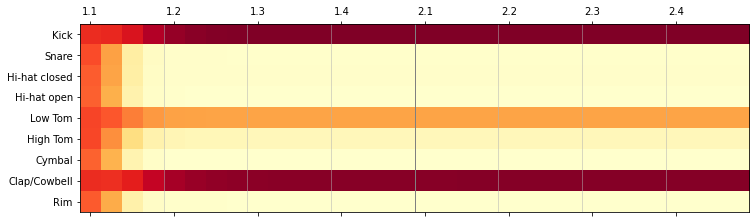

epoch: 52
m_d_loss: 0.1633218595981598     m_g_loss: 11.790537016732353


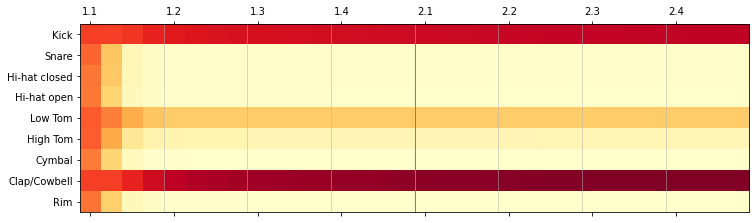

epoch: 53
m_d_loss: 0.16298418628672756     m_g_loss: 12.012486827616788


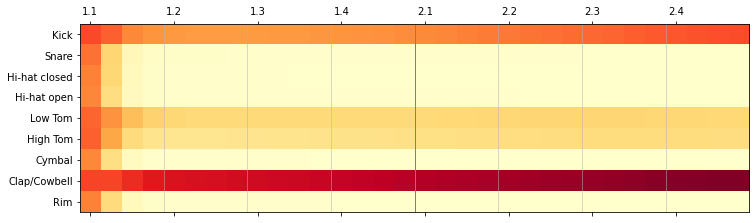

epoch: 54
m_d_loss: 0.1715855566263199     m_g_loss: 13.566657922705826


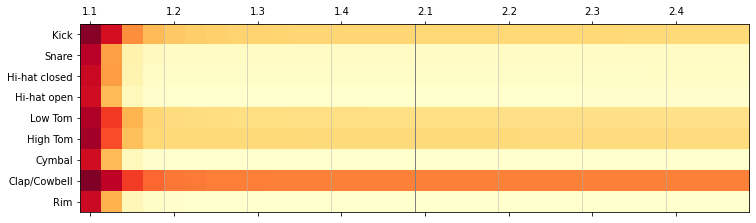

epoch: 55
m_d_loss: 0.1686568714678288     m_g_loss: 7.276665794606111


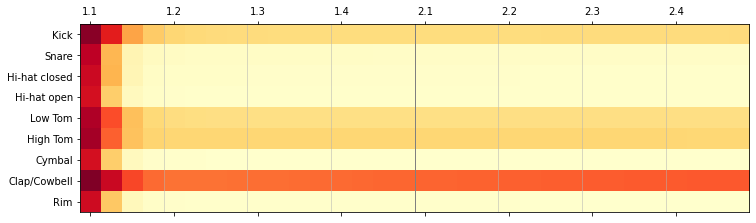

epoch: 56
m_d_loss: 0.1628256516456604     m_g_loss: 9.086364843407456


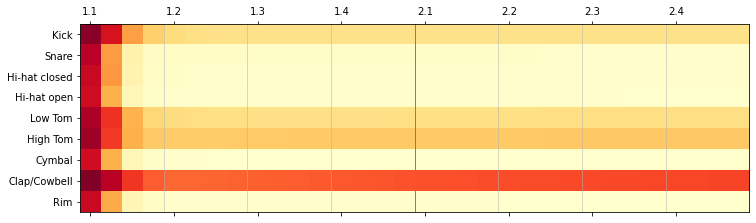

epoch: 57
m_d_loss: 0.1630663752555847     m_g_loss: 10.1367589989487


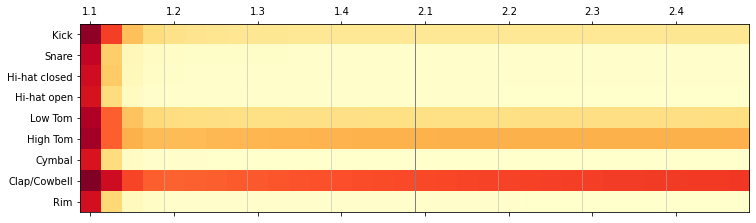

epoch: 58
m_d_loss: 0.1636359543800354     m_g_loss: 9.503224450714734


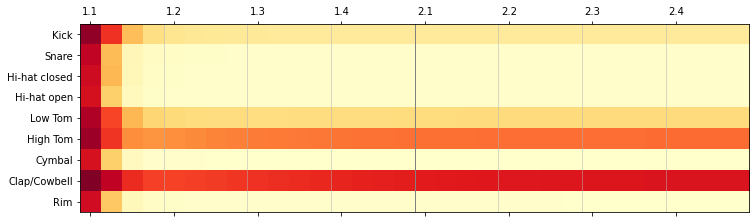

epoch: 59
m_d_loss: 0.16287153003116453     m_g_loss: 10.131064142499651


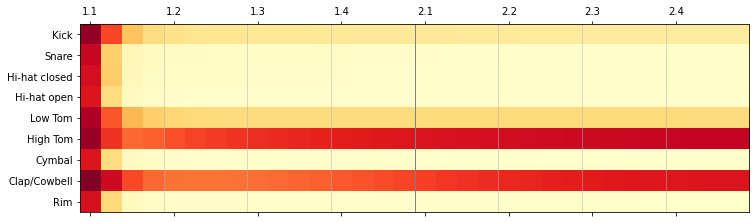

epoch: 60
m_d_loss: 0.16292526590824127     m_g_loss: 10.571070242901238


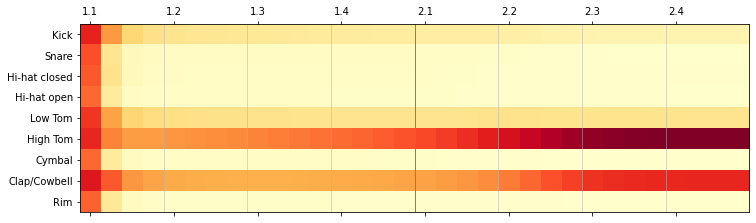

epoch: 61
m_d_loss: 0.16357327948013942     m_g_loss: 12.58357927750568


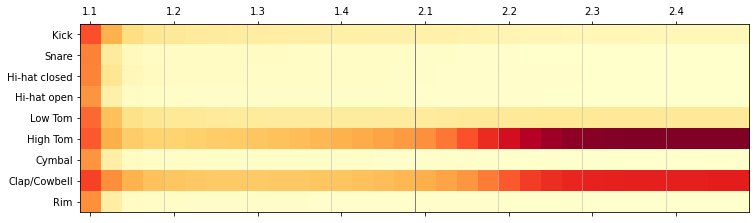

epoch: 62
m_d_loss: 0.2017601325511932     m_g_loss: 10.042479320448273


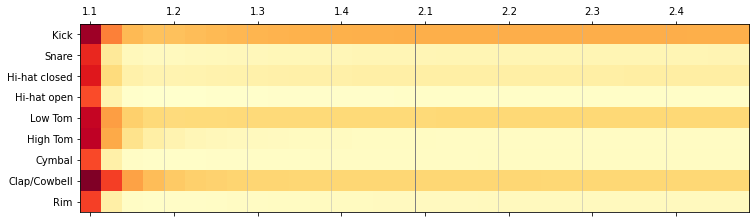

epoch: 63
m_d_loss: 0.5273198904262648     m_g_loss: 2.650905338477115


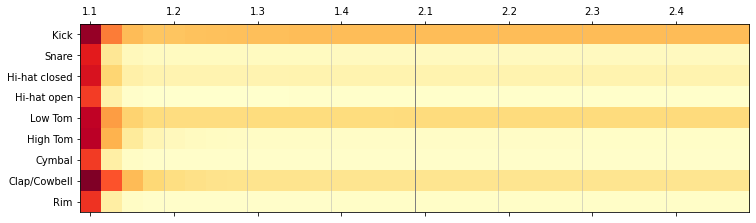

epoch: 64
m_d_loss: 0.5042682956904172     m_g_loss: 2.004939446643907


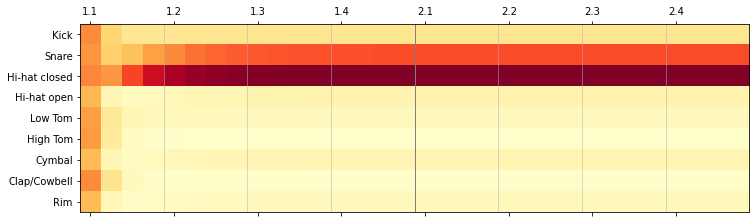

epoch: 65
m_d_loss: 0.2720014890034993     m_g_loss: 3.091959233186683


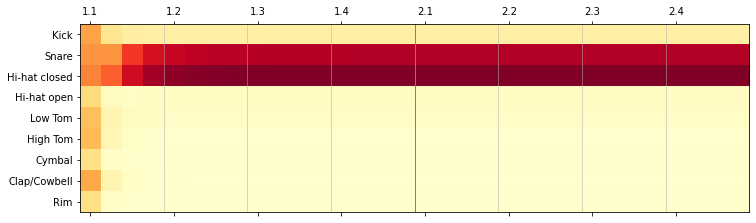

epoch: 66
m_d_loss: 0.22753108453750615     m_g_loss: 3.734252321476839


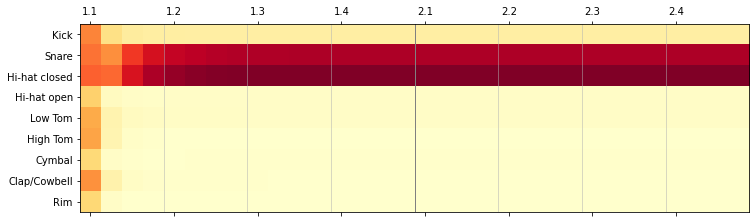

epoch: 67
m_d_loss: 0.23352149526278185     m_g_loss: 3.752844036841879


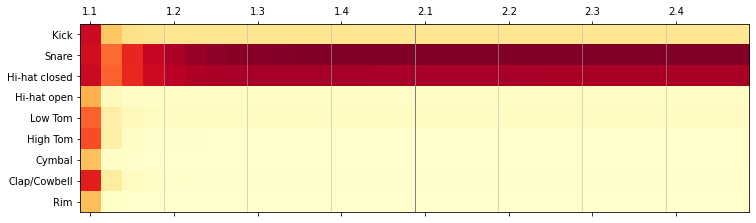

epoch: 68
m_d_loss: 0.3141067707538604     m_g_loss: 2.9105353890633094


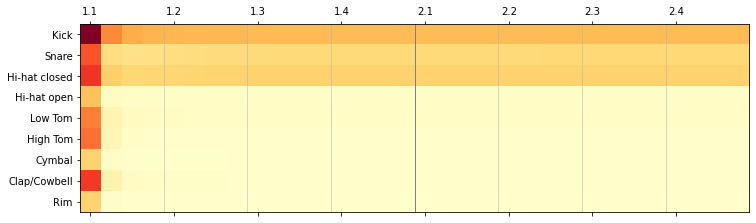

epoch: 69
m_d_loss: 0.29208666669825717     m_g_loss: 2.8898782681445687


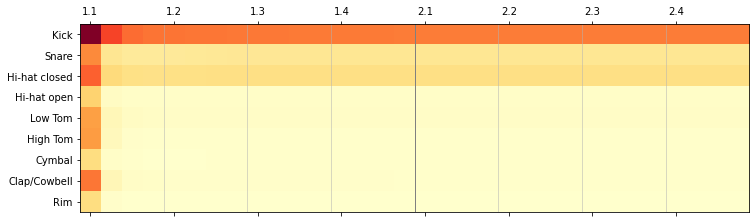

epoch: 70
m_d_loss: 0.276942751288414     m_g_loss: 2.9891573677257615


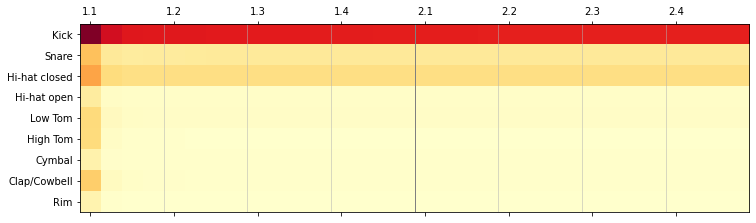

epoch: 71
m_d_loss: 0.2662772486607234     m_g_loss: 3.10200234335296


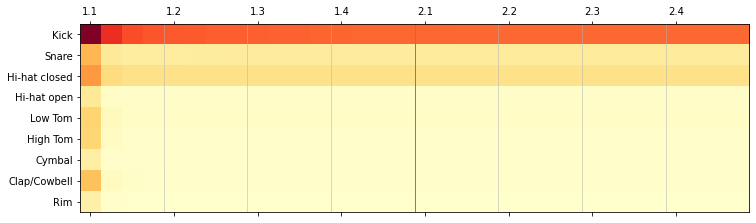

epoch: 72
m_d_loss: 0.2320999575853348     m_g_loss: 3.502076397136766


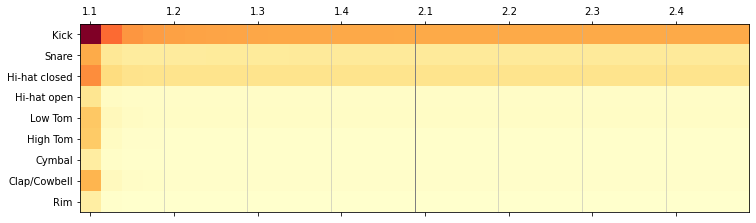

epoch: 73
m_d_loss: 0.21454665325582026     m_g_loss: 3.913775872211067


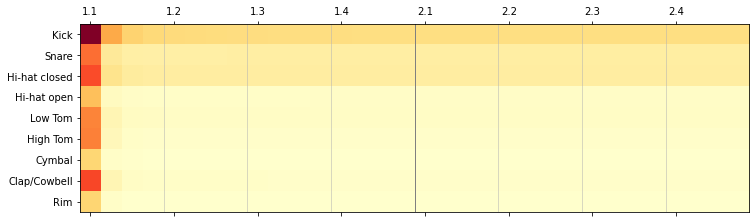

epoch: 74
m_d_loss: 0.22702970278263088     m_g_loss: 4.252450208274686


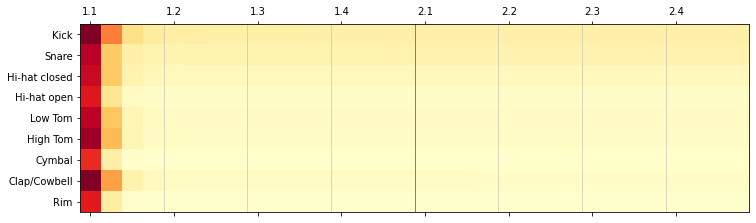

epoch: 75
m_d_loss: 0.21619730629026893     m_g_loss: 4.735570990309423


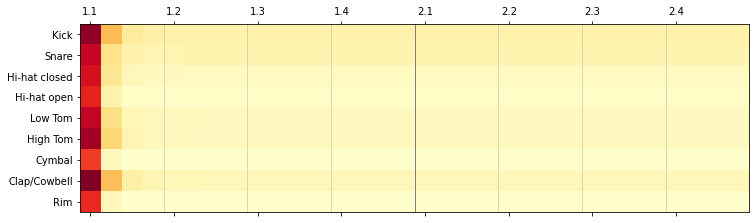

epoch: 76
m_d_loss: 0.19105982375144961     m_g_loss: 6.0507912441175815


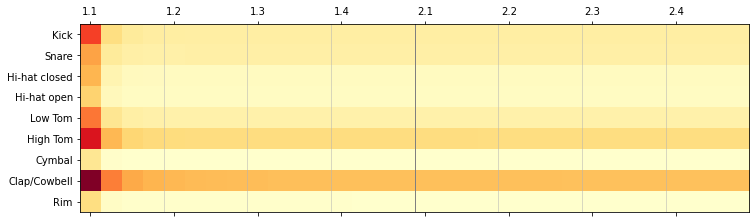

epoch: 77
m_d_loss: 0.22835776930054028     m_g_loss: 6.817533522236104


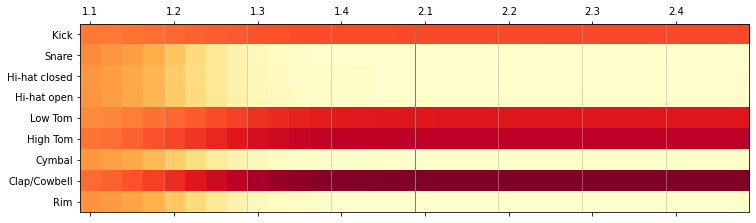

epoch: 78
m_d_loss: 0.20349086344242096     m_g_loss: 6.520435712775406


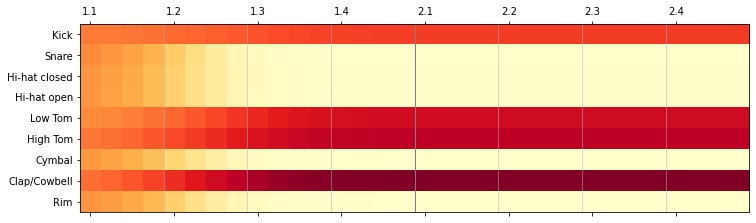

epoch: 79
m_d_loss: 0.21325459405779837     m_g_loss: 5.469998661352664


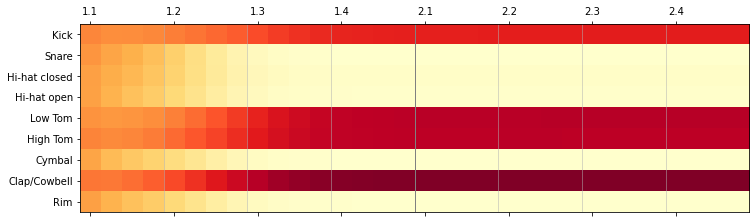

epoch: 80
m_d_loss: 0.19206855738163     m_g_loss: 6.7701956398633065


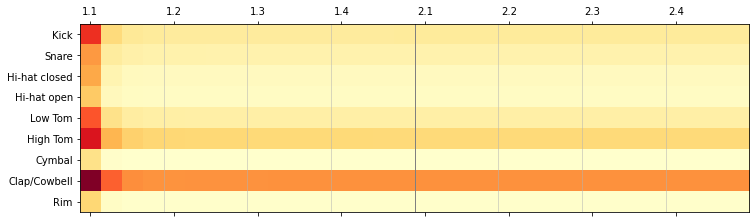

epoch: 81
m_d_loss: 0.18221258309980234     m_g_loss: 7.185277403617392


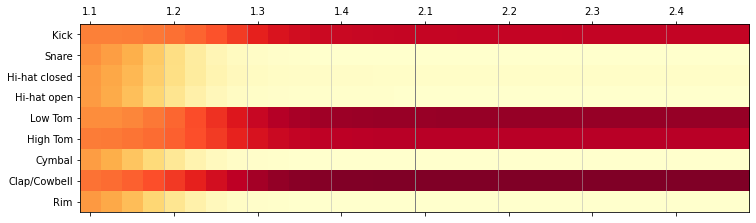

epoch: 82
m_d_loss: 0.18322608745098112     m_g_loss: 6.732930222336127


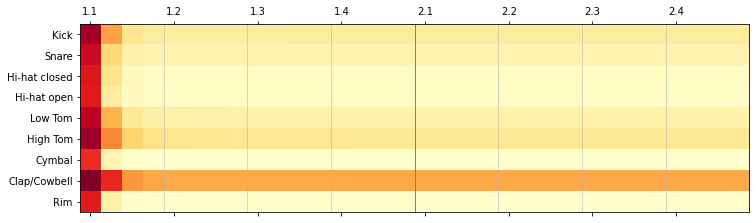

epoch: 83
m_d_loss: 0.1761664919555187     m_g_loss: 8.11073855964505


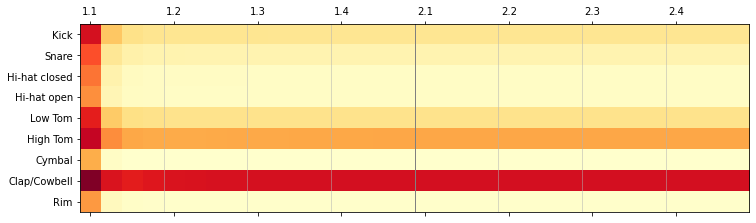

epoch: 84
m_d_loss: 0.16989627850055694     m_g_loss: 9.831149996543417


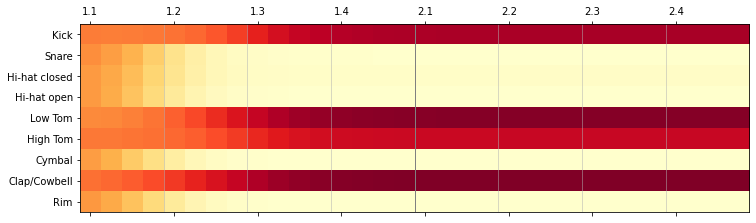

epoch: 85
m_d_loss: 0.17735427295168246     m_g_loss: 7.581039175695302


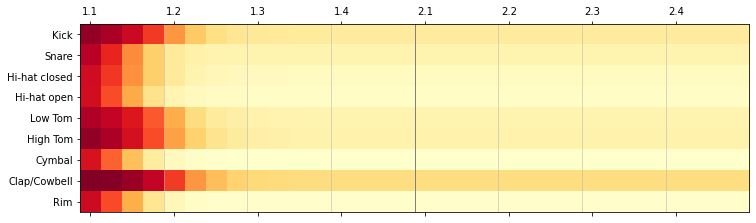

epoch: 86
m_d_loss: 0.20622456371784206     m_g_loss: 5.527286184077361


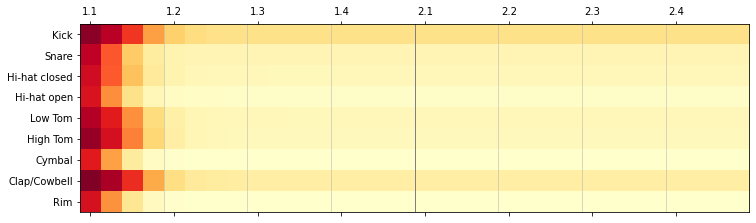

epoch: 87
m_d_loss: 0.3190220344811678     m_g_loss: 4.082738832551605


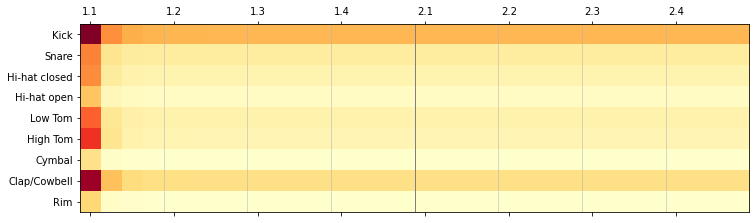

epoch: 88
m_d_loss: 0.2083714975118637     m_g_loss: 4.547274054313193


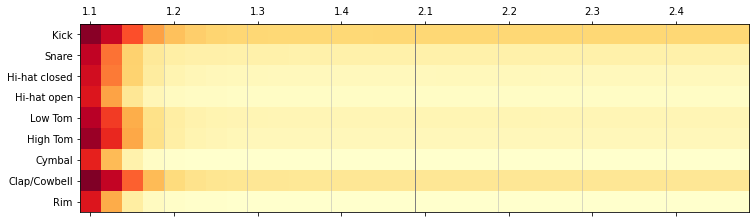

epoch: 89
m_d_loss: 0.19444911132256193     m_g_loss: 4.97507617911514


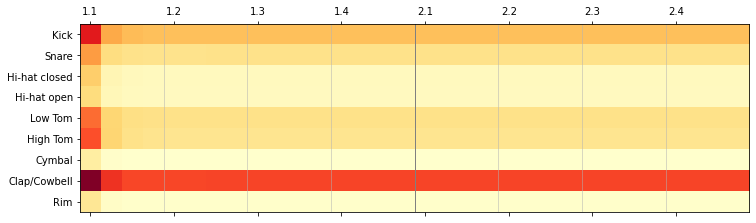

epoch: 90
m_d_loss: 0.1896159765720367     m_g_loss: 4.984993545376525


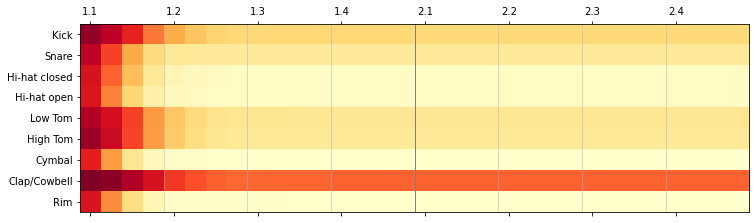

epoch: 91
m_d_loss: 0.19803412022689978     m_g_loss: 4.869768059983546


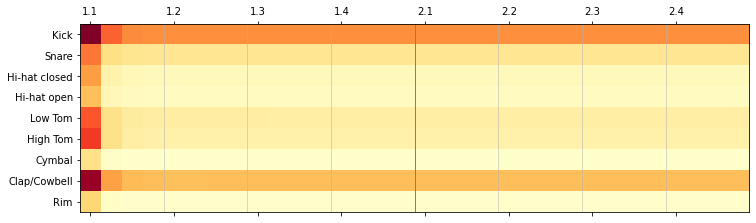

epoch: 92
m_d_loss: 0.20552653396129605     m_g_loss: 4.6710269791739325


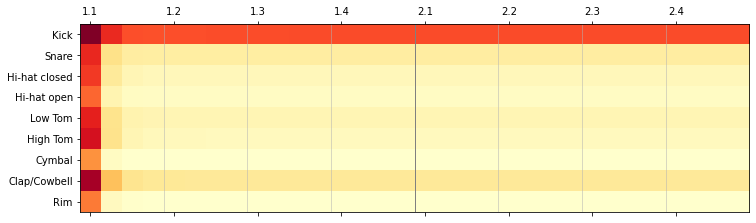

epoch: 93
m_d_loss: 0.18264679064353306     m_g_loss: 4.921177426163031


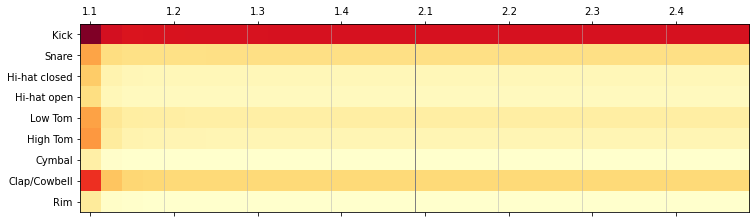

epoch: 94
m_d_loss: 0.19143412196636206     m_g_loss: 5.158691289473553


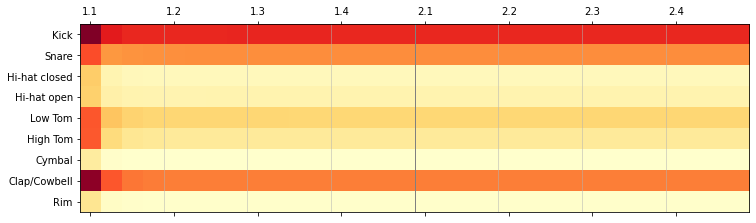

epoch: 95
m_d_loss: 0.20177984883387887     m_g_loss: 4.330433563310272


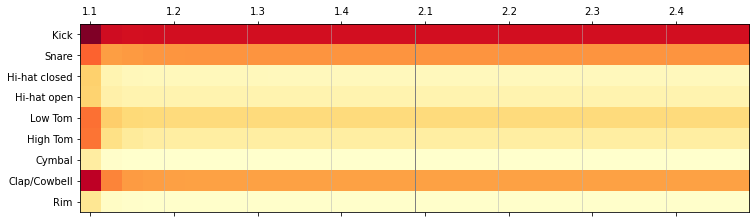

epoch: 96
m_d_loss: 0.21422177386283875     m_g_loss: 5.011919279487765


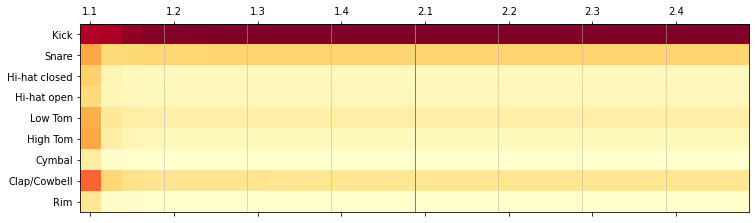

epoch: 97
m_d_loss: 0.18948343321681024     m_g_loss: 4.577914821858308


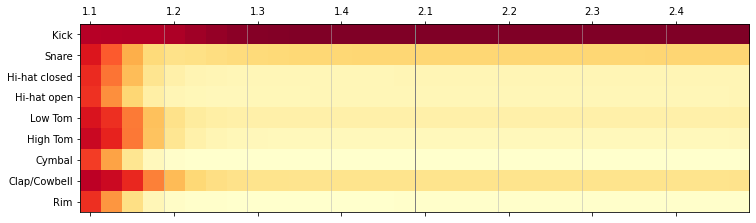

epoch: 98
m_d_loss: 0.2026199293136597     m_g_loss: 5.10659595411651


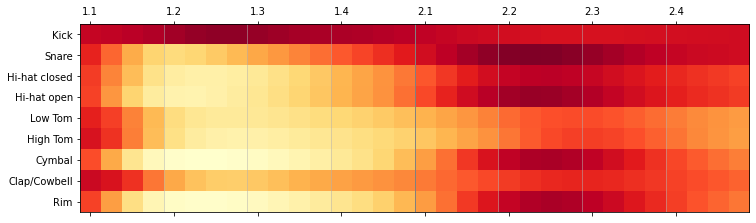

epoch: 99
m_d_loss: 0.20499059458573654     m_g_loss: 4.970309267238695


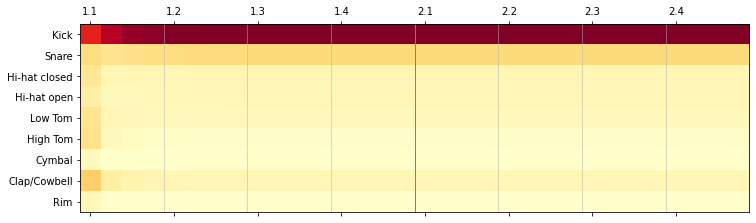

epoch: 100
m_d_loss: 0.20154761624336243     m_g_loss: 4.992115565708706


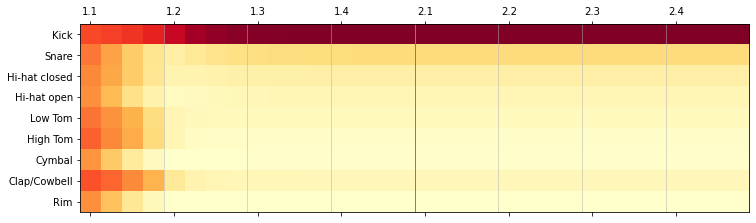

epoch: 101
m_d_loss: 0.29417720675468445     m_g_loss: 3.380394957503494


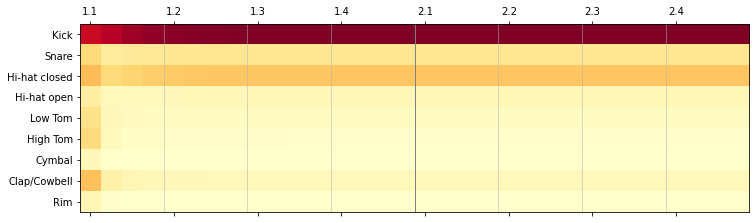

epoch: 102
m_d_loss: 0.27949747306605177     m_g_loss: 3.316257968240855


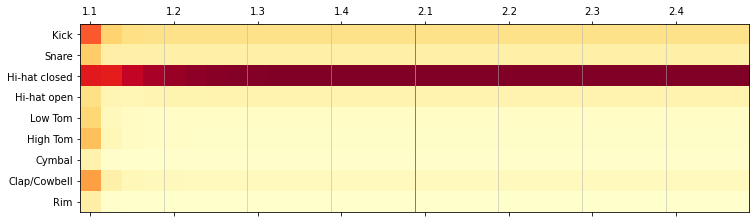

epoch: 103
m_d_loss: 0.26844245803356176     m_g_loss: 3.596514468290368


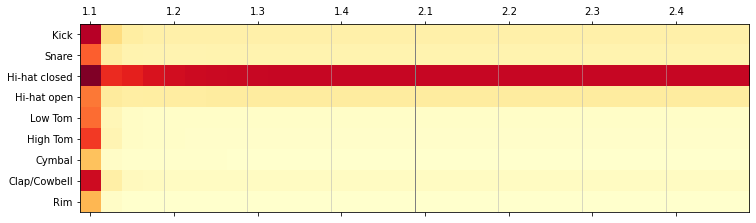

epoch: 104
m_d_loss: 0.24961535781621938     m_g_loss: 3.4735939454059213


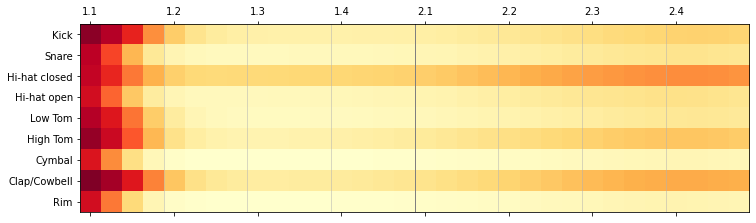

epoch: 105
m_d_loss: 0.24877333819866185     m_g_loss: 3.4374322404666824


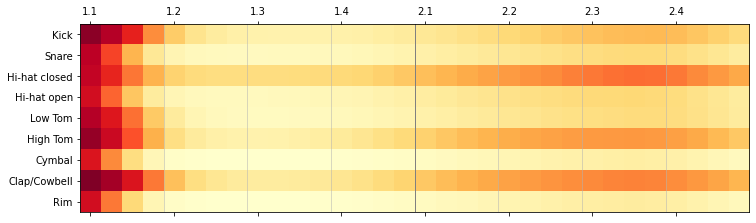

epoch: 106
m_d_loss: 0.24238794371485708     m_g_loss: 3.5620904795977535


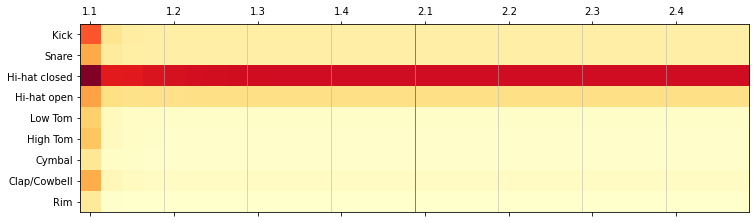

epoch: 107
m_d_loss: 0.2499871777296066     m_g_loss: 3.3904089003193136


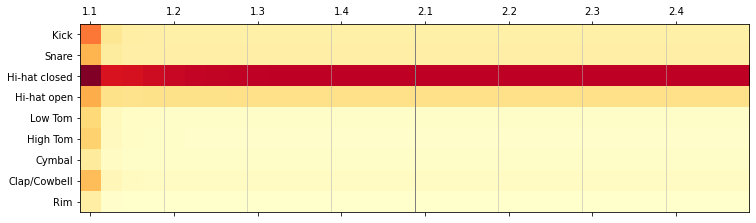

epoch: 108
m_d_loss: 0.23413474957148236     m_g_loss: 3.6245646671373017


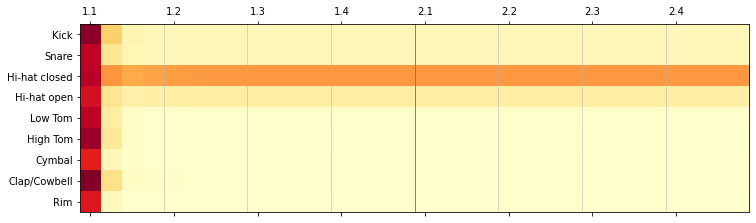

epoch: 109
m_d_loss: 0.22500483596324927     m_g_loss: 4.054122238743062


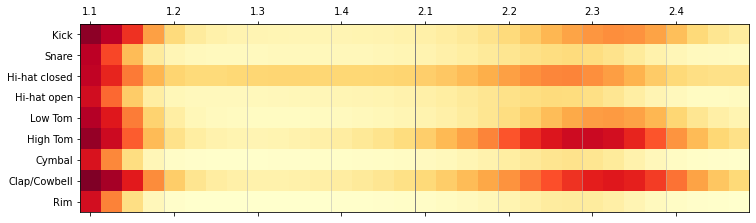

epoch: 110
m_d_loss: 0.21782282541195552     m_g_loss: 4.477013602548716


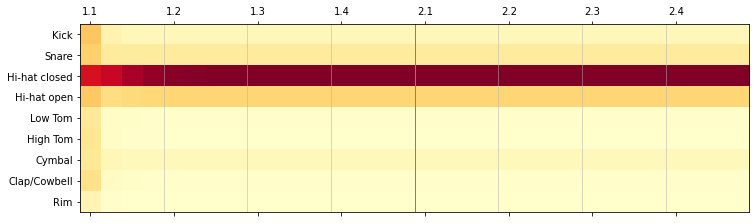

epoch: 111
m_d_loss: 0.2235932958126068     m_g_loss: 4.986469589934057


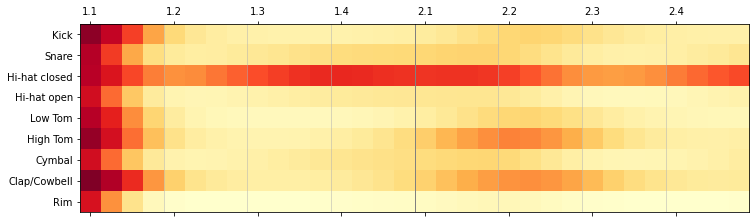

epoch: 112
m_d_loss: 0.21396670378744606     m_g_loss: 5.16976091813068


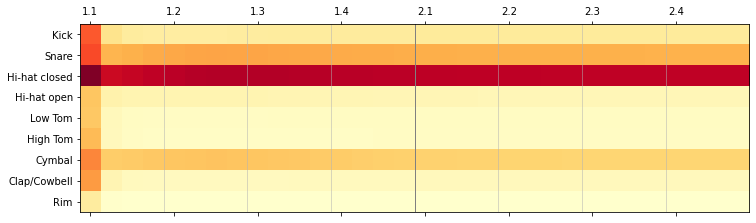

epoch: 113
m_d_loss: 0.21684118413925177     m_g_loss: 4.971104398065684


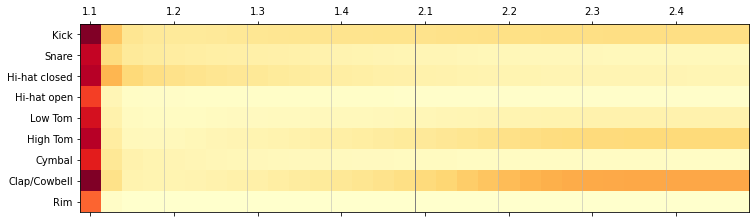

epoch: 114
m_d_loss: 0.21651014300684135     m_g_loss: 5.941807688498984


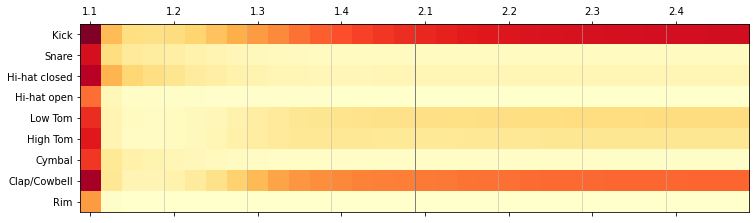

epoch: 115
m_d_loss: 0.22124012601375576     m_g_loss: 6.091071527831408


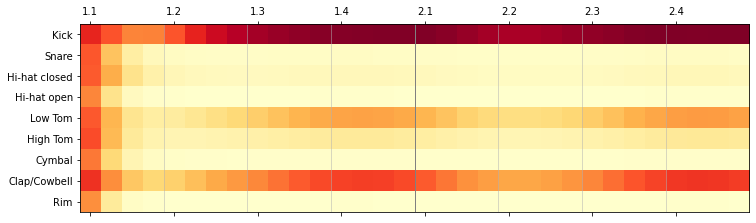

epoch: 116
m_d_loss: 0.21707612151900926     m_g_loss: 5.376353560661783


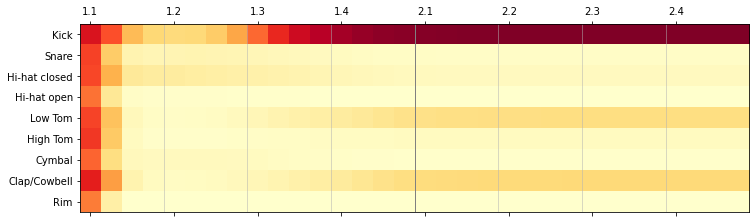

epoch: 117
m_d_loss: 0.2347695391178131     m_g_loss: 5.149989186501016


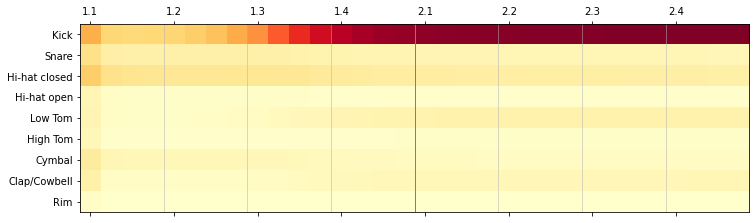

epoch: 118
m_d_loss: 0.21986858000357948     m_g_loss: 4.775896734120894


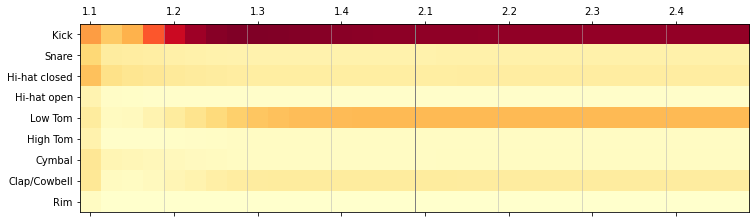

epoch: 119
m_d_loss: 0.22689096653461457     m_g_loss: 4.415908380430572


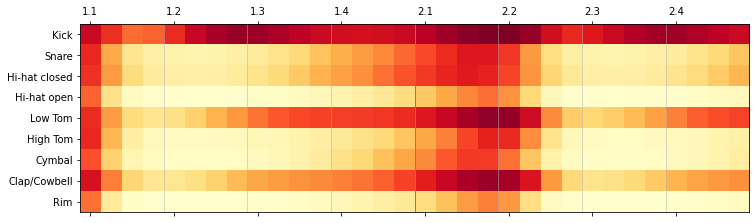

epoch: 120
m_d_loss: 0.2357078363498052     m_g_loss: 3.9646906755408464


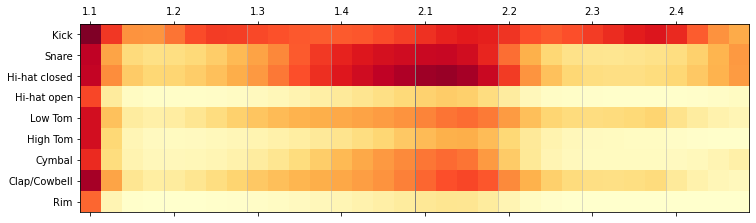

epoch: 121
m_d_loss: 0.22818773102760315     m_g_loss: 4.032679893532578


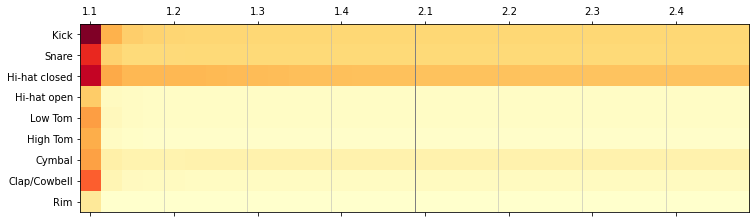

epoch: 122
m_d_loss: 0.21177359422047937     m_g_loss: 5.605064323970249


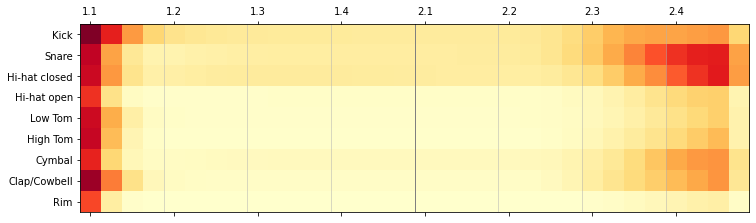

epoch: 123
m_d_loss: 0.22370305943489074     m_g_loss: 5.2919435306471225


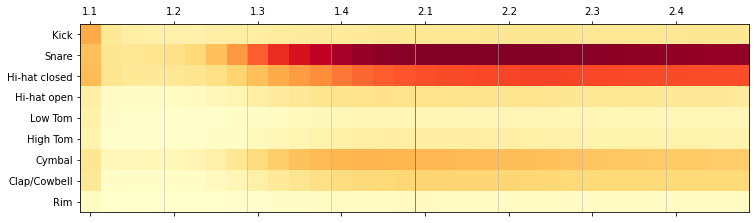

epoch: 124
m_d_loss: 0.24693062715232372     m_g_loss: 5.086467767248348


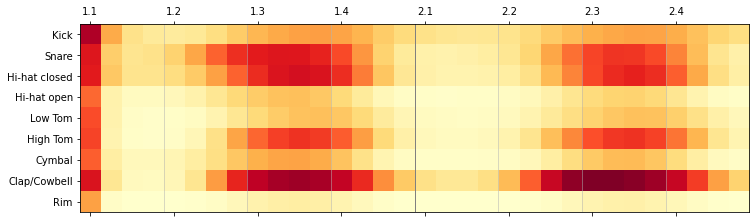

epoch: 125
m_d_loss: 0.3412419700622559     m_g_loss: 4.040897880281721


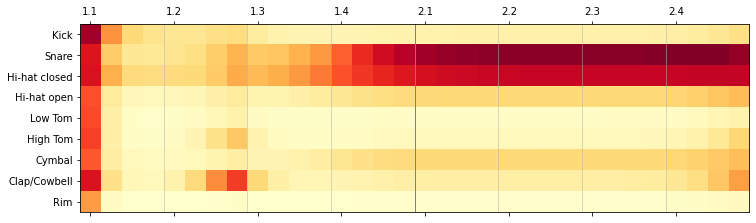

epoch: 126
m_d_loss: 0.3156099154303472     m_g_loss: 3.627253366976368


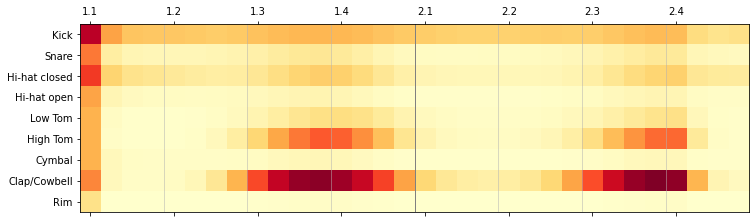

epoch: 127
m_d_loss: 0.3636523891687393     m_g_loss: 3.3342444458786322


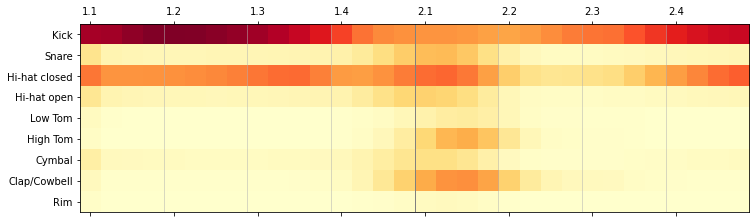

epoch: 128
m_d_loss: 0.3117386221885681     m_g_loss: 3.3006869773475493


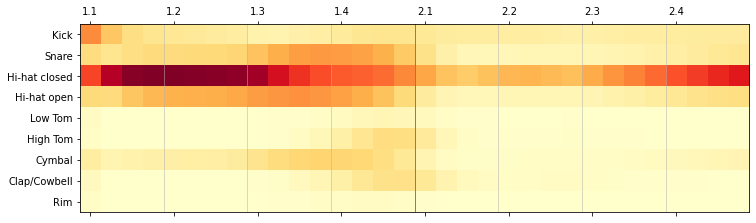

epoch: 129
m_d_loss: 0.24675535547733315     m_g_loss: 4.081437548812555


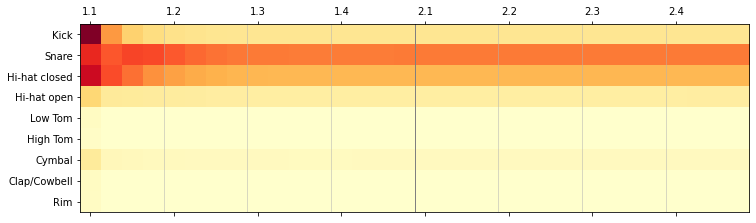

epoch: 130
m_d_loss: 0.2365770303954681     m_g_loss: 4.36426152015219


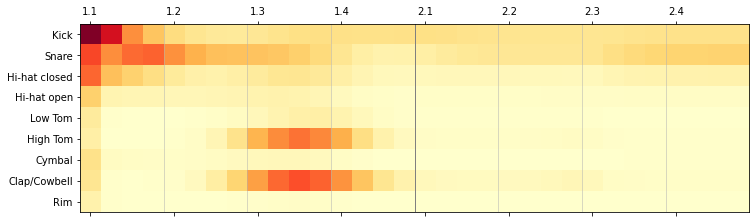

epoch: 131
m_d_loss: 0.23661424350738525     m_g_loss: 4.1795132500784735


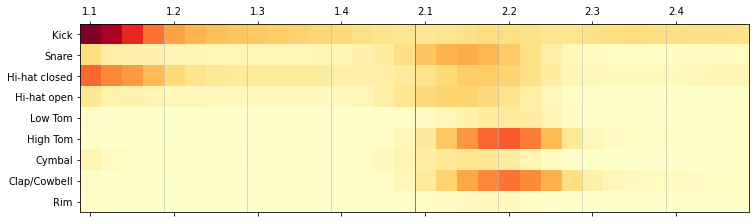

epoch: 132
m_d_loss: 0.2788012725611527     m_g_loss: 4.008292509585011


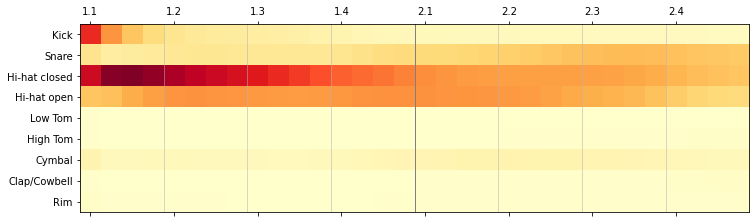

epoch: 133
m_d_loss: 0.23318110573291778     m_g_loss: 4.319064227902159


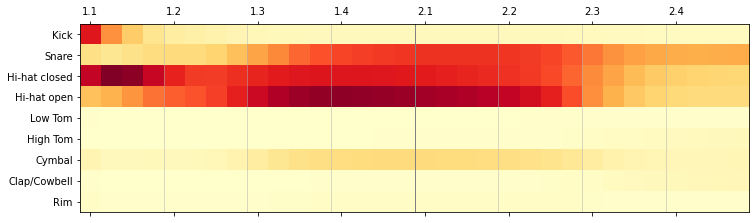

epoch: 134
m_d_loss: 0.23492000388602416     m_g_loss: 4.0438839999996885


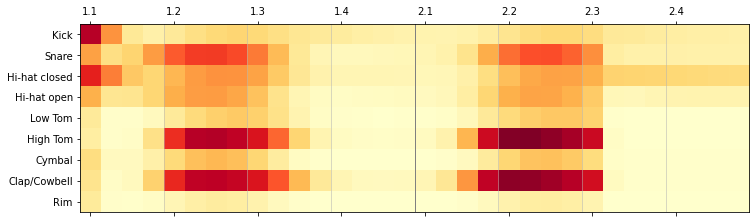

epoch: 135
m_d_loss: 0.290027311205864     m_g_loss: 3.3118328610245062


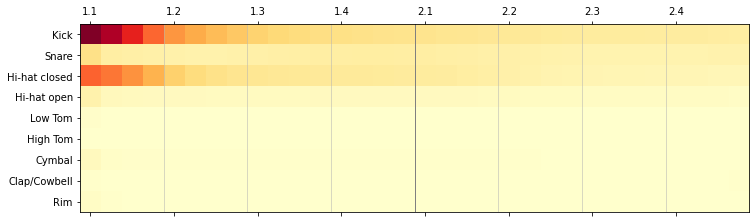

epoch: 136
m_d_loss: 0.23292685511211553     m_g_loss: 3.981906924928938


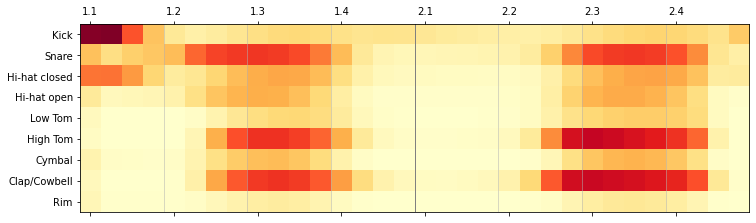

epoch: 137
m_d_loss: 0.2554694385528564     m_g_loss: 4.2881995269230435


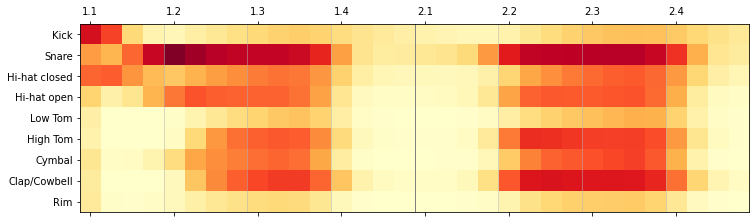

epoch: 138
m_d_loss: 0.2614044797917207     m_g_loss: 4.069159824021009


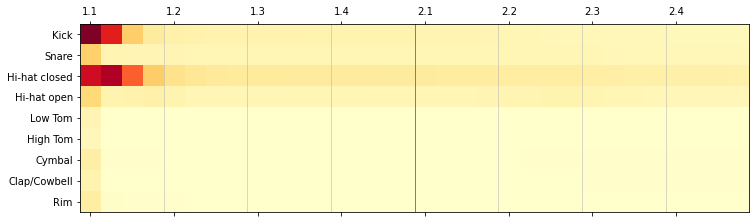

epoch: 139
m_d_loss: 0.26023513019084926     m_g_loss: 4.15492616380964


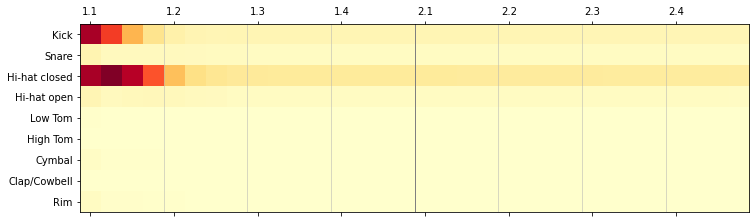

epoch: 140
m_d_loss: 0.22888564666112263     m_g_loss: 4.609887424780398


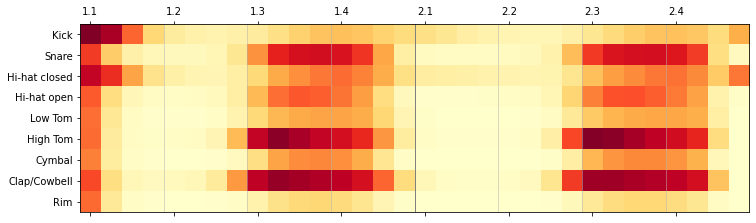

epoch: 141
m_d_loss: 0.22876051509380343     m_g_loss: 4.912106781589742


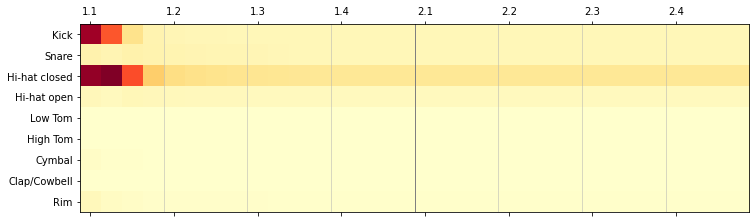

epoch: 142
m_d_loss: 0.22989038191735742     m_g_loss: 5.193185621378373


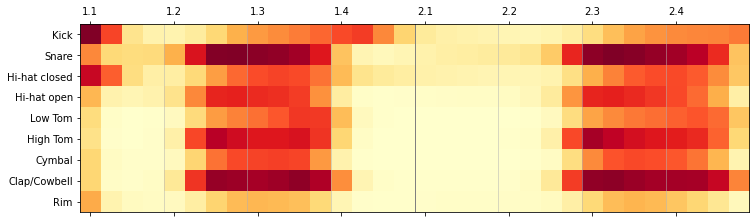

epoch: 143
m_d_loss: 0.22955005848407747     m_g_loss: 4.980470652482947


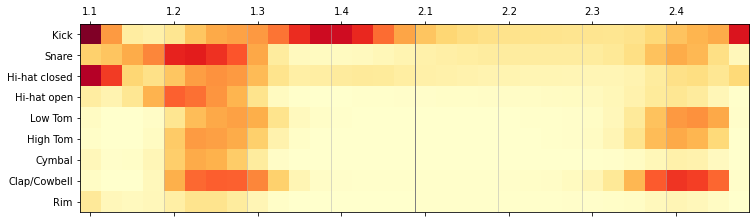

epoch: 144
m_d_loss: 0.21767020709812634     m_g_loss: 5.806488698842574


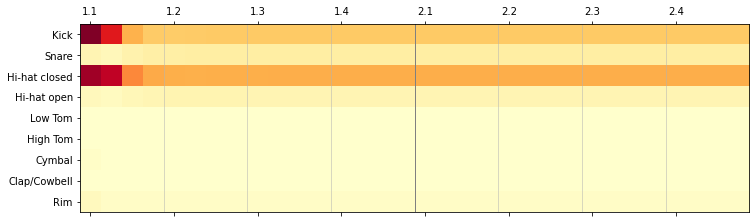

epoch: 145
m_d_loss: 0.18919786417484286     m_g_loss: 6.907950819755087


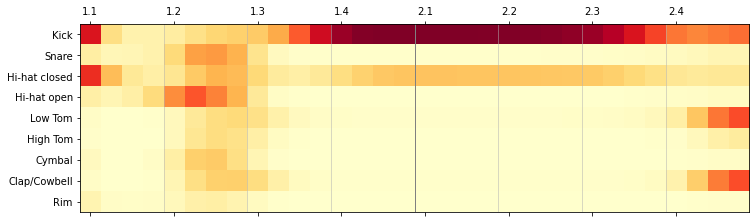

epoch: 146
m_d_loss: 0.21115196148554485     m_g_loss: 7.091861685928033


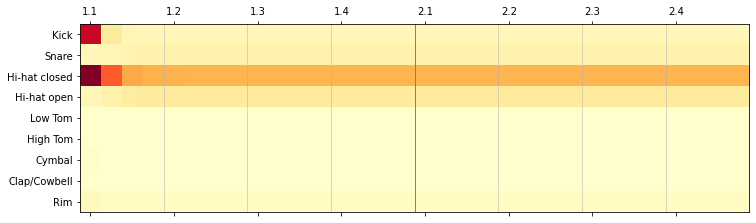

epoch: 147
m_d_loss: 0.2233333125114441     m_g_loss: 7.438916975138139


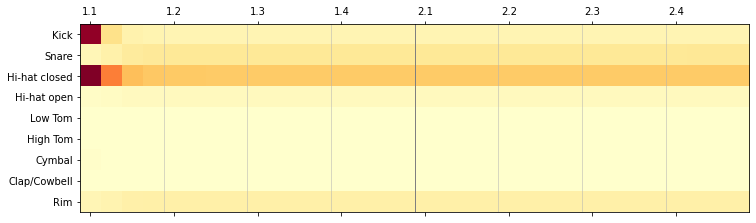

epoch: 148
m_d_loss: 0.2579848043620587     m_g_loss: 5.396354855323325


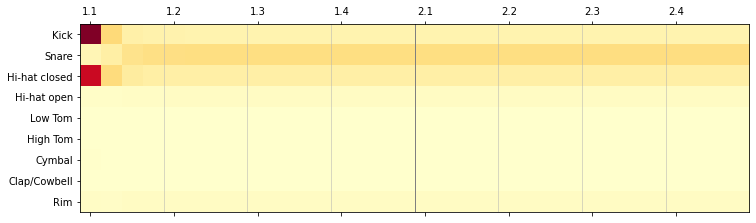

epoch: 149
m_d_loss: 0.2590652295351028     m_g_loss: 4.816477386318907


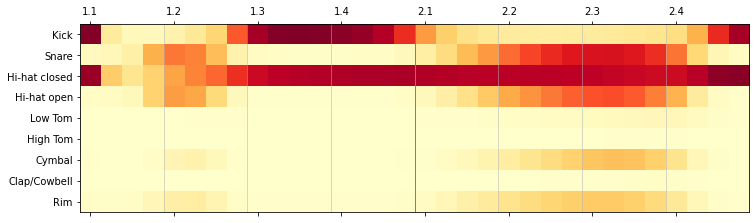

epoch: 150
m_d_loss: 0.23193314510087173     m_g_loss: 4.252567719440071


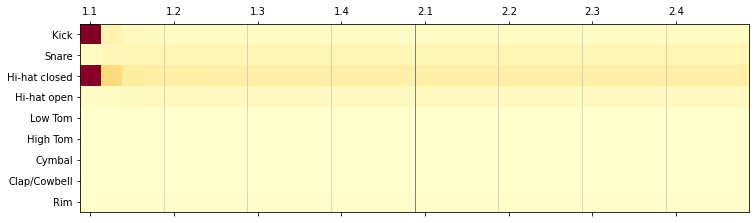

epoch: 151
m_d_loss: 0.23248815941810613     m_g_loss: 4.949795474811476


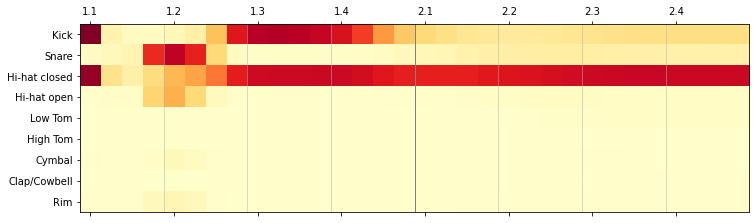

epoch: 152
m_d_loss: 0.2401106952379147     m_g_loss: 4.773159474742656


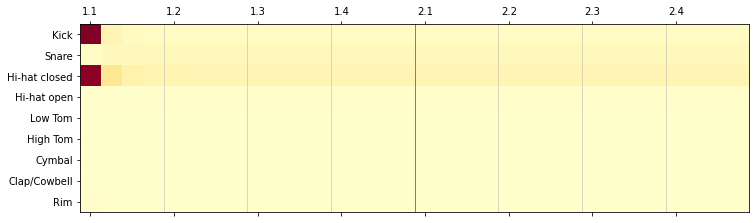

epoch: 153
m_d_loss: 0.247883328795433     m_g_loss: 4.28121390148085


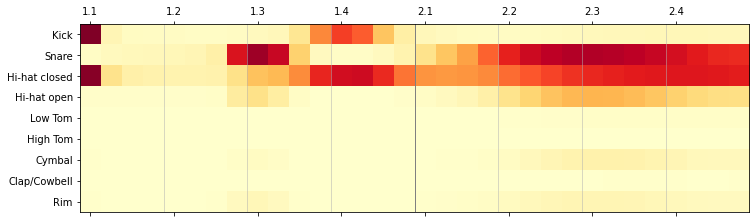

epoch: 154
m_d_loss: 0.20707962550222878     m_g_loss: 4.769652274190163


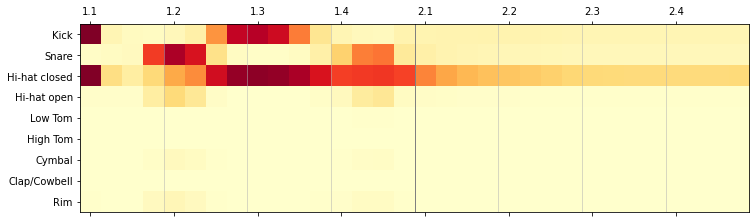

epoch: 155
m_d_loss: 0.18774495708942418     m_g_loss: 5.22740592275347


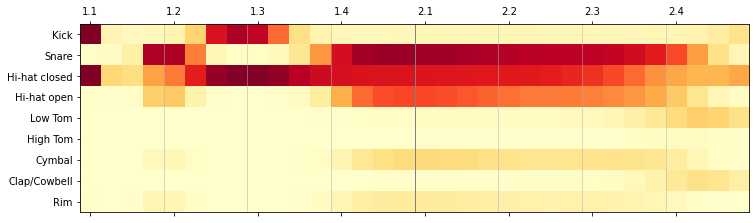

epoch: 156
m_d_loss: 0.18981242751081775     m_g_loss: 6.168910172520851


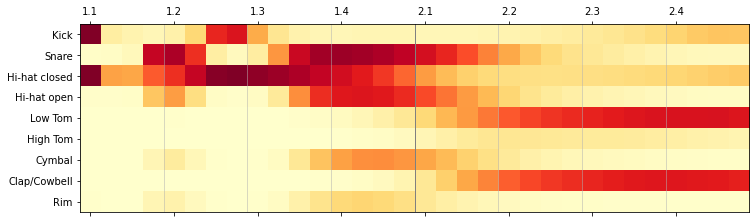

epoch: 157
m_d_loss: 0.20222821378707884     m_g_loss: 6.2162069106588556


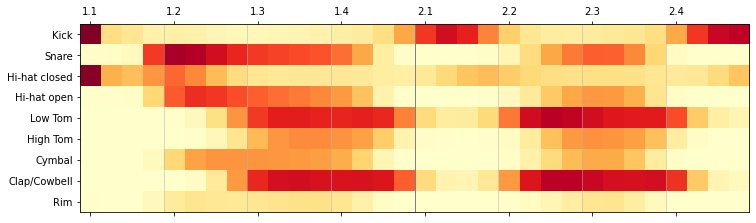

epoch: 158
m_d_loss: 0.22412756197154526     m_g_loss: 5.587945271511467


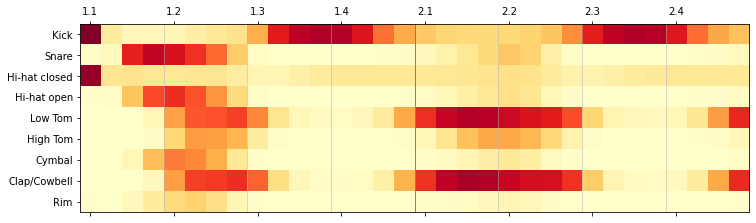

epoch: 159
m_d_loss: 0.19644320785999295     m_g_loss: 6.7468530693832705


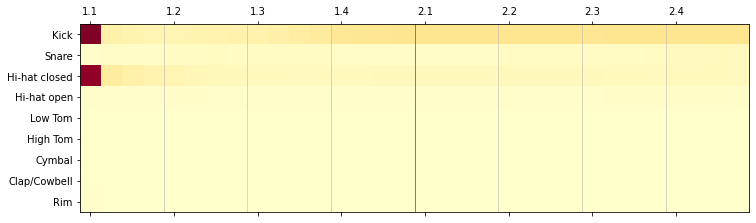

epoch: 160
m_d_loss: 0.19122162324686845     m_g_loss: 7.259816646575928


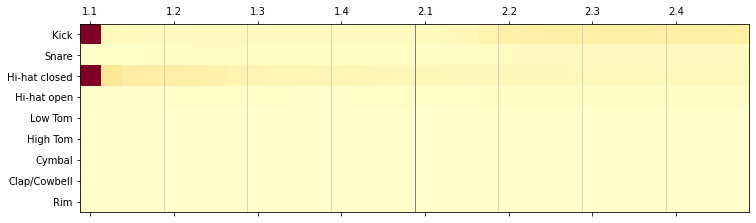

epoch: 161
m_d_loss: 0.18965821754932408     m_g_loss: 7.62650880035089


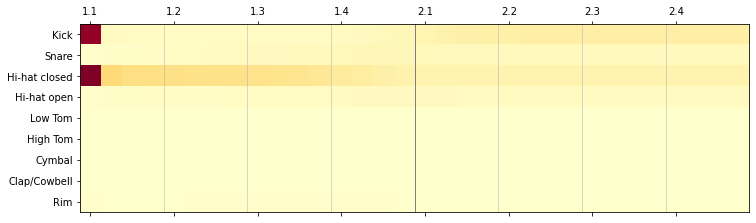

epoch: 162
m_d_loss: 0.4383151058107615     m_g_loss: 4.2798517626159045


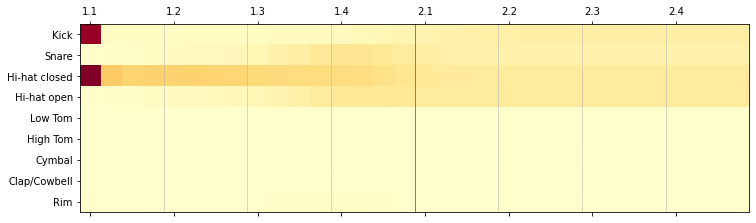

epoch: 163
m_d_loss: 0.3930636287927627     m_g_loss: 4.314109164841321


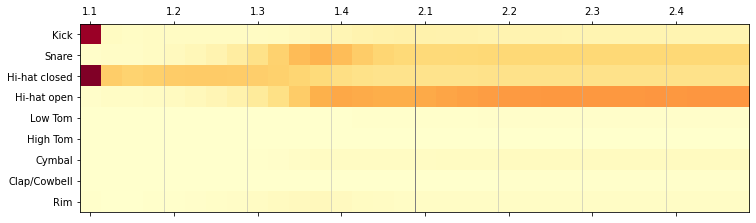

epoch: 164
m_d_loss: 0.26978525370359424     m_g_loss: 5.693797748916003


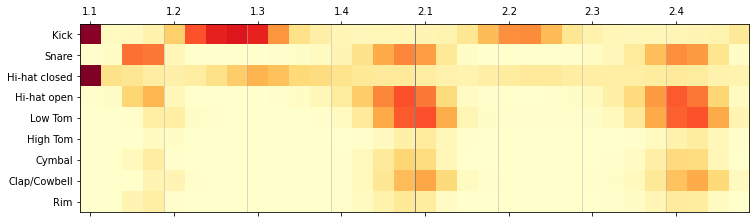

epoch: 165
m_d_loss: 0.20119213485717777     m_g_loss: 6.764987021076436


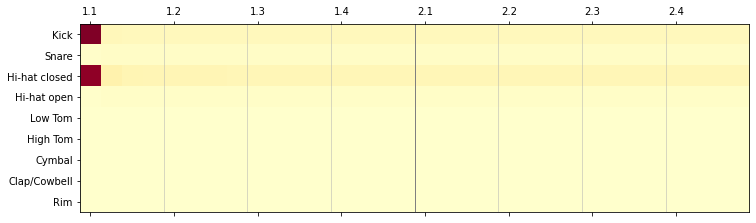

epoch: 166
m_d_loss: 0.23150204097231228     m_g_loss: 7.065447744058103


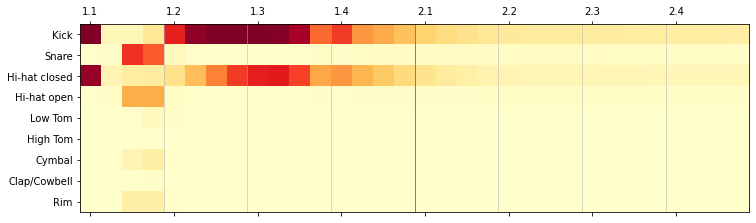

epoch: 167
m_d_loss: 0.26573844063282004     m_g_loss: 5.427668980189732


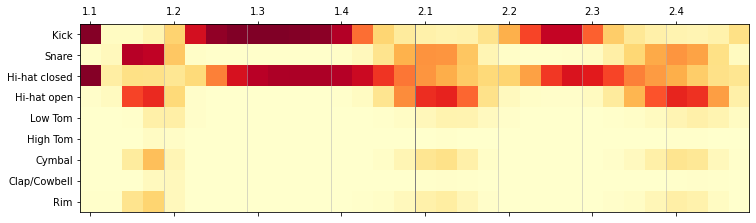

epoch: 168
m_d_loss: 0.26785088044901684     m_g_loss: 4.941258007166337


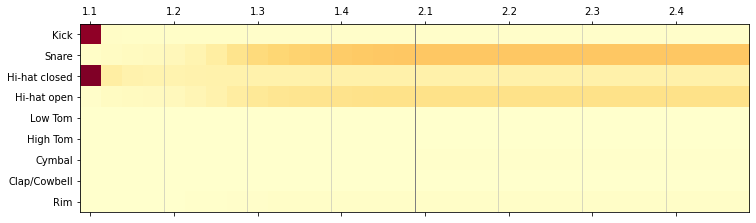

epoch: 169
m_d_loss: 0.2232537877559662     m_g_loss: 5.245027989757304


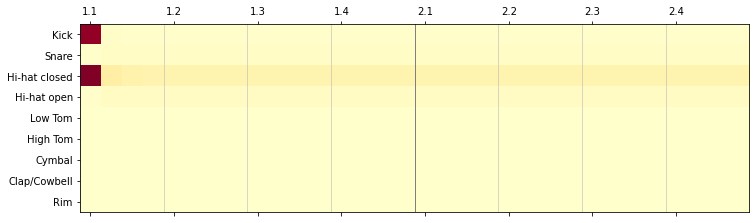

epoch: 170
m_d_loss: 0.22719776978095374     m_g_loss: 6.173532106438461


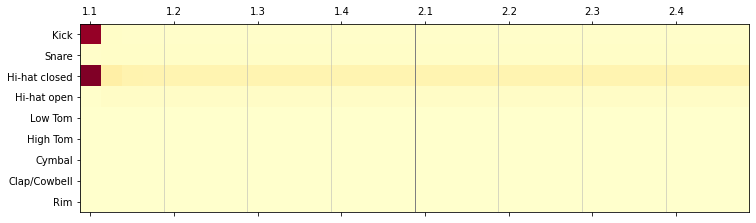

epoch: 171
m_d_loss: 0.20551264405250547     m_g_loss: 6.684146005280164


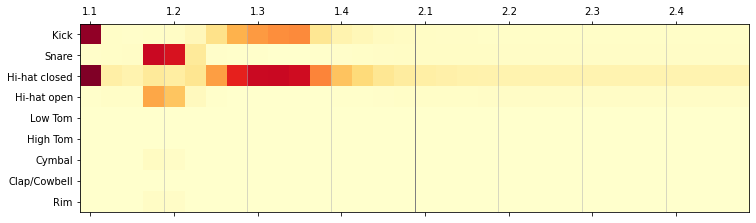

epoch: 172
m_d_loss: 0.20991979601482555     m_g_loss: 6.429796087498567


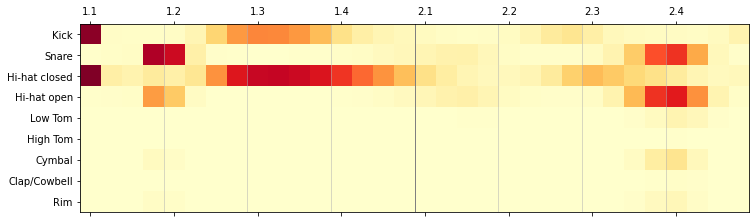

epoch: 173
m_d_loss: 0.21269997477531435     m_g_loss: 6.711669123902613


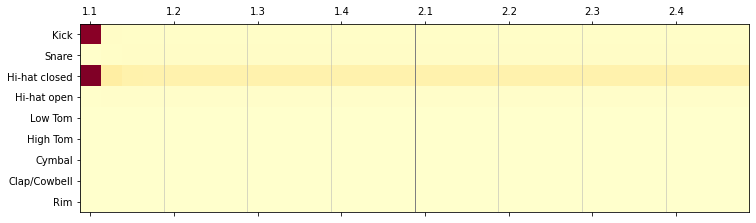

epoch: 174
m_d_loss: 0.2090252132465442     m_g_loss: 6.720669191710803


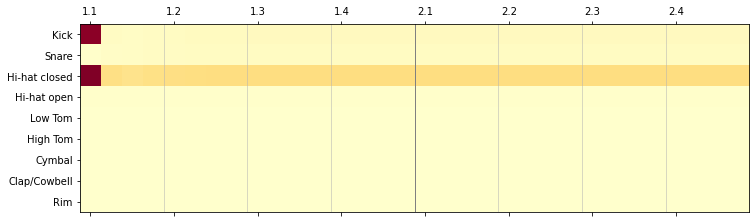

epoch: 175
m_d_loss: 0.1939322334527969     m_g_loss: 6.291476376202642


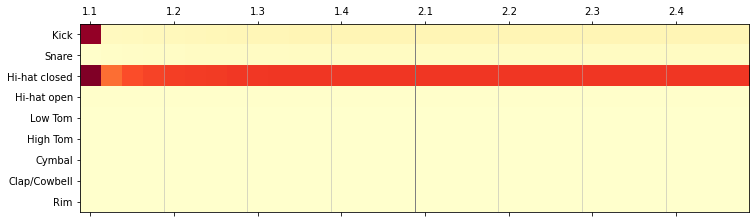

epoch: 176
m_d_loss: 0.17964235941569015     m_g_loss: 6.306883179411596


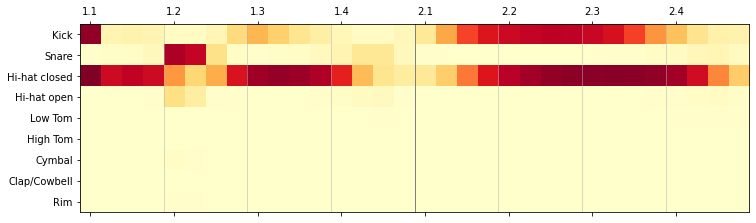

epoch: 177
m_d_loss: 0.21265806925296787     m_g_loss: 6.108290706362043


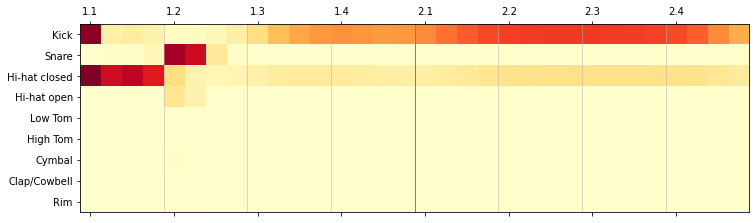

epoch: 178
m_d_loss: 0.1773321036249399     m_g_loss: 7.23996503985658


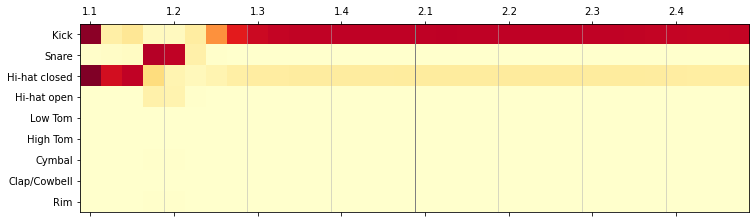

epoch: 179
m_d_loss: 0.17322921192646024     m_g_loss: 7.864859435023094


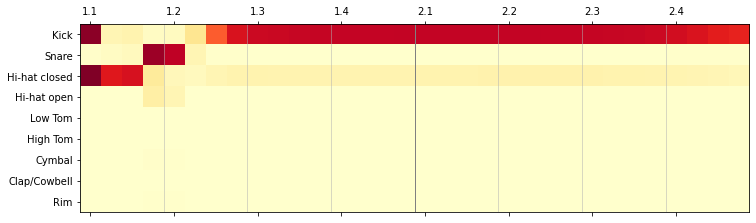

epoch: 180
m_d_loss: 0.21437464977304135     m_g_loss: 7.275621798573708


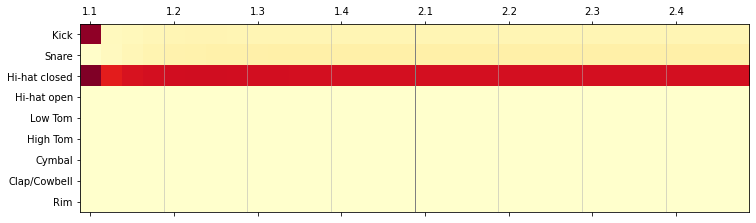

epoch: 181
m_d_loss: 0.23664216041564945     m_g_loss: 4.525093258643637


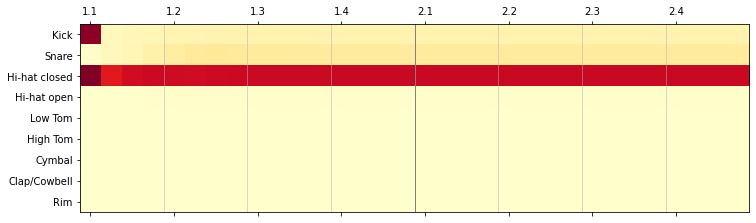

epoch: 182
m_d_loss: 0.197655463963747     m_g_loss: 5.23166392773998


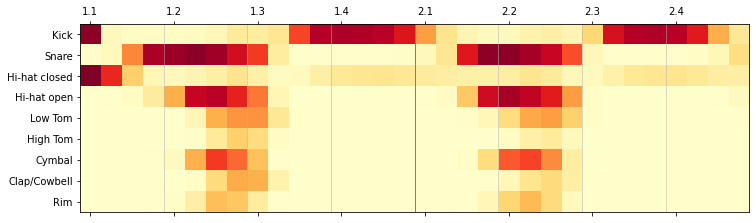

epoch: 183
m_d_loss: 0.20533265733718878     m_g_loss: 5.693580899919782


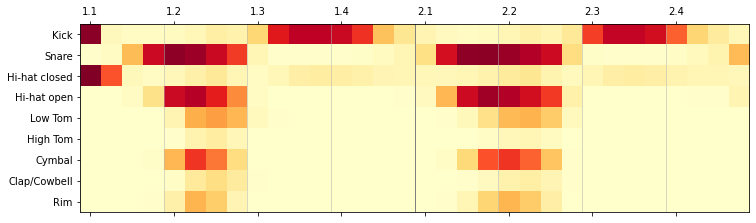

epoch: 184
m_d_loss: 0.23094862587749962     m_g_loss: 5.014866225573481


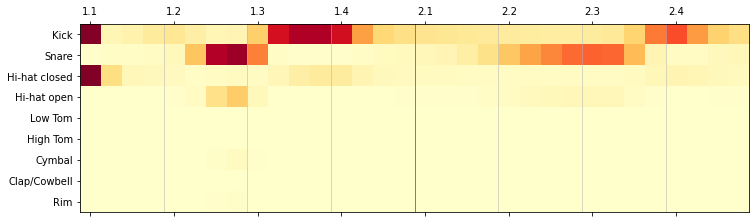

epoch: 185
m_d_loss: 0.2106467158794403     m_g_loss: 6.159521093173903


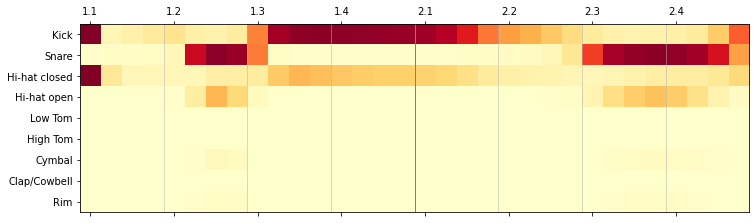

epoch: 186
m_d_loss: 0.18248964548110966     m_g_loss: 6.812488429400386


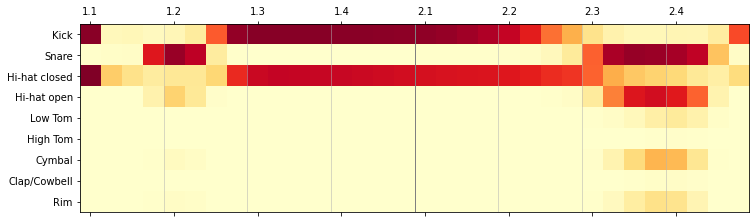

epoch: 187
m_d_loss: 0.23636534035205845     m_g_loss: 5.203703812190464


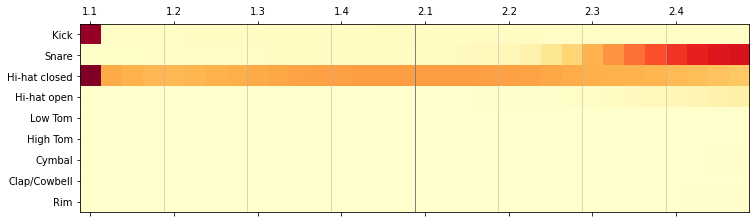

epoch: 188
m_d_loss: 0.18825261108577254     m_g_loss: 5.438671890570193


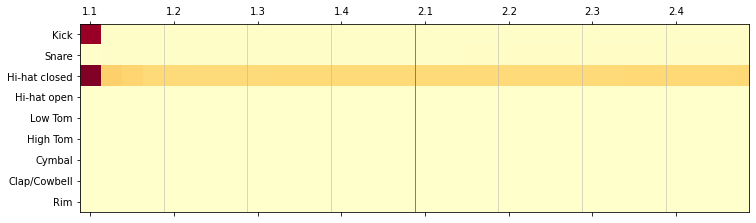

epoch: 189
m_d_loss: 0.20183464932441708     m_g_loss: 5.240962106354383


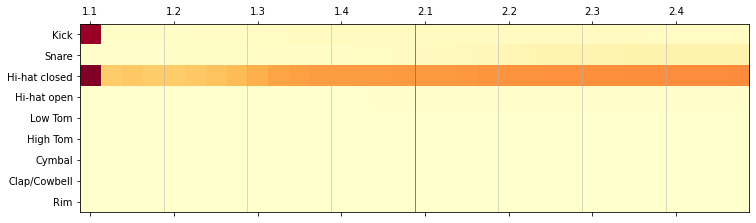

epoch: 190
m_d_loss: 0.1880243928482135     m_g_loss: 5.813791956220355


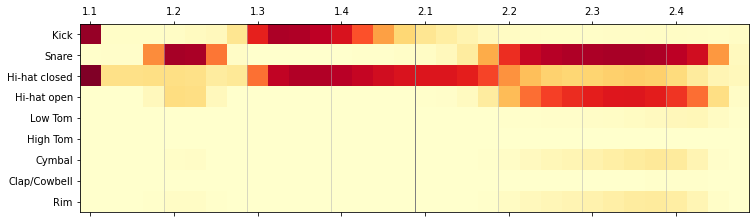

epoch: 191
m_d_loss: 0.18318074214458466     m_g_loss: 6.26567435751156


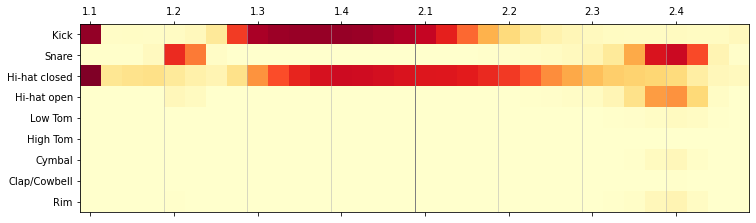

epoch: 192
m_d_loss: 0.19098767389853796     m_g_loss: 7.189178281900834


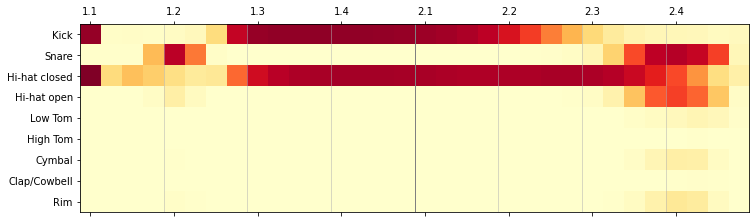

epoch: 193
m_d_loss: 0.18256904530525211     m_g_loss: 6.236917933639215


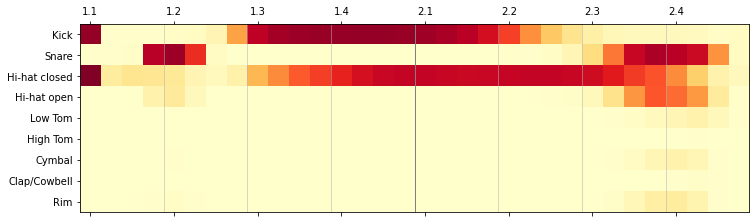

epoch: 194
m_d_loss: 0.17028442025184629     m_g_loss: 7.609332765851702


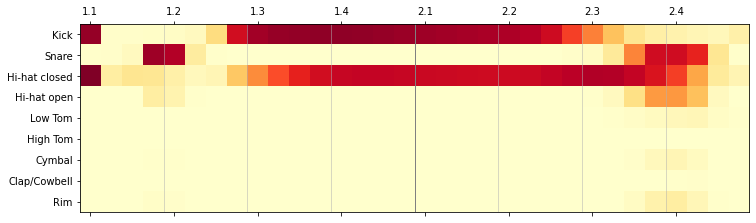

epoch: 195
m_d_loss: 0.16669997155666352     m_g_loss: 8.278896224742033


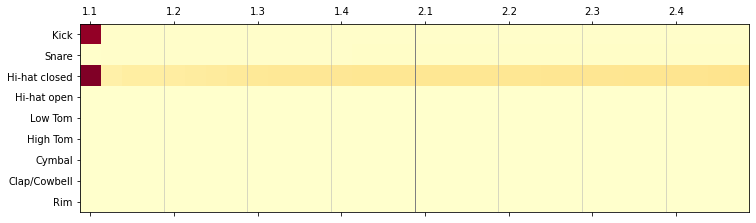

epoch: 196
m_d_loss: 0.18764059146245324     m_g_loss: 7.548884781039491


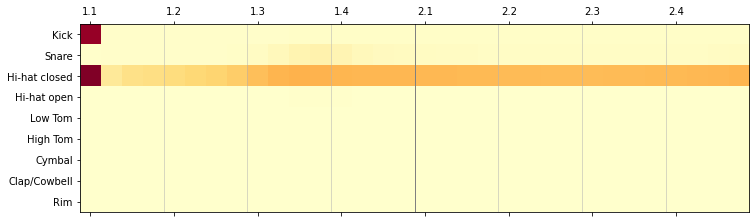

epoch: 197
m_d_loss: 0.19996050214767455     m_g_loss: 6.50190527585088


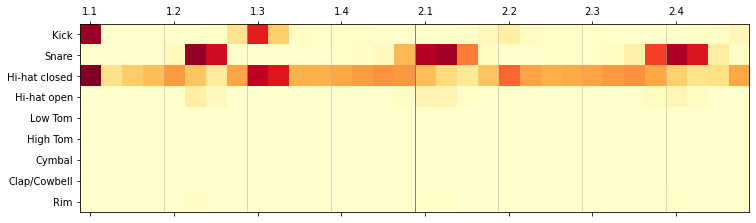

epoch: 198
m_d_loss: 0.17689132479329903     m_g_loss: 6.710617308713952


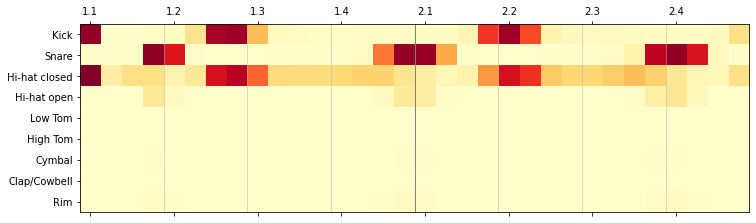

epoch: 199
m_d_loss: 0.2070623873472214     m_g_loss: 5.944585858559122


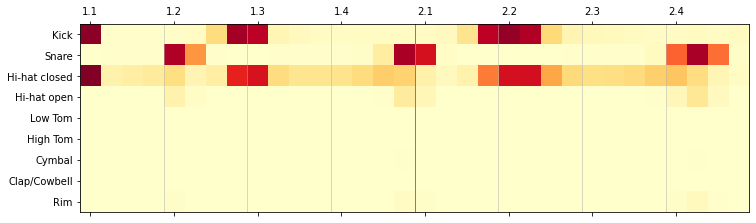

epoch: 200
m_d_loss: 0.19687987032035983     m_g_loss: 6.915619859890062


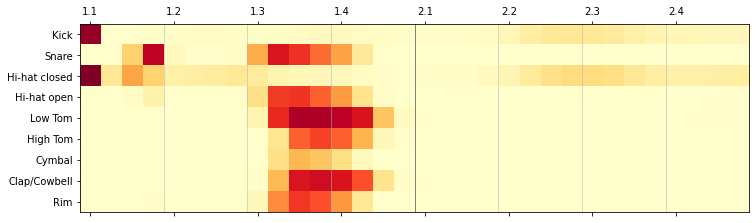

epoch: 201
m_d_loss: 0.20046638536453248     m_g_loss: 6.7104842127585895


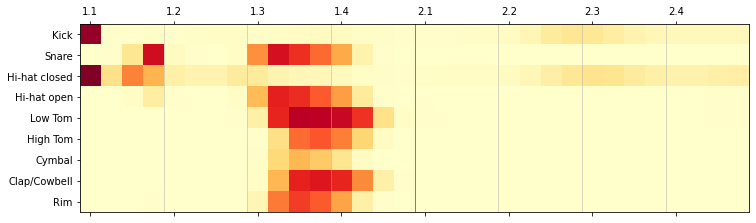

epoch: 202
m_d_loss: 0.19398843298355736     m_g_loss: 6.335695140215815


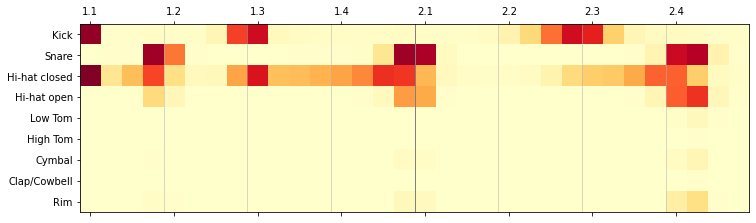

epoch: 203
m_d_loss: 0.20417008197307585     m_g_loss: 6.3031870637621195


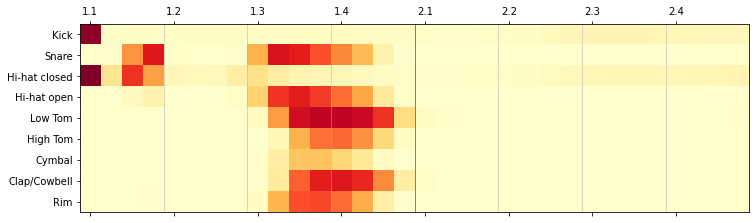

epoch: 204
m_d_loss: 0.20244872917731604     m_g_loss: 6.2579289553116775


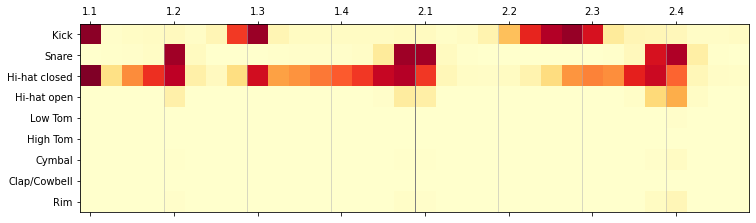

epoch: 205
m_d_loss: 0.19798764288425447     m_g_loss: 6.078374512341558


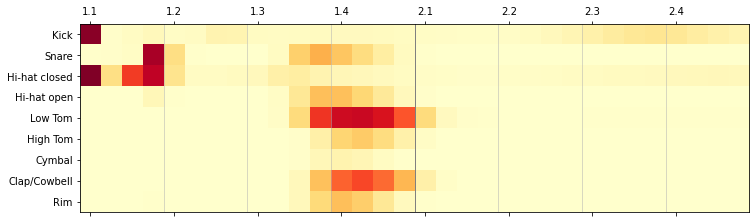

epoch: 206
m_d_loss: 0.20698198390503722     m_g_loss: 5.63085785690619


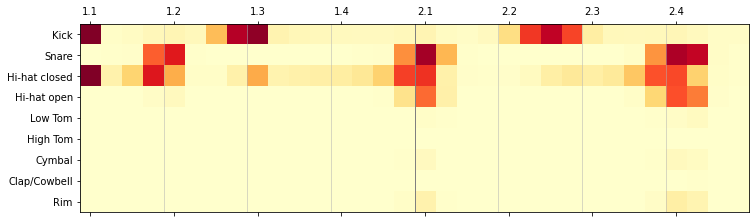

epoch: 207
m_d_loss: 0.1905997484922409     m_g_loss: 6.492356660414715


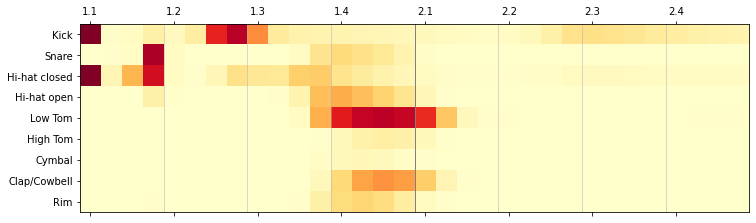

epoch: 208
m_d_loss: 0.34869246855378155     m_g_loss: 5.052788170016542


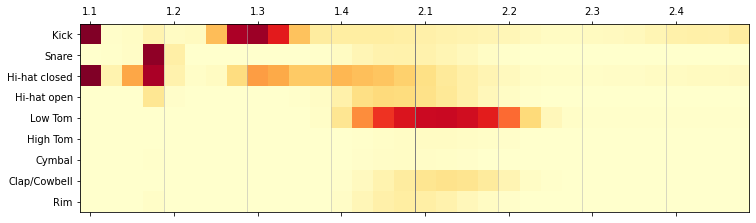

epoch: 209
m_d_loss: 0.19832664632797242     m_g_loss: 5.773194098959164


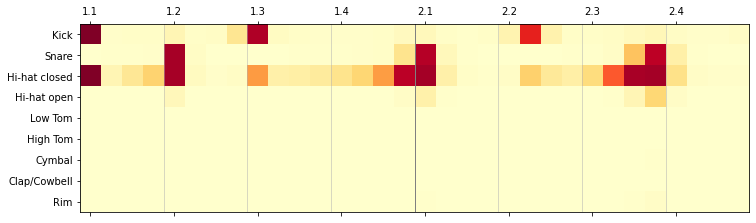

epoch: 210
m_d_loss: 0.1864579277733962     m_g_loss: 6.8058295249938965


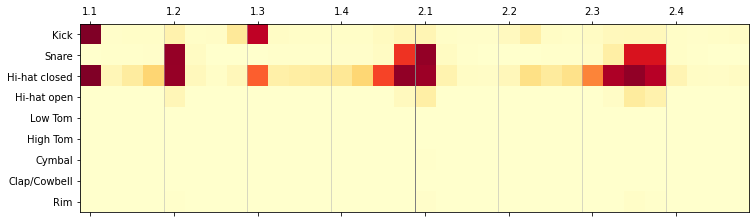

epoch: 211
m_d_loss: 0.1879051038026809     m_g_loss: 6.220779788737395


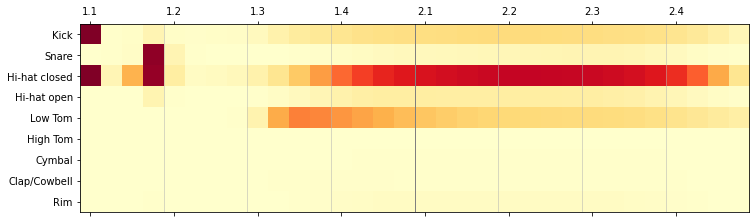

epoch: 212
m_d_loss: 0.18676219706734018     m_g_loss: 6.316090403770914


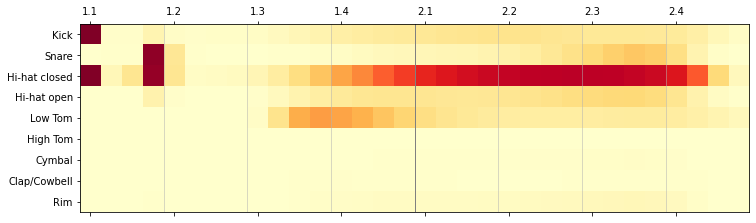

epoch: 213
m_d_loss: 0.17717036032676695     m_g_loss: 6.579061177312111


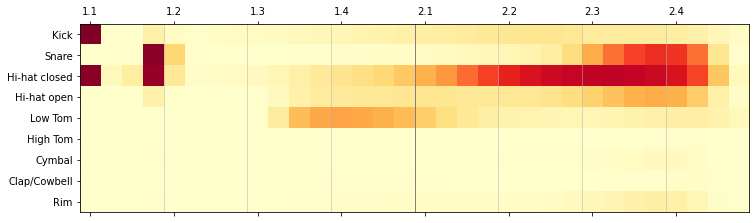

epoch: 214
m_d_loss: 0.190939337387681     m_g_loss: 6.074992432886241


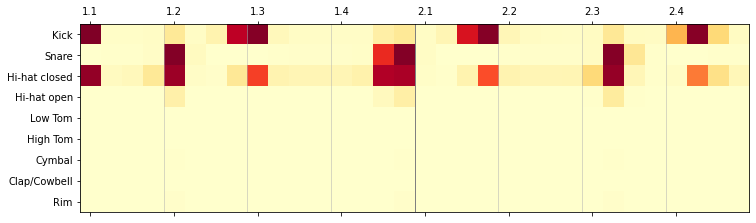

epoch: 215
m_d_loss: 0.1949913138151169     m_g_loss: 6.09483713033248


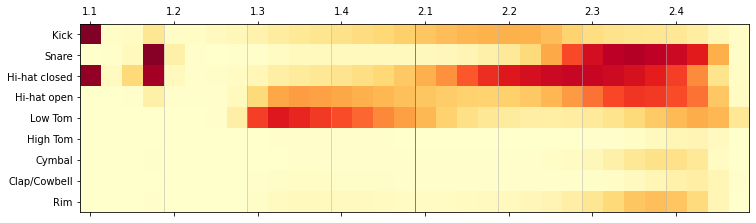

epoch: 216
m_d_loss: 0.22157038624087969     m_g_loss: 4.87777041415779


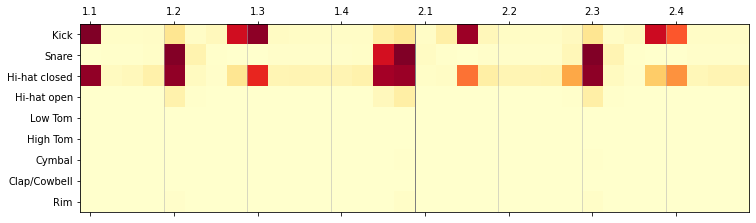

epoch: 217
m_d_loss: 0.19924179446697235     m_g_loss: 5.891467065227275


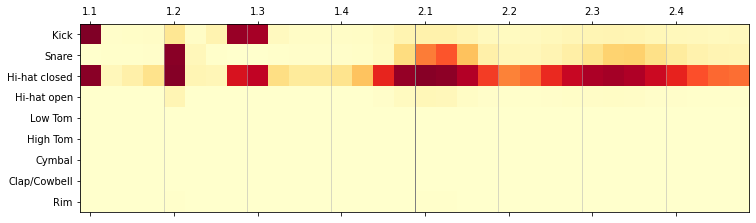

epoch: 218
m_d_loss: 0.18996273900071783     m_g_loss: 5.88671892516467


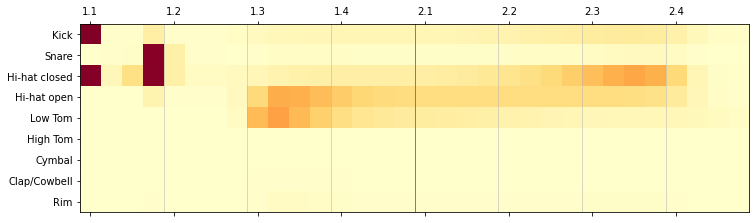

epoch: 219
m_d_loss: 0.1753532851934433     m_g_loss: 6.320240954963529


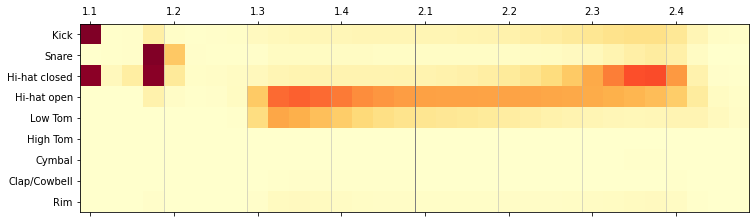

epoch: 220
m_d_loss: 0.17438862100243566     m_g_loss: 7.4969775238815615


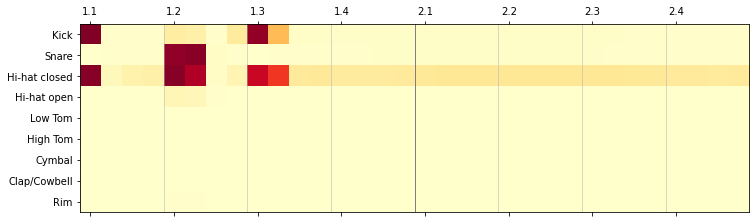

epoch: 221
m_d_loss: 0.18401200687885277     m_g_loss: 7.92052393543477


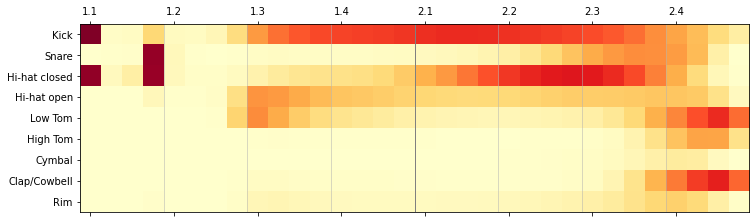

epoch: 222
m_d_loss: 0.18305476916333038     m_g_loss: 7.345646663587921


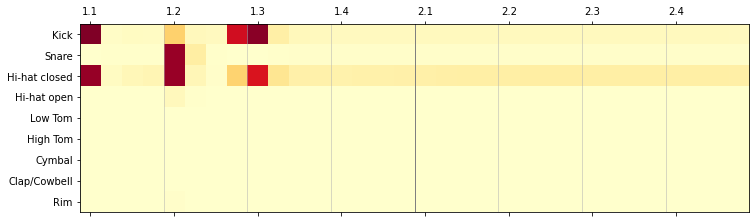

epoch: 223
m_d_loss: 0.18920520937442778     m_g_loss: 6.773464592135682


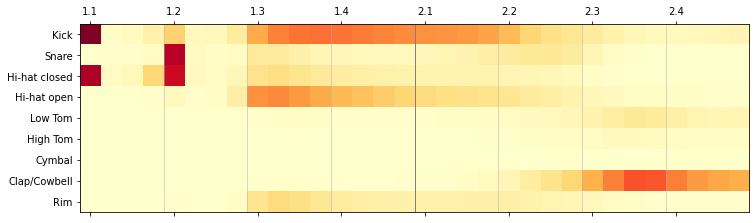

epoch: 224
m_d_loss: 0.20461838704844318     m_g_loss: 6.443651929193614


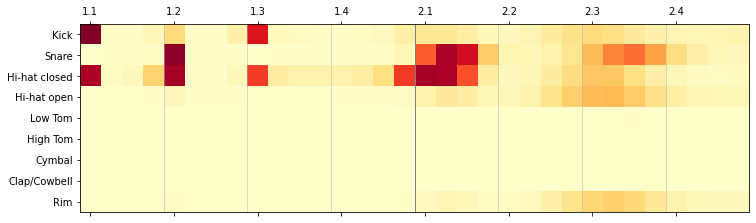

epoch: 225
m_d_loss: 0.19864197635650638     m_g_loss: 6.068462877857442


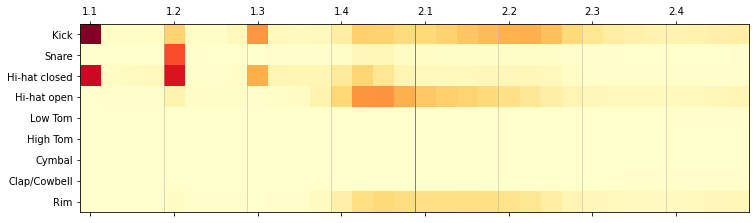

epoch: 226
m_d_loss: 0.19232589912911258     m_g_loss: 6.3349231992449075


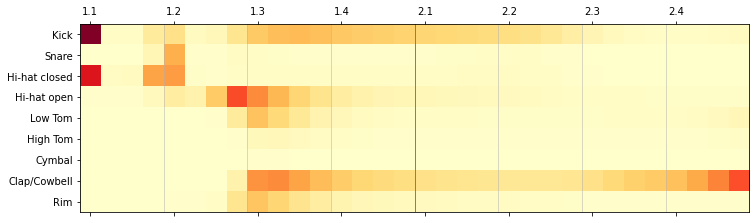

epoch: 227
m_d_loss: 0.2450324877500534     m_g_loss: 4.963101815204231


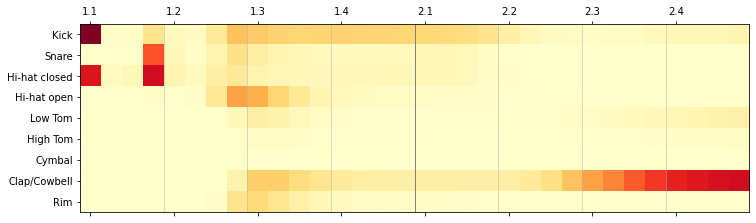

epoch: 228
m_d_loss: 0.20309699177742005     m_g_loss: 5.637970335629522


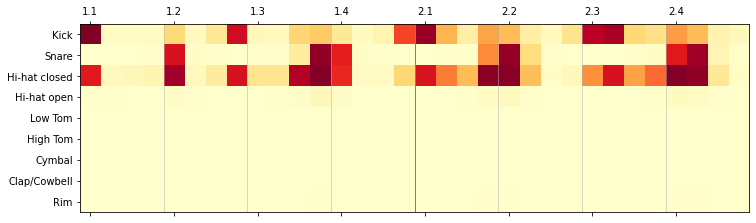

epoch: 229
m_d_loss: 0.1898954116106033     m_g_loss: 5.669538215715058


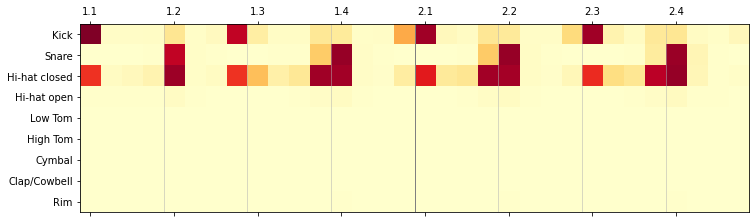

epoch: 230
m_d_loss: 0.20140581056475645     m_g_loss: 6.249987631427999


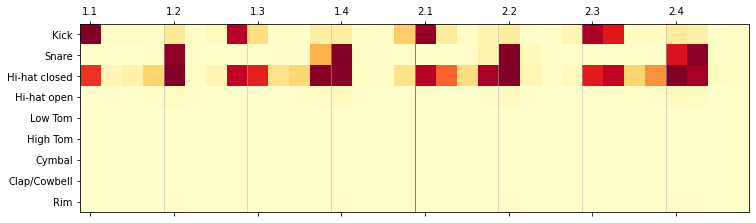

epoch: 231
m_d_loss: 0.19292993295192715     m_g_loss: 6.092486469113097


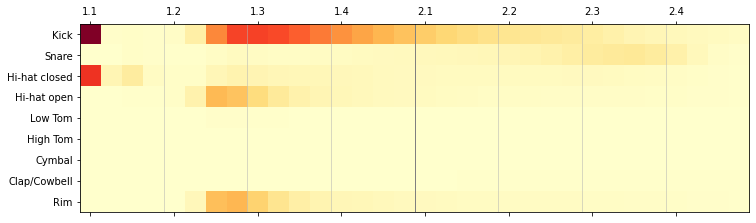

epoch: 232
m_d_loss: 0.21946800289054713     m_g_loss: 5.777403486018279


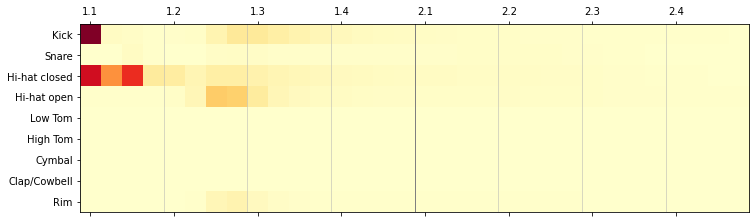

epoch: 233
m_d_loss: 0.2113473984003066     m_g_loss: 5.761078688563133


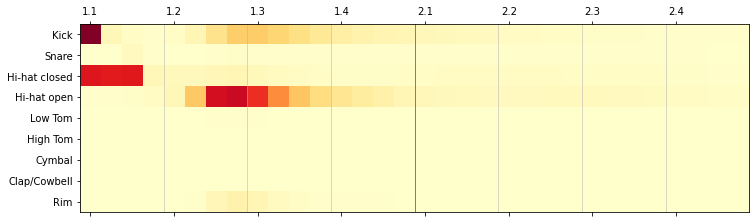

epoch: 234
m_d_loss: 0.20155808043976622     m_g_loss: 5.365703874704789


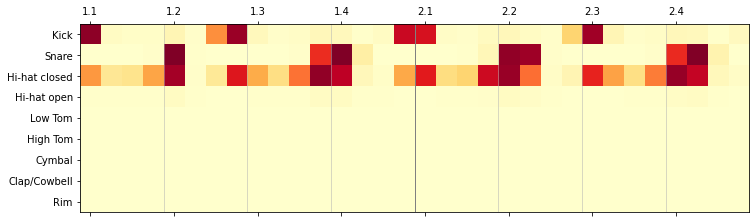

epoch: 235
m_d_loss: 0.22087181997299196     m_g_loss: 5.140656962686656


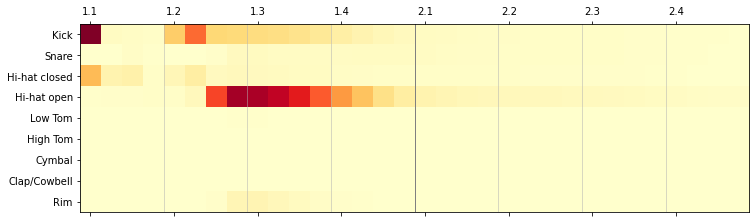

epoch: 236
m_d_loss: 0.18575856747726602     m_g_loss: 5.9961177378284685


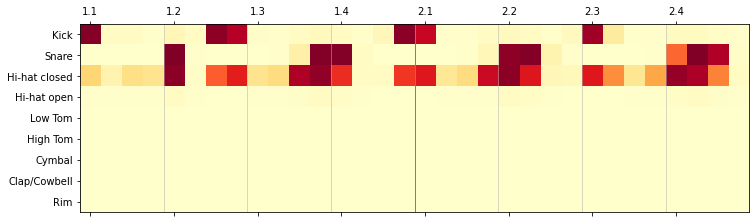

epoch: 237
m_d_loss: 0.201785236120224     m_g_loss: 6.089183495969189


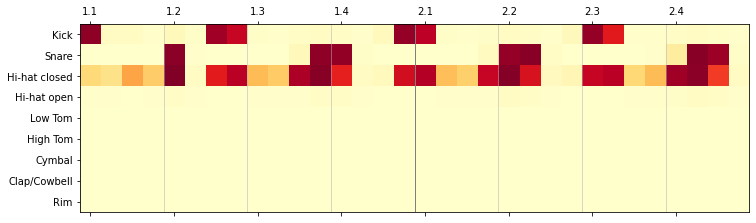

epoch: 238
m_d_loss: 0.18556859480837984     m_g_loss: 6.514412675585065


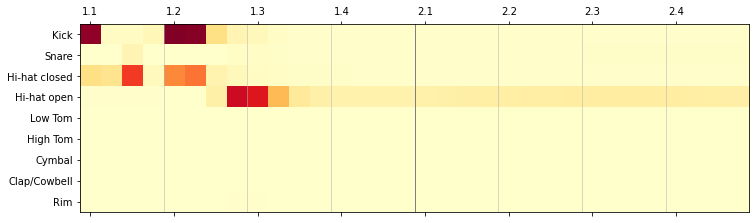

epoch: 239
m_d_loss: 0.21317773032188417     m_g_loss: 5.6482753364407285


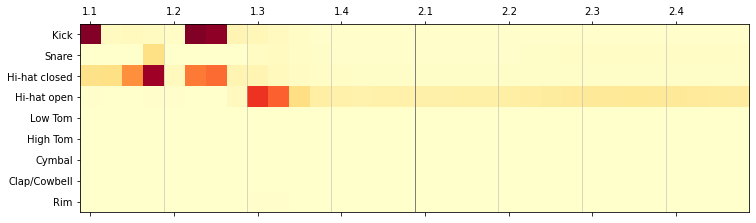

epoch: 240
m_d_loss: 0.19048887789249425     m_g_loss: 5.966113217022954


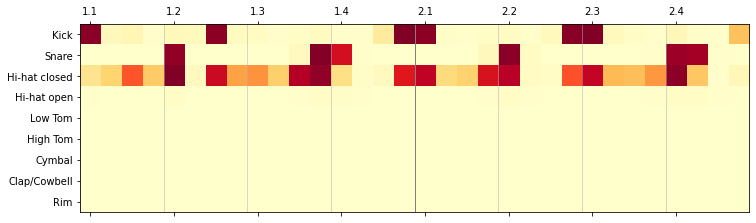

epoch: 241
m_d_loss: 0.20499527215957639     m_g_loss: 6.140640852402668


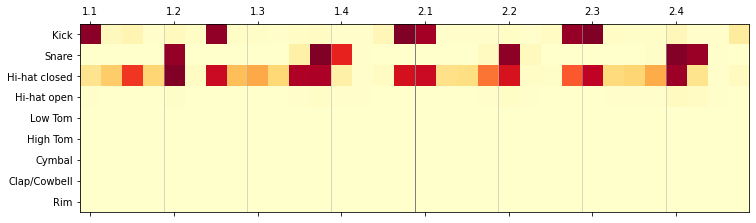

epoch: 242
m_d_loss: 0.19759595952928066     m_g_loss: 6.143539273009008


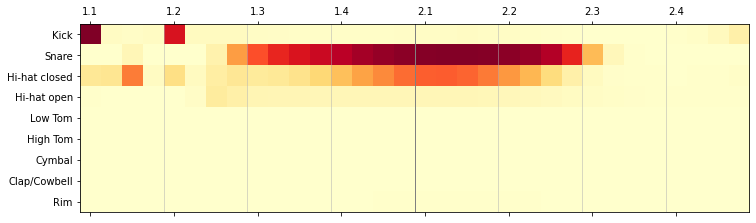

epoch: 243
m_d_loss: 0.18510304915905     m_g_loss: 6.943397989078444


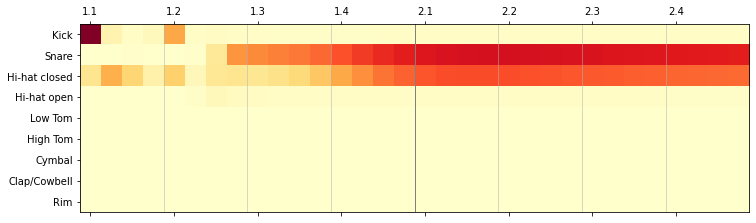

epoch: 244
m_d_loss: 0.1865710770090421     m_g_loss: 7.844277362434232


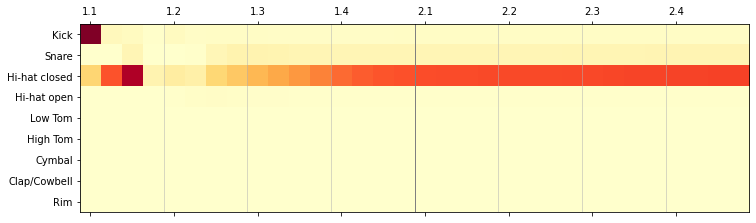

epoch: 245
m_d_loss: 0.1848010845184326     m_g_loss: 8.379113917448082


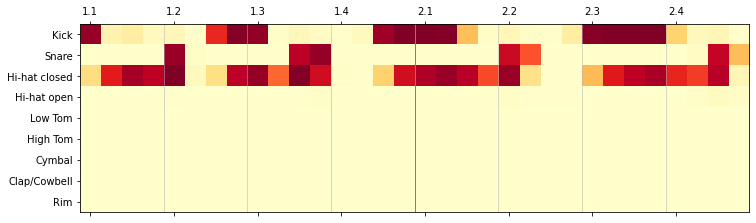

epoch: 246
m_d_loss: 0.2173080726216237     m_g_loss: 5.835685554815798


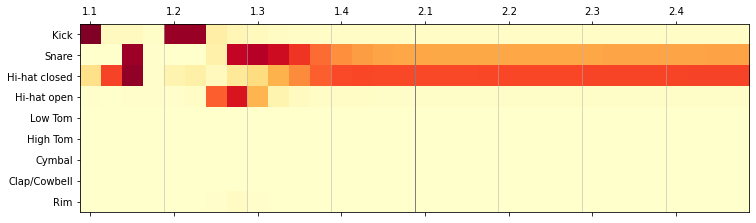

epoch: 247
m_d_loss: 0.21842978799343107     m_g_loss: 5.265107777653908


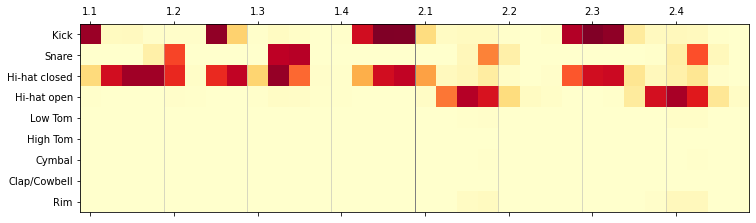

epoch: 248
m_d_loss: 0.20051887842516106     m_g_loss: 6.459044437019193


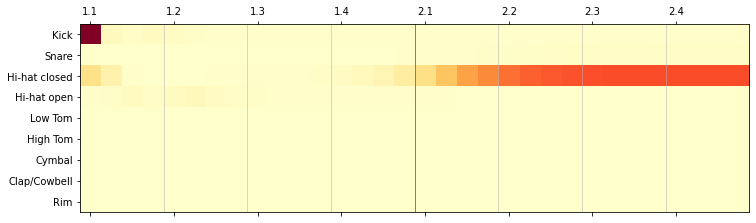

epoch: 249
m_d_loss: 0.17676170134544372     m_g_loss: 6.886631333098119


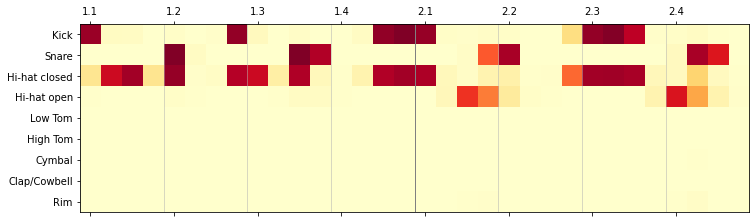

epoch: 250
m_d_loss: 0.2114119155953328     m_g_loss: 7.663784241189762


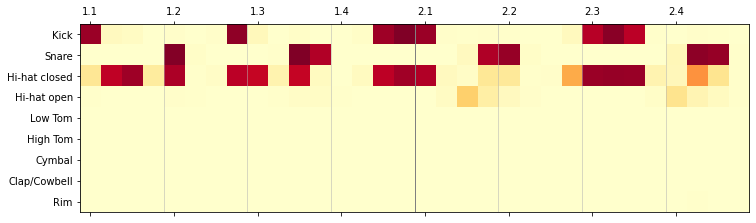

epoch: 251
m_d_loss: 0.1882209354639053     m_g_loss: 6.725343246849215


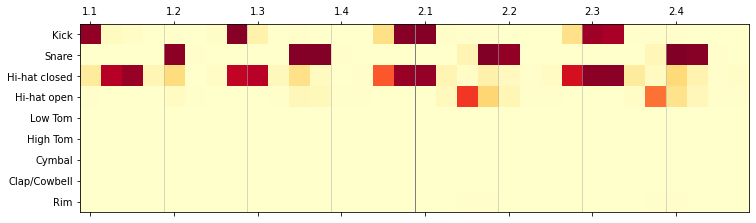

epoch: 252
m_d_loss: 0.21428347453474997     m_g_loss: 6.424531167867232


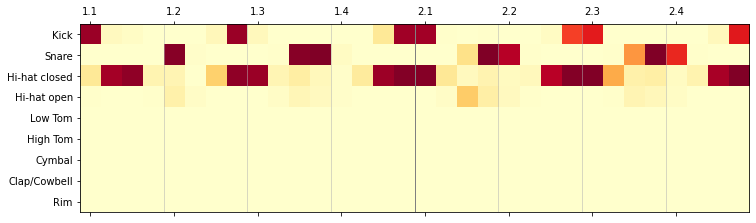

epoch: 253
m_d_loss: 0.2061564563512802     m_g_loss: 6.467861087954774


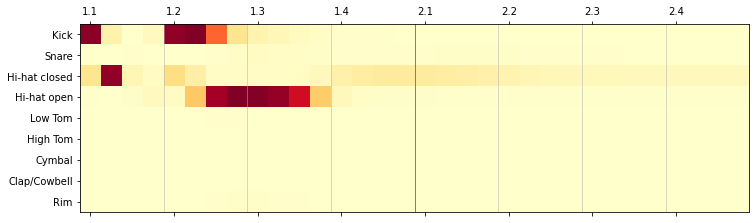

epoch: 254
m_d_loss: 0.23192830197513103     m_g_loss: 5.999927520751953


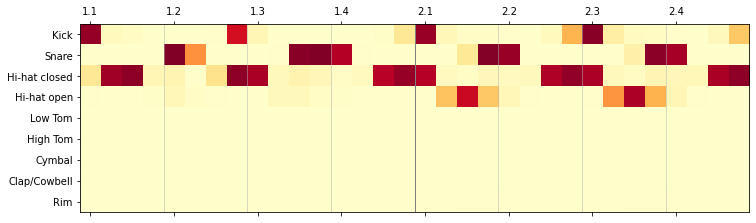

epoch: 255
m_d_loss: 0.26845974040031434     m_g_loss: 4.527130740029471


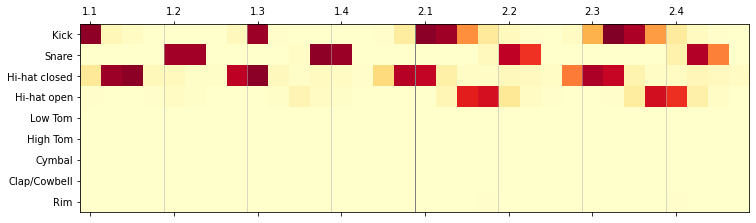

epoch: 256
m_d_loss: 0.20723345962663495     m_g_loss: 5.448237740263647


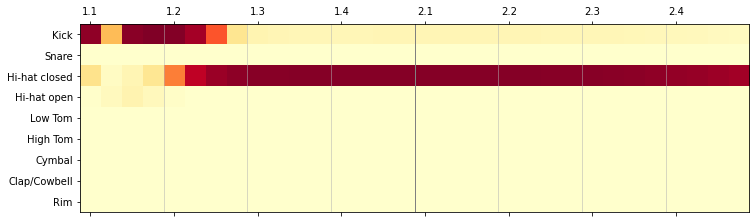

epoch: 257
m_d_loss: 0.21984224963188168     m_g_loss: 6.1166811281321


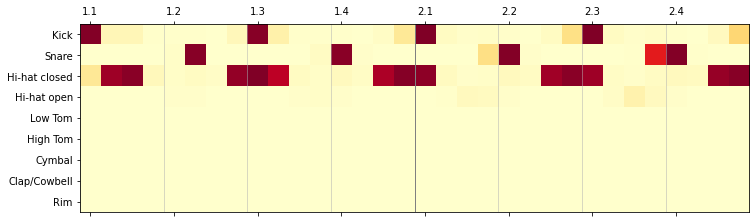

epoch: 258
m_d_loss: 0.20360406401256717     m_g_loss: 6.185829240448621


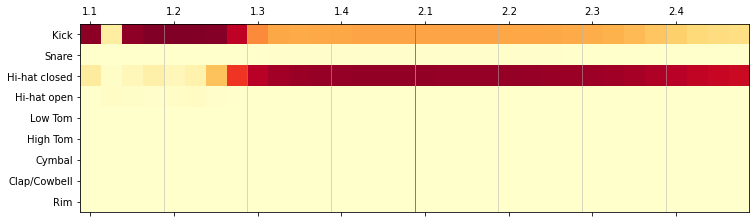

epoch: 259
m_d_loss: 0.1864033958911896     m_g_loss: 7.090985891770344


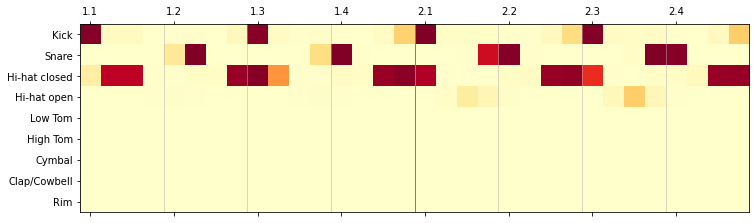

epoch: 260
m_d_loss: 0.19070557877421382     m_g_loss: 7.101159144421013


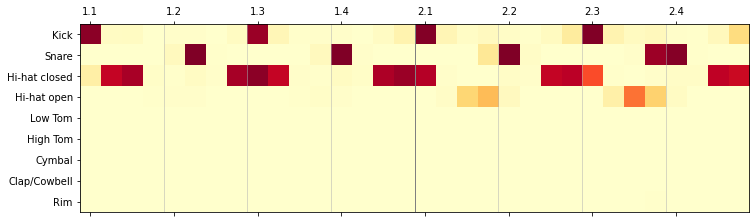

epoch: 261
m_d_loss: 0.2032358705997467     m_g_loss: 7.343358380453927


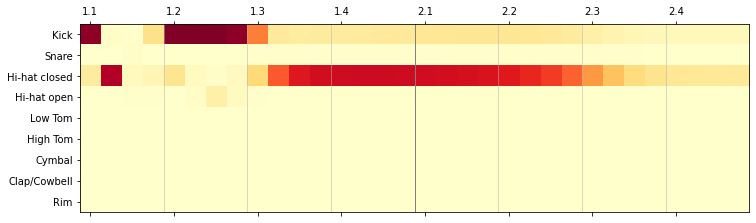

epoch: 262
m_d_loss: 0.21182498584191     m_g_loss: 7.177255795926464


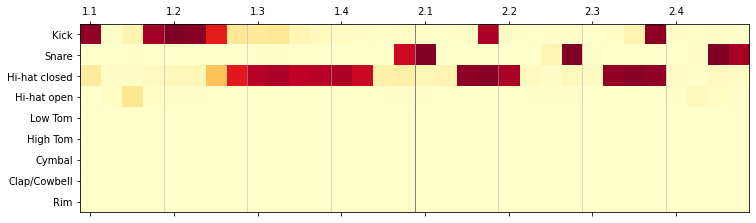

epoch: 263
m_d_loss: 0.18326116478443144     m_g_loss: 7.670537004665452


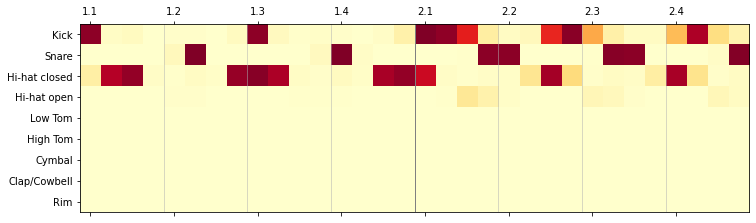

epoch: 264
m_d_loss: 0.19176916542152558     m_g_loss: 7.383256785723628


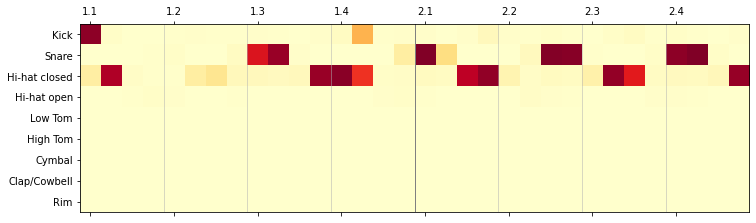

epoch: 265
m_d_loss: 0.1915327388048172     m_g_loss: 7.027675171287692


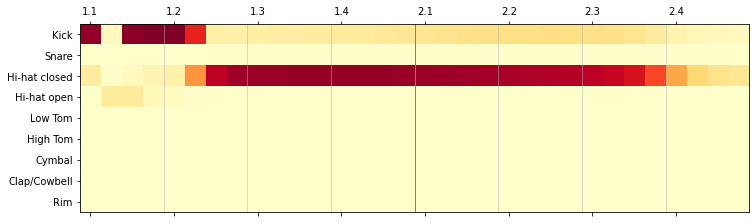

epoch: 266
m_d_loss: 0.18209094603856404     m_g_loss: 7.893185313867063


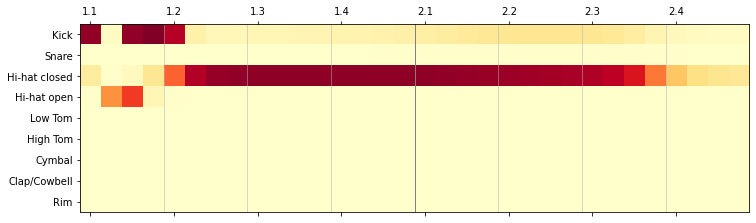

epoch: 267
m_d_loss: 0.1884540427923202     m_g_loss: 8.429127975386017


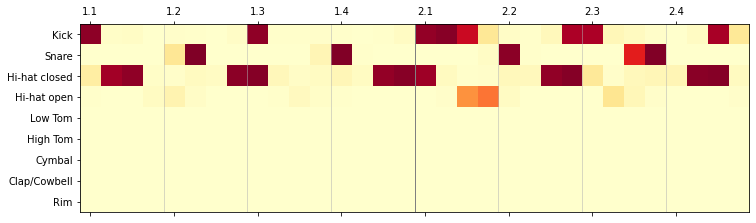

epoch: 268
m_d_loss: 0.19190711441139385     m_g_loss: 8.898581602135483


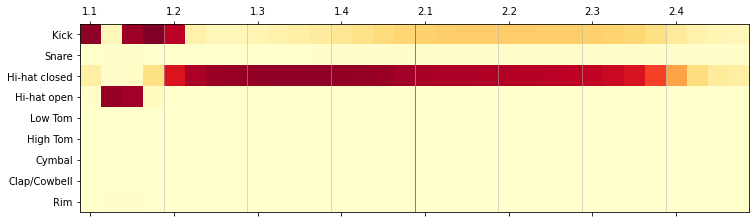

epoch: 269
m_d_loss: 0.19015940940380097     m_g_loss: 8.625361695581553


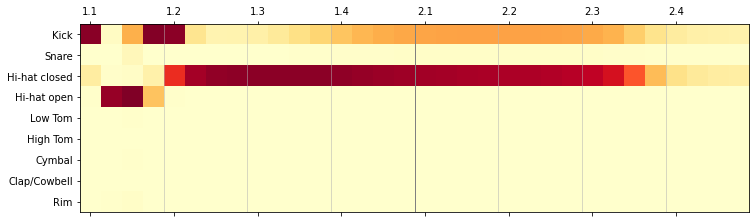

epoch: 270
m_d_loss: 0.2096163930992285     m_g_loss: 8.111027484037438


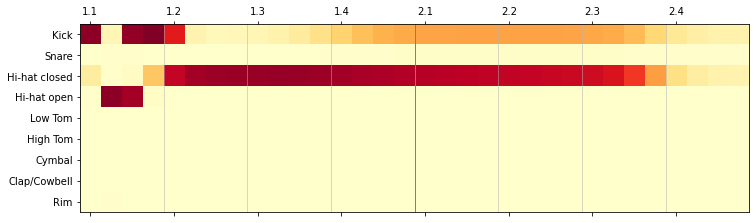

epoch: 271
m_d_loss: 0.1911915292739868     m_g_loss: 8.50625941218162


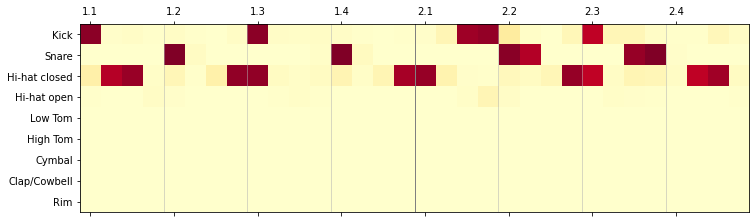

epoch: 272
m_d_loss: 0.19438788841168086     m_g_loss: 8.109574804500658


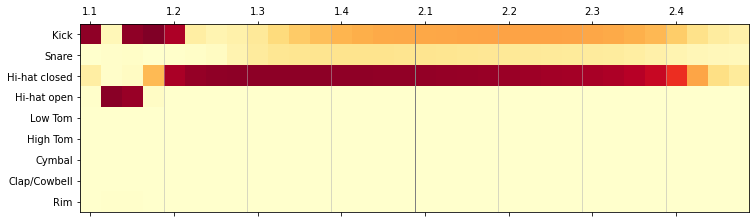

epoch: 273
m_d_loss: 0.2037531259059906     m_g_loss: 8.580873032005465


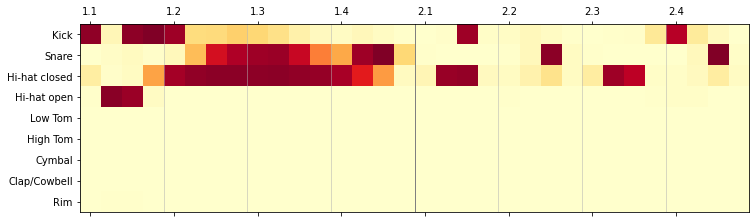

epoch: 274
m_d_loss: 0.1893227942287922     m_g_loss: 9.455859807072853


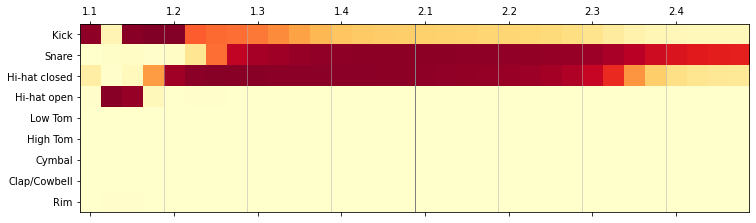

epoch: 275
m_d_loss: 0.25849380683898926     m_g_loss: 6.6014434366810075


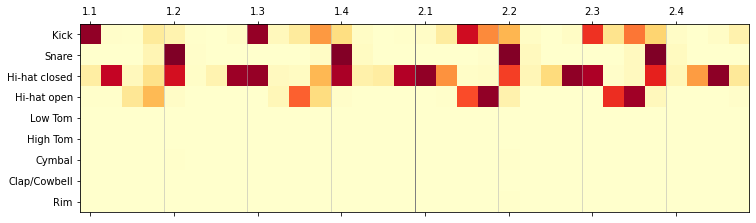

epoch: 276
m_d_loss: 0.20501933333774405     m_g_loss: 6.815433589779601


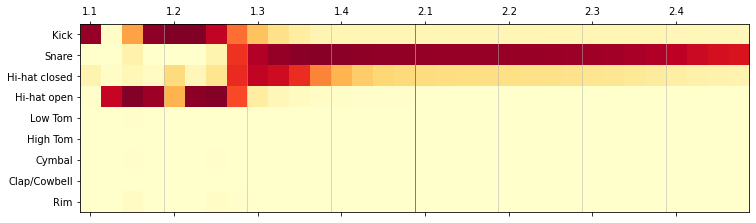

epoch: 277
m_d_loss: 0.25953561663627633     m_g_loss: 5.83015267702998


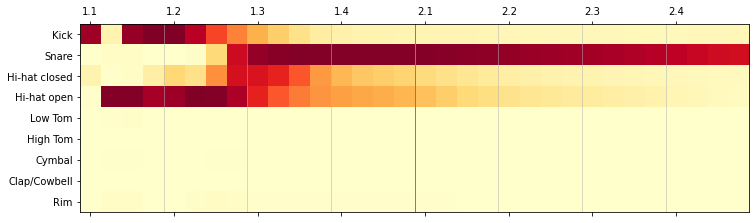

epoch: 278
m_d_loss: 0.20733047661681972     m_g_loss: 6.185852527618408


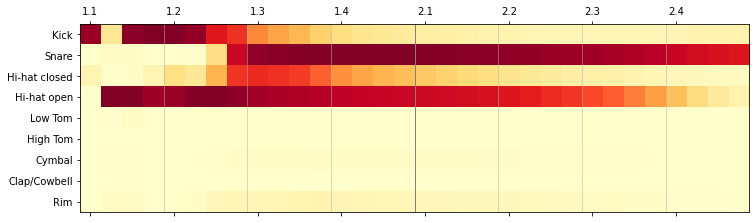

epoch: 279
m_d_loss: 0.2123092355728149     m_g_loss: 6.922272049650854


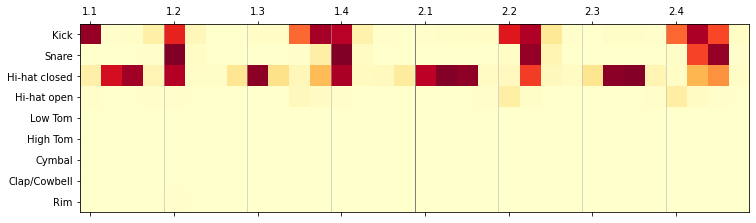

epoch: 280
m_d_loss: 0.19905574545264246     m_g_loss: 7.206353537890376


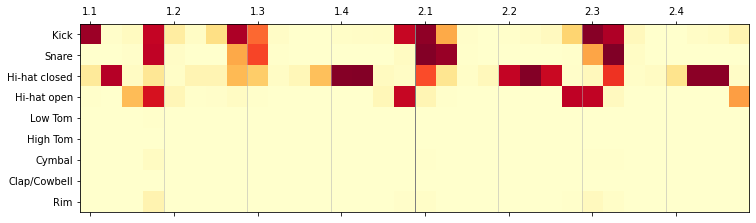

epoch: 281
m_d_loss: 0.2264268840551377     m_g_loss: 6.037291195927834


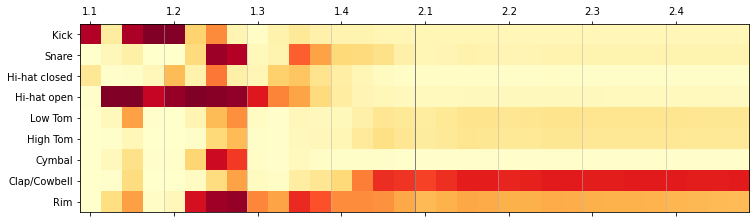

epoch: 282
m_d_loss: 0.23862209568421044     m_g_loss: 5.384937101480912


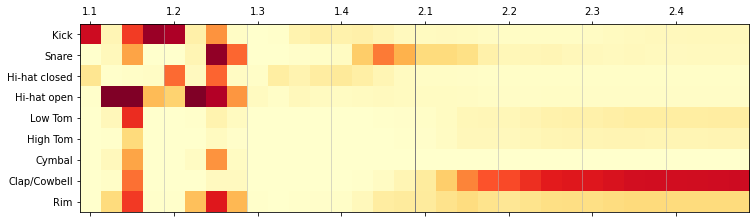

epoch: 283
m_d_loss: 0.25498844134807586     m_g_loss: 4.617036765935469


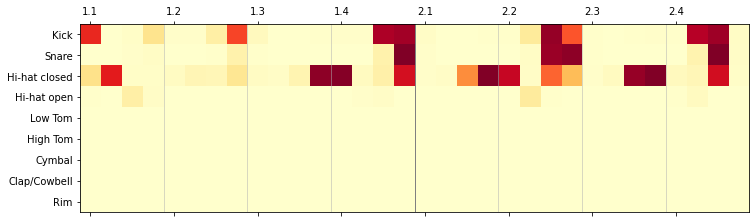

epoch: 284
m_d_loss: 0.2020798616111279     m_g_loss: 5.960134584076551


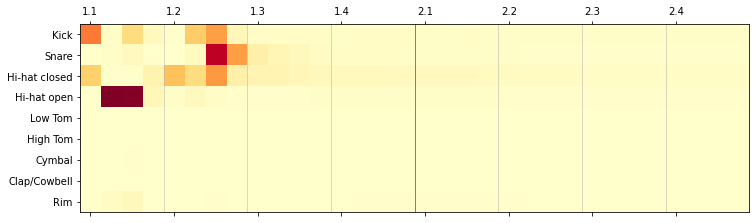

epoch: 285
m_d_loss: 0.2623722993135452     m_g_loss: 4.9565536537948915


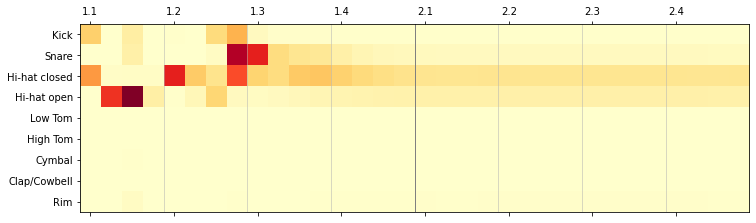

epoch: 286
m_d_loss: 0.2513165585696698     m_g_loss: 4.000402698711473


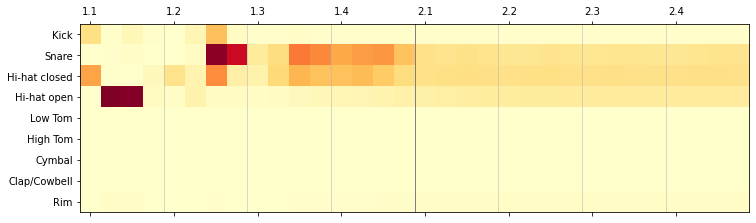

epoch: 287
m_d_loss: 0.23900139045715332     m_g_loss: 4.6466999102611934


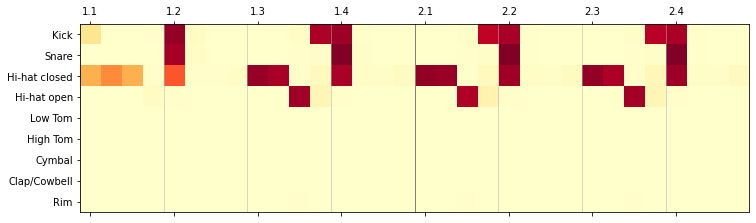

epoch: 288
m_d_loss: 0.20891805278758205     m_g_loss: 5.7215530045178475


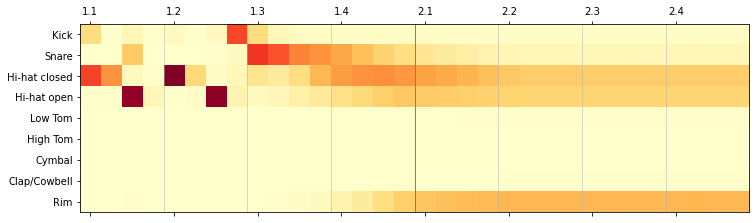

epoch: 289
m_d_loss: 0.21153991186618804     m_g_loss: 5.780004749492723


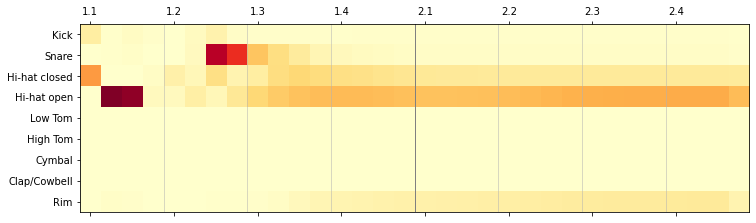

epoch: 290
m_d_loss: 0.1894195189078649     m_g_loss: 7.029256859604193


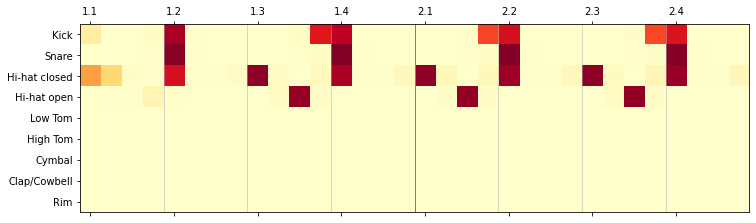

epoch: 291
m_d_loss: 0.2225557042360306     m_g_loss: 7.487525399850339


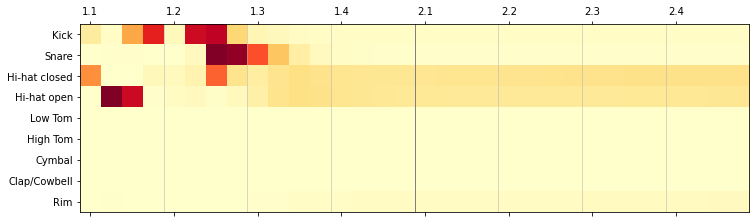

epoch: 292
m_d_loss: 0.2082660764455795     m_g_loss: 7.1223643263992


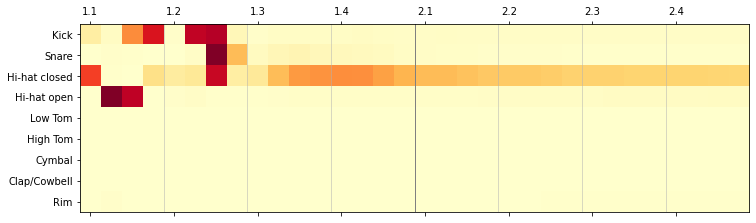

epoch: 293
m_d_loss: 0.19502893972396848     m_g_loss: 7.531063031177132


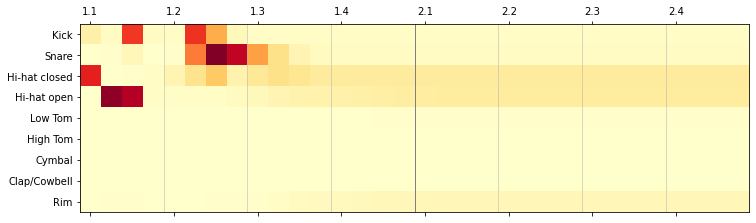

epoch: 294
m_d_loss: 0.19240096199015777     m_g_loss: 6.999519056203414


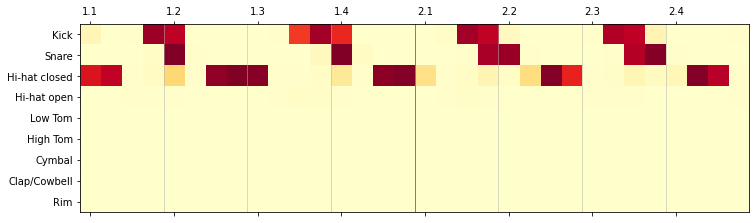

epoch: 295
m_d_loss: 0.223377538561821     m_g_loss: 6.1738583798311195


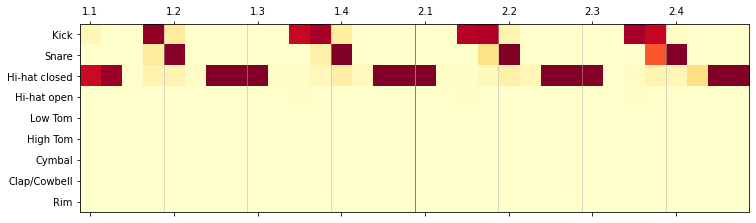

epoch: 296
m_d_loss: 0.20378589282433188     m_g_loss: 5.781505730687355


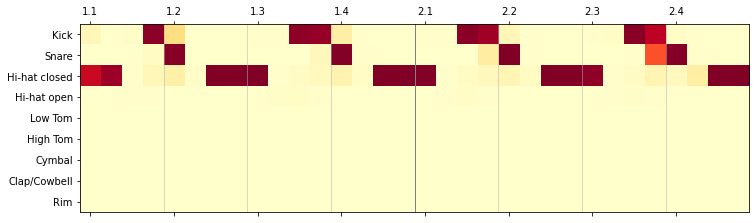

epoch: 297
m_d_loss: 0.18182607400417322     m_g_loss: 6.714928519969084


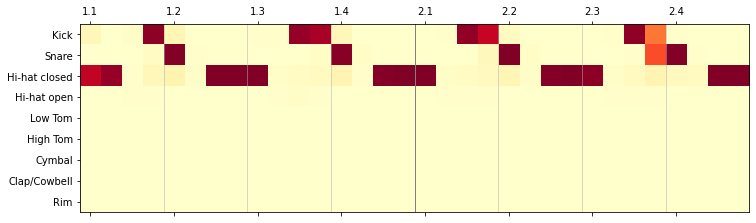

epoch: 298
m_d_loss: 0.18832825484375157     m_g_loss: 7.312089258310746


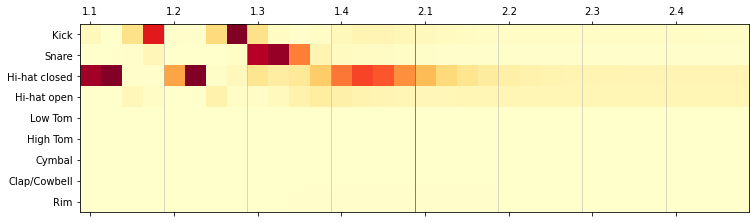

epoch: 299
m_d_loss: 0.18368017709255216     m_g_loss: 7.795509990380735


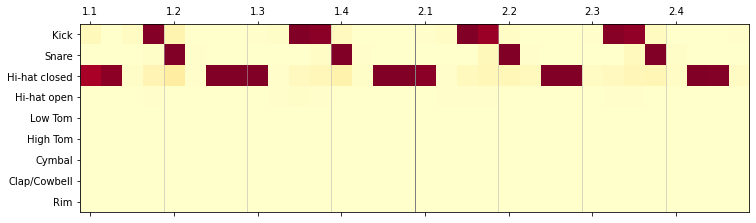

epoch: 300
m_d_loss: 0.19837659349044168     m_g_loss: 7.094298411388786


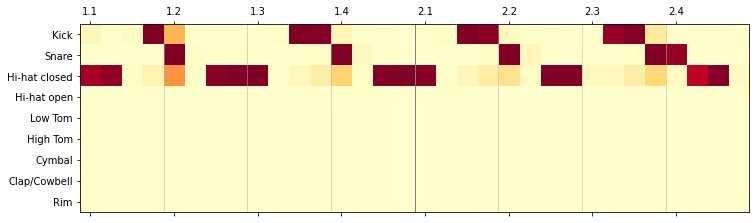

epoch: 301
m_d_loss: 0.18923845601081848     m_g_loss: 7.315701231664541


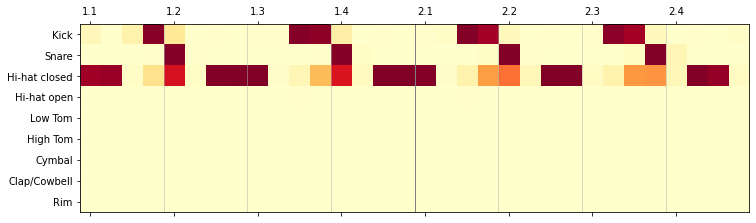

epoch: 302
m_d_loss: 0.20193382476766908     m_g_loss: 7.675748338504714


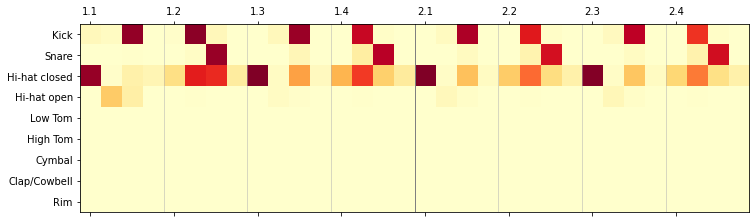

epoch: 303
m_d_loss: 0.26215343546867365     m_g_loss: 4.1222382029708555


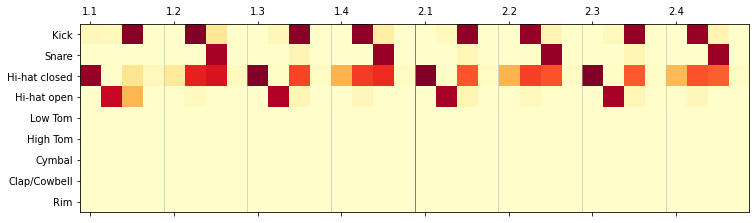

epoch: 304
m_d_loss: 0.25026730597019187     m_g_loss: 4.0083039828709195


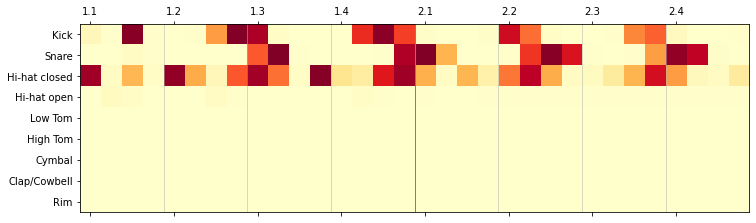

epoch: 305
m_d_loss: 0.24555993890762326     m_g_loss: 4.179016230057697


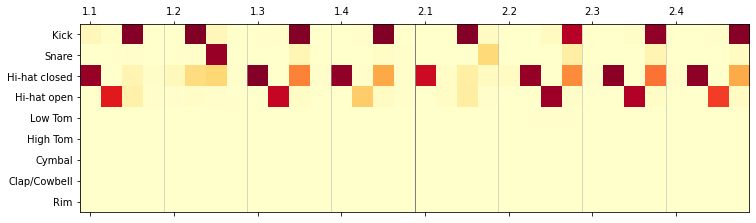

epoch: 306
m_d_loss: 0.22785751111805444     m_g_loss: 4.452545204941107


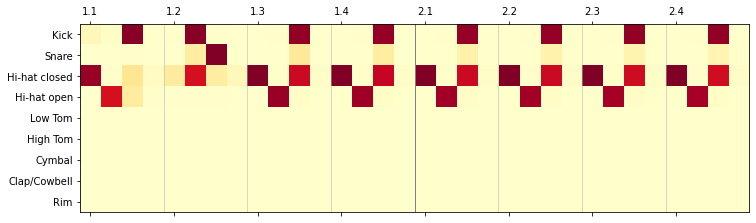

epoch: 307
m_d_loss: 0.2334455248117447     m_g_loss: 4.786503207926848


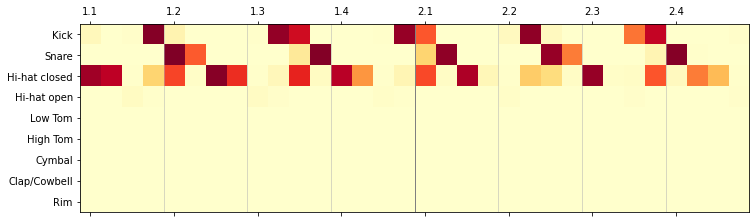

epoch: 308
m_d_loss: 0.23579387317101164     m_g_loss: 4.809852298425168


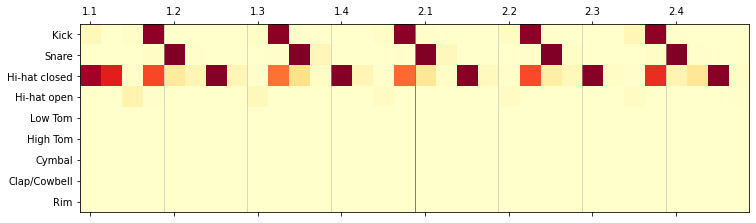

epoch: 309
m_d_loss: 0.21269463908672337     m_g_loss: 4.832540239606585


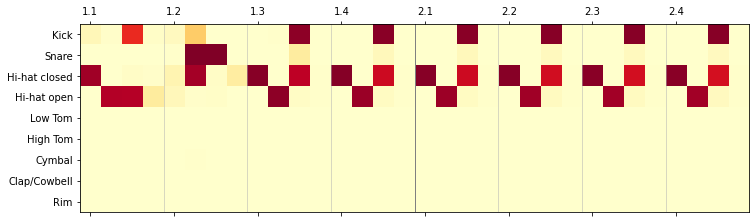

epoch: 310
m_d_loss: 0.19522840119898313     m_g_loss: 5.833108600305051


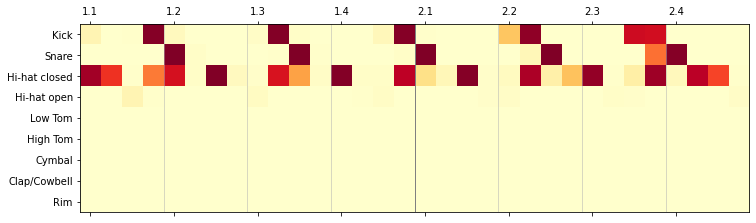

epoch: 311
m_d_loss: 0.18970889568328858     m_g_loss: 6.436386507384631


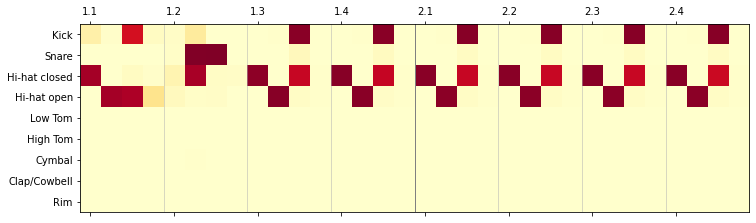

epoch: 312
m_d_loss: 0.19723377116024499     m_g_loss: 6.4133986648248165


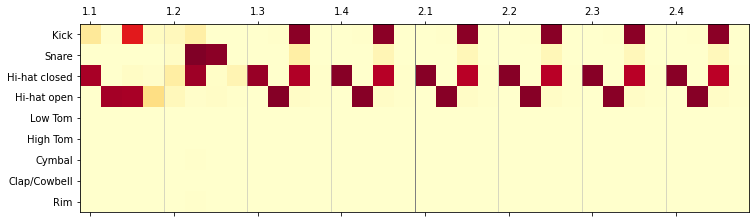

epoch: 313
m_d_loss: 0.18843542599678037     m_g_loss: 6.525598827673464


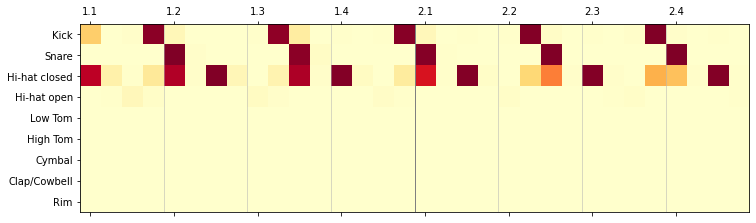

epoch: 314
m_d_loss: 0.19403749654690428     m_g_loss: 6.76063736117616


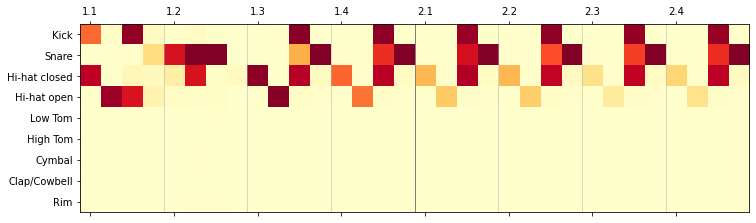

epoch: 315
m_d_loss: 0.21473606288433078     m_g_loss: 6.2169720396703605


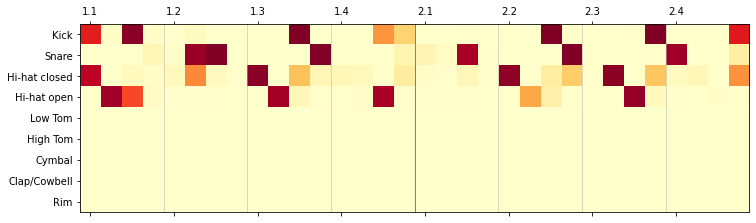

epoch: 316
m_d_loss: 0.21773313172161582     m_g_loss: 5.614569157970195


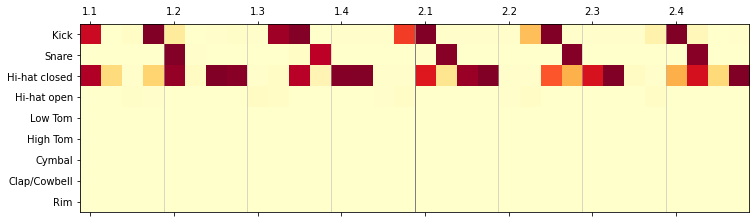

epoch: 317
m_d_loss: 0.2360263469219208     m_g_loss: 4.973760702172104


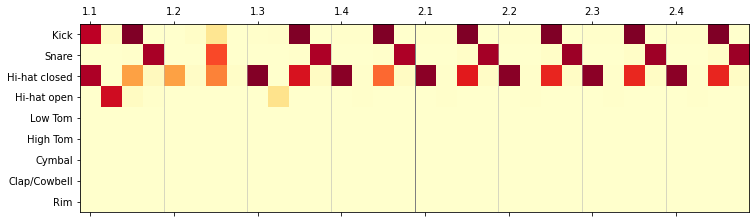

epoch: 318
m_d_loss: 0.1962607296804587     m_g_loss: 5.554376115604323


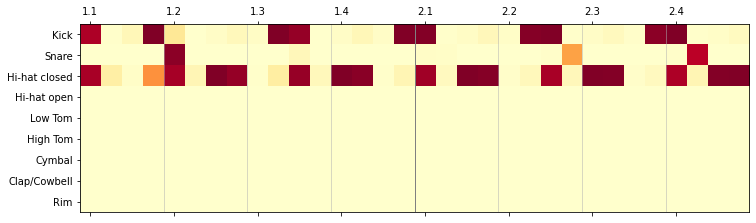

epoch: 319
m_d_loss: 0.18123379218578337     m_g_loss: 6.692302178363411


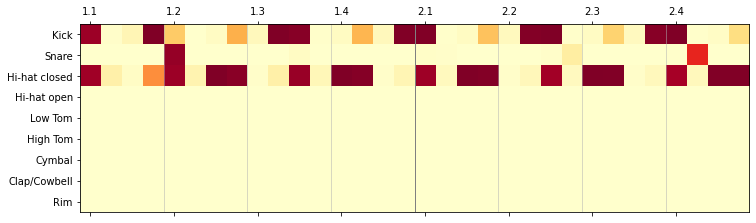

epoch: 320
m_d_loss: 0.20280146201451618     m_g_loss: 6.141455684389387


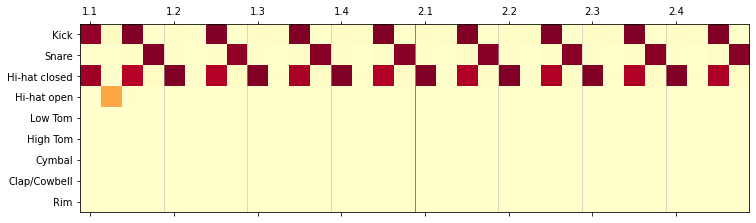

epoch: 321
m_d_loss: 0.1984569764137268     m_g_loss: 6.530157011382434


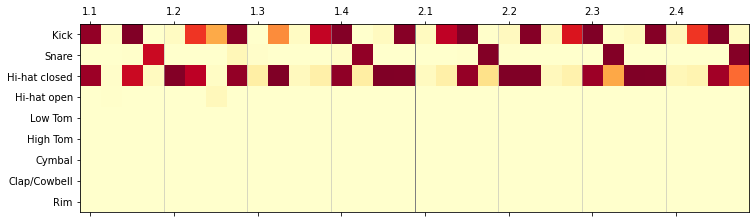

epoch: 322
m_d_loss: 0.19526006405552232     m_g_loss: 6.807452046141332


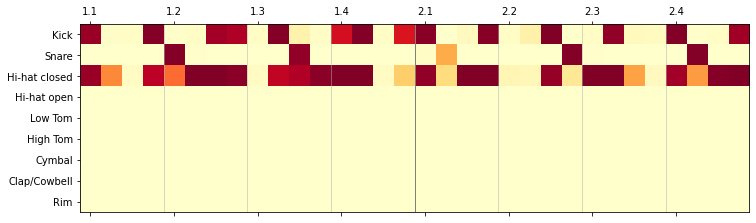

epoch: 323
m_d_loss: 0.17990643572807316     m_g_loss: 7.41310689887222


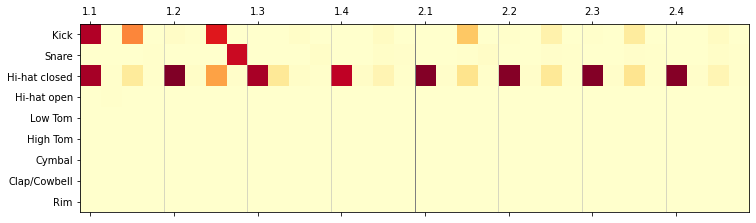

epoch: 324
m_d_loss: 0.21901520589987436     m_g_loss: 5.605281318937029


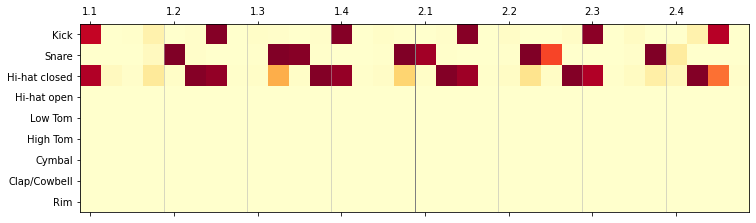

epoch: 325
m_d_loss: 0.21101379776000975     m_g_loss: 5.429280149693391


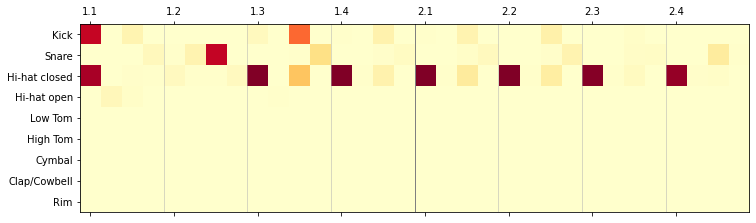

epoch: 326
m_d_loss: 0.19204165562987321     m_g_loss: 5.892707571691396


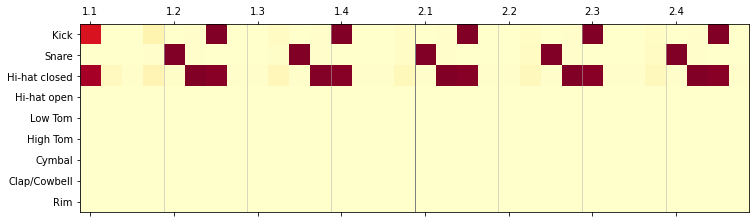

epoch: 327
m_d_loss: 0.19055672776699062     m_g_loss: 6.300205289101114


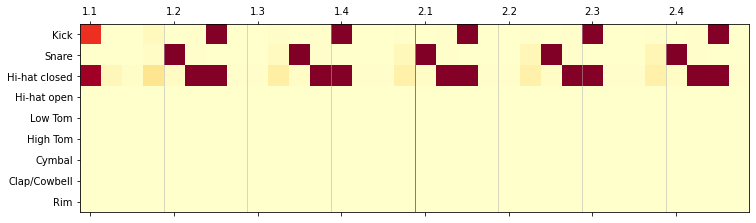

epoch: 328
m_d_loss: 0.19256823646525545     m_g_loss: 5.87234860050435


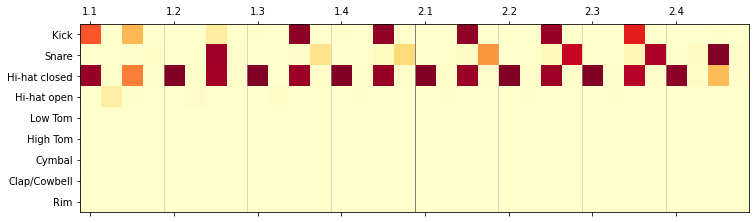

epoch: 329
m_d_loss: 0.18607215487957     m_g_loss: 6.165501078780816


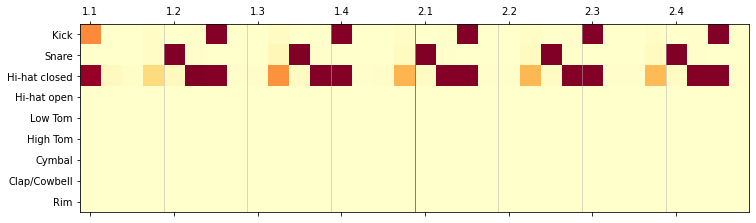

epoch: 330
m_d_loss: 0.19129426168898742     m_g_loss: 6.656982013157436


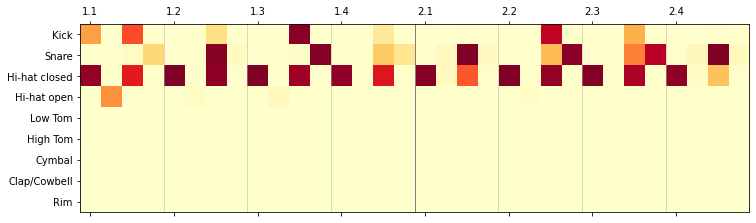

epoch: 331
m_d_loss: 0.18170236063003536     m_g_loss: 6.514575812281395


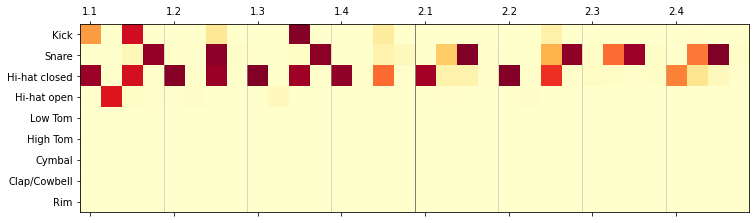

epoch: 332
m_d_loss: 0.17942159585654738     m_g_loss: 7.2038299112903825


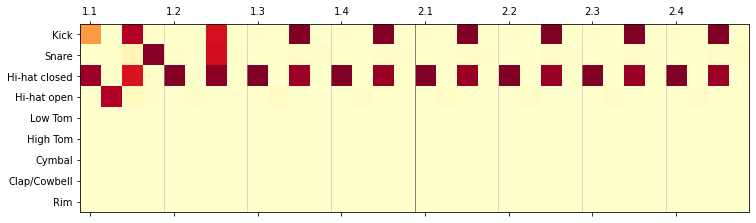

epoch: 333
m_d_loss: 0.16930833208560944     m_g_loss: 8.110331827280472


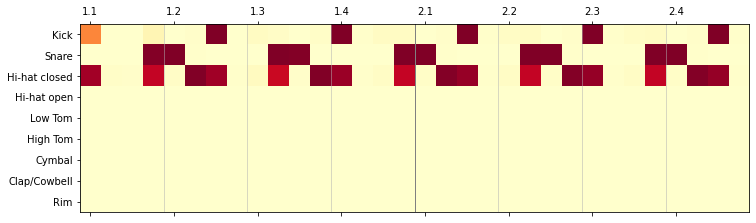

epoch: 334
m_d_loss: 0.22878555183609328     m_g_loss: 6.857817377362933


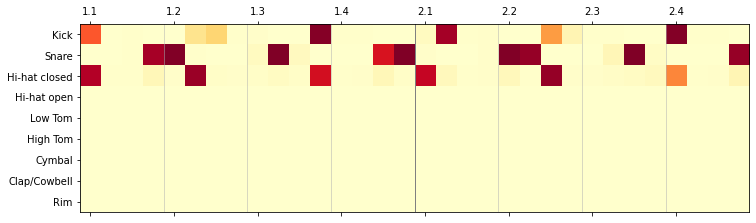

epoch: 335
m_d_loss: 0.18087974905967708     m_g_loss: 6.869557293093934


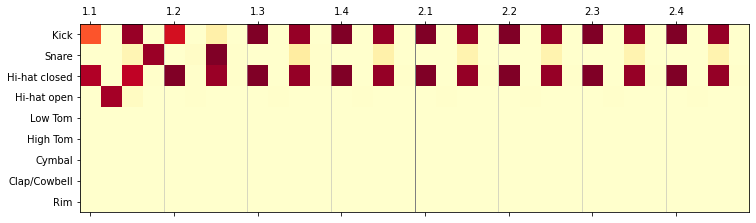

epoch: 336
m_d_loss: 0.20915901064872747     m_g_loss: 6.778982172206956


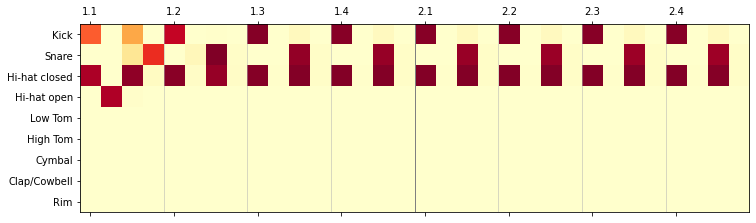

epoch: 337
m_d_loss: 0.22338203740119933     m_g_loss: 4.838491031101772


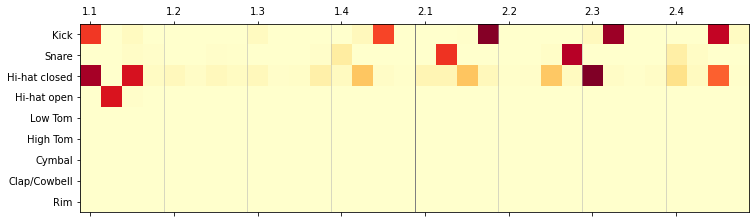

epoch: 338
m_d_loss: 0.19272273071110255     m_g_loss: 5.857836635745302


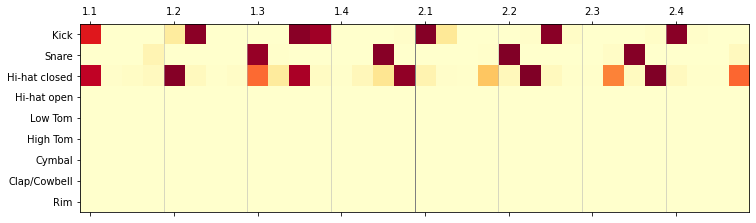

epoch: 339
m_d_loss: 0.19070773816108702     m_g_loss: 6.068008646673086


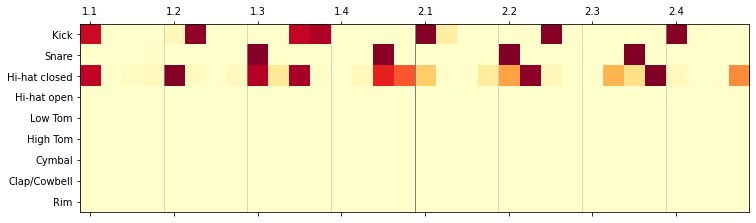

epoch: 340
m_d_loss: 0.174919796983401     m_g_loss: 6.873184213832933


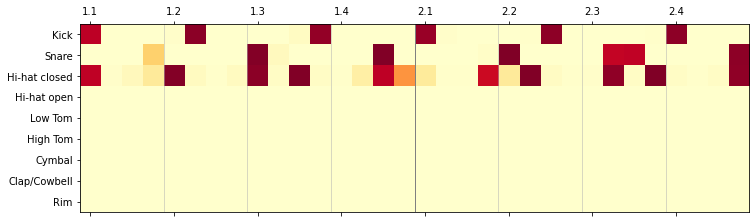

epoch: 341
m_d_loss: 0.19835244858264922     m_g_loss: 6.194722165866774


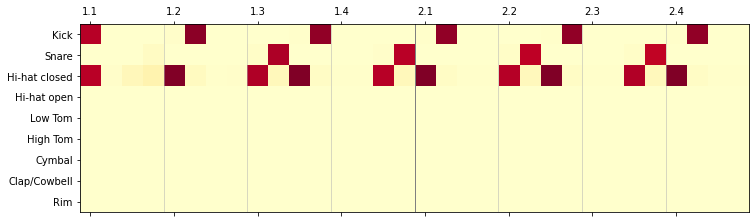

epoch: 342
m_d_loss: 0.18695991473893322     m_g_loss: 6.4738796292519085


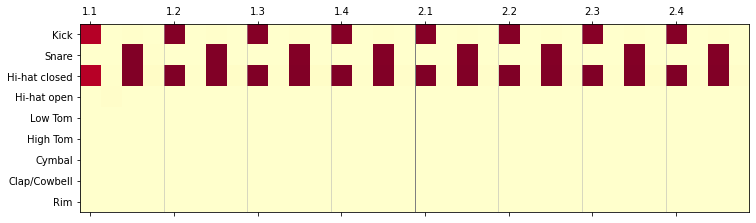

epoch: 343
m_d_loss: 0.17719148874282836     m_g_loss: 6.6729927744184225


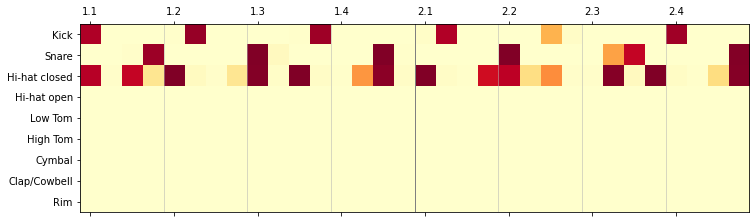

epoch: 344
m_d_loss: 0.1978529057155053     m_g_loss: 6.000178658232397


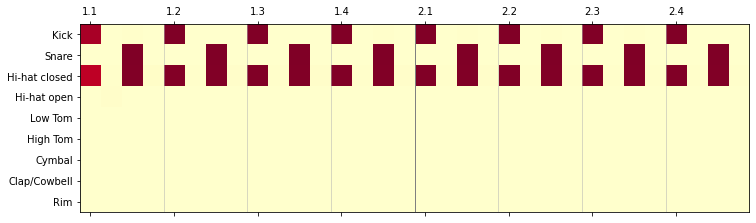

epoch: 345
m_d_loss: 0.19077232873439787     m_g_loss: 5.951009331917276


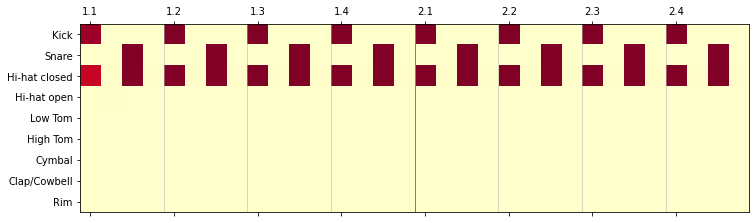

epoch: 346
m_d_loss: 0.17988380963603653     m_g_loss: 6.626288881107253


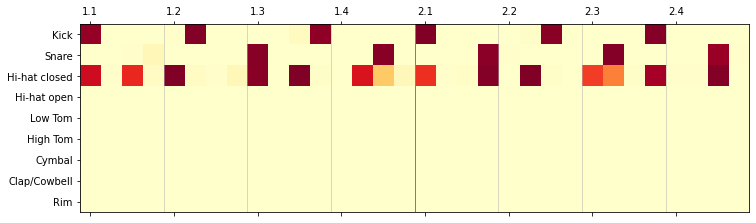

epoch: 347
m_d_loss: 0.1841487755775452     m_g_loss: 7.199688911437988


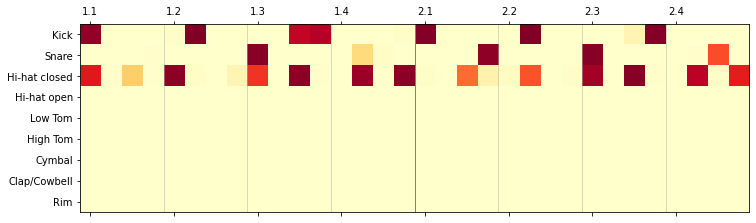

epoch: 348
m_d_loss: 0.1792713732769092     m_g_loss: 6.884513446262905


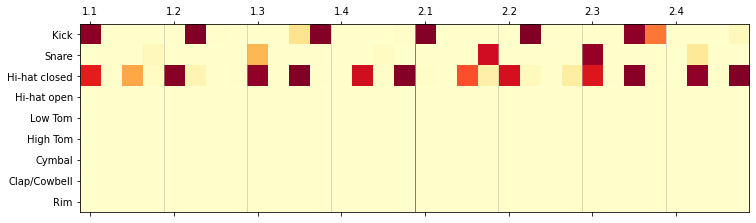

epoch: 349
m_d_loss: 0.1834460269212723     m_g_loss: 6.488997809740962


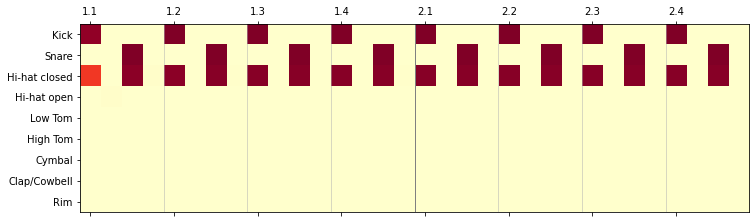

epoch: 350
m_d_loss: 0.18754191622138025     m_g_loss: 6.60827991913776


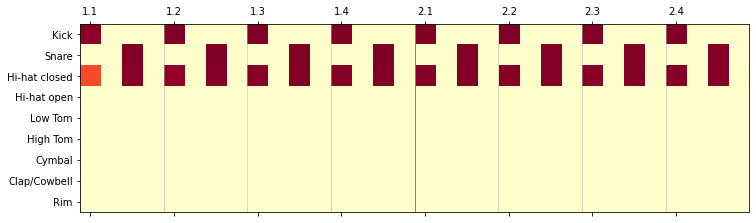

epoch: 351
m_d_loss: 0.1717086136341095     m_g_loss: 6.979490533167002


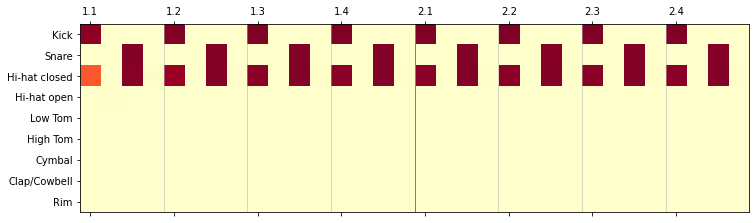

epoch: 352
m_d_loss: 0.18466721599300698     m_g_loss: 7.034080651341652


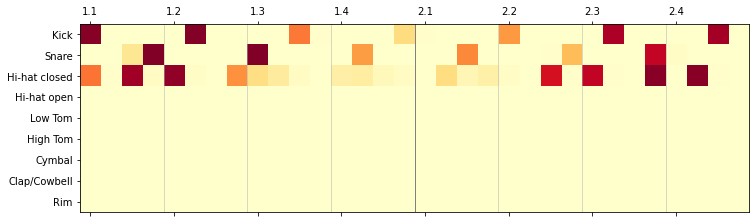

epoch: 353
m_d_loss: 0.18600352478027346     m_g_loss: 6.593008051113206


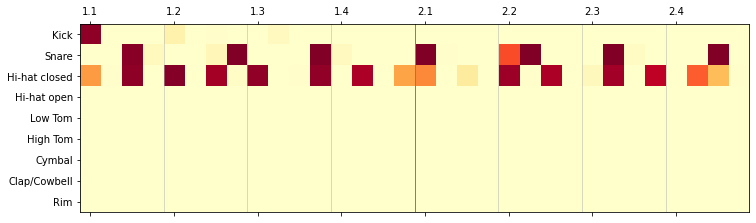

epoch: 354
m_d_loss: 0.17333385509749255     m_g_loss: 7.108228420724674


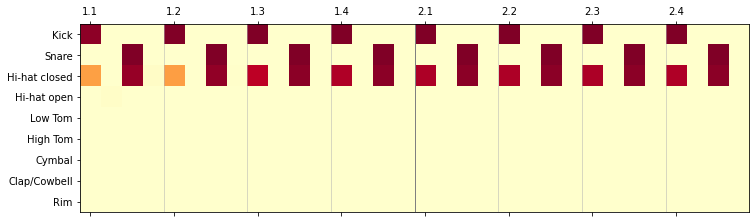

epoch: 355
m_d_loss: 0.16782350599765777     m_g_loss: 8.368446204127098


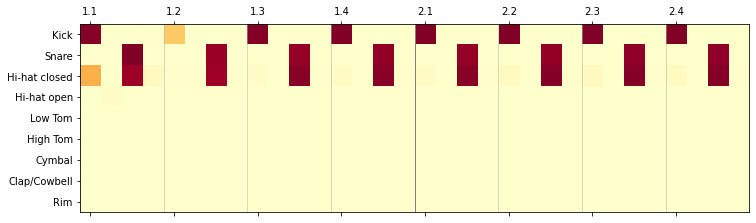

epoch: 356
m_d_loss: 0.2029594607651233     m_g_loss: 6.459697266014254


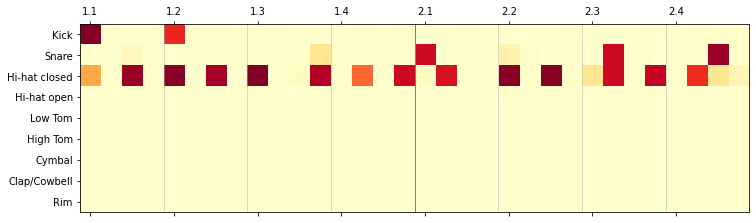

epoch: 357
m_d_loss: 0.203322124004364     m_g_loss: 6.13675459063783


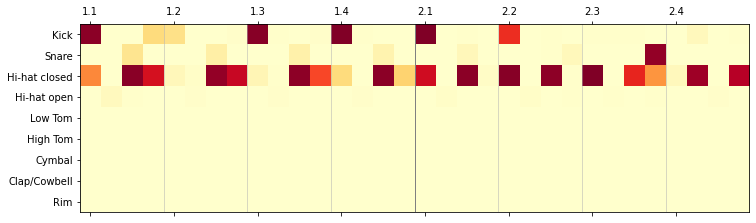

epoch: 358
m_d_loss: 0.19164025870462256     m_g_loss: 7.285470972255784


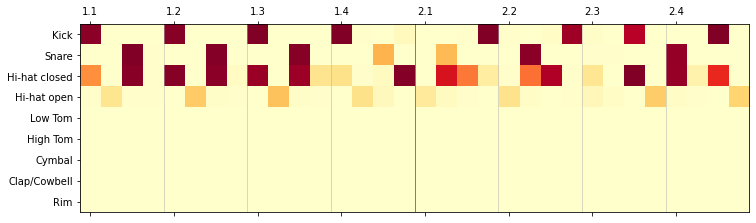

epoch: 359
m_d_loss: 0.23205679261684412     m_g_loss: 4.9172144860637435


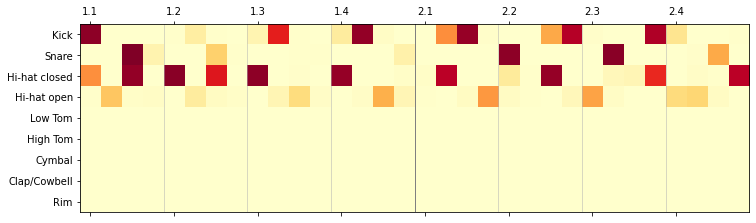

epoch: 360
m_d_loss: 0.2152379980931679     m_g_loss: 5.563251154763358


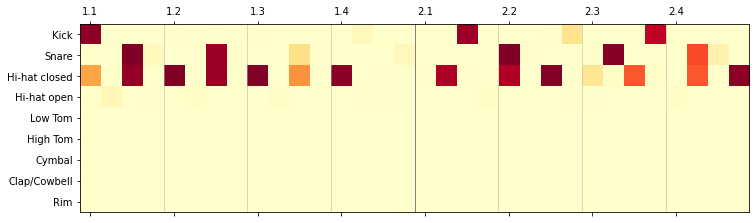

epoch: 361
m_d_loss: 0.17719858491420745     m_g_loss: 6.814382582294698


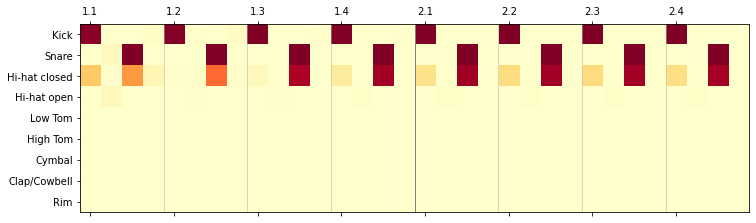

epoch: 362
m_d_loss: 0.1909109584987164     m_g_loss: 7.042260296490728


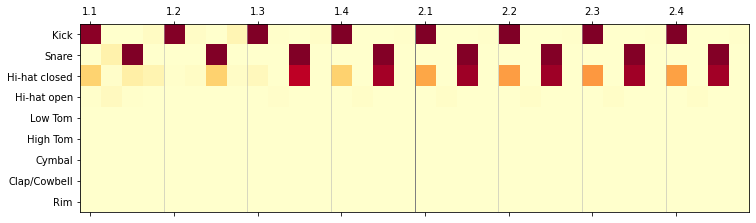

epoch: 363
m_d_loss: 0.1825116316080093     m_g_loss: 7.088583060673305


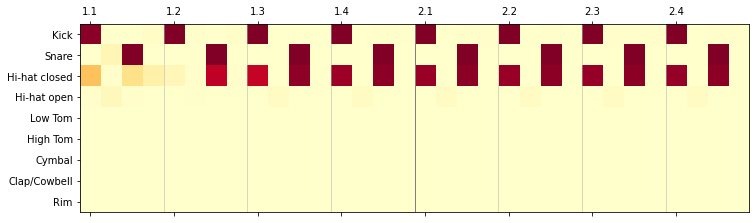

epoch: 364
m_d_loss: 0.1737561255693436     m_g_loss: 8.368299698343082


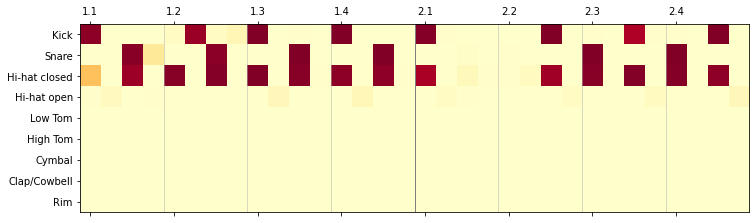

epoch: 365
m_d_loss: 0.19407979488372804     m_g_loss: 7.195744290643809


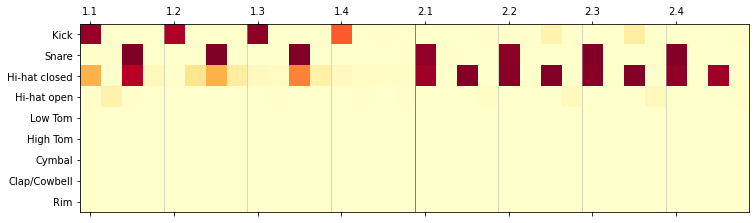

epoch: 366
m_d_loss: 0.17703441878159842     m_g_loss: 6.7799211813479054


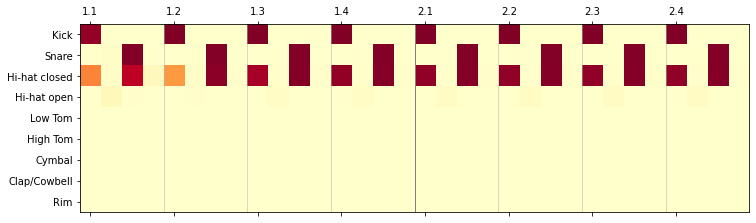

epoch: 367
m_d_loss: 0.18722549200057984     m_g_loss: 7.6105058825745875


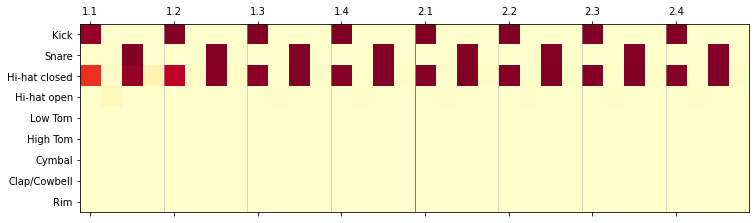

epoch: 368
m_d_loss: 0.1732970307270686     m_g_loss: 7.435473218256114


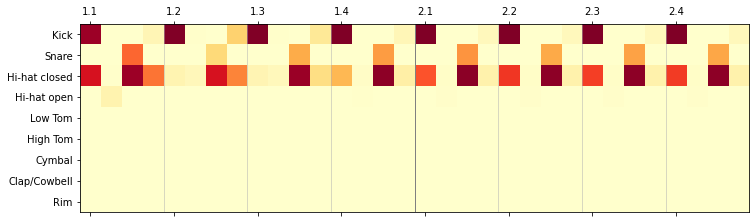

epoch: 369
m_d_loss: 0.19535814154148107     m_g_loss: 6.142792020525251


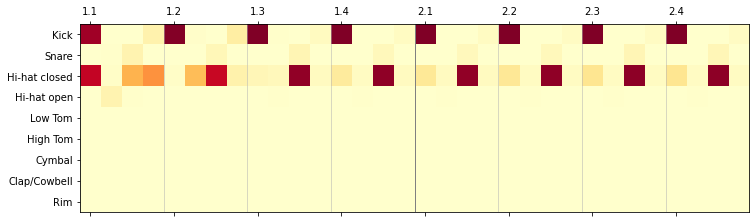

epoch: 370
m_d_loss: 0.19290339214106397     m_g_loss: 7.423657903865892


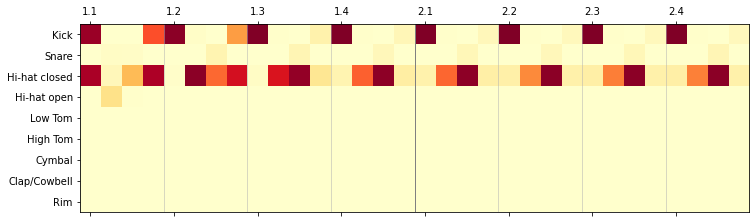

epoch: 371
m_d_loss: 0.20411067378520964     m_g_loss: 6.259352041750538


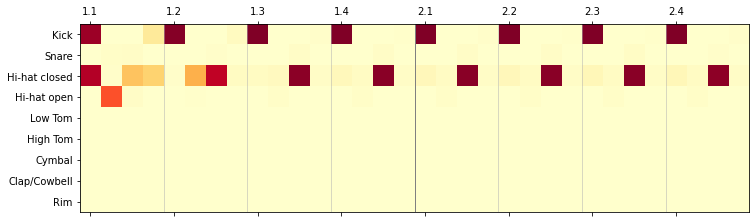

epoch: 372
m_d_loss: 0.1824185822159052     m_g_loss: 7.290129885381582


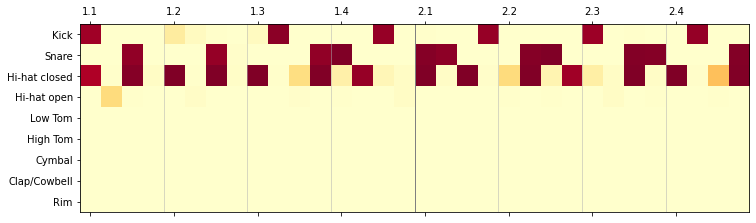

epoch: 373
m_d_loss: 0.17590608072280886     m_g_loss: 8.024604291332011


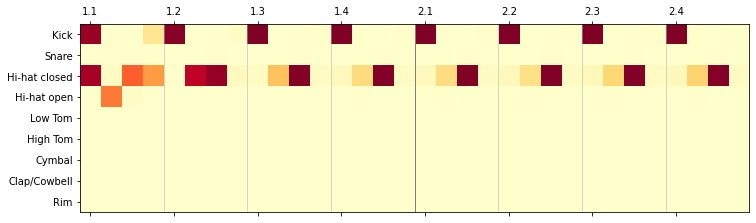

epoch: 374
m_d_loss: 0.17376336914797627     m_g_loss: 8.476853672338992


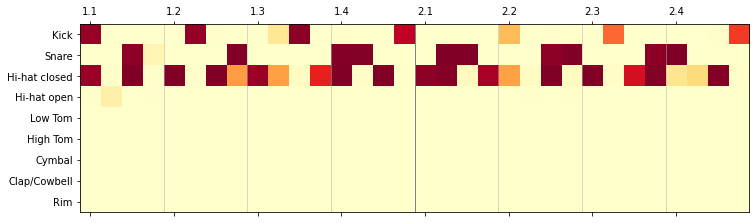

epoch: 375
m_d_loss: 0.2051516087055206     m_g_loss: 7.611204244652573


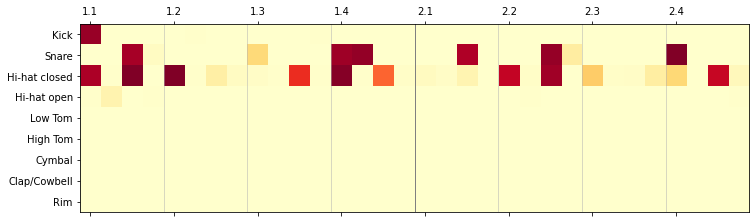

epoch: 376
m_d_loss: 0.17578642455240093     m_g_loss: 7.540596611645757


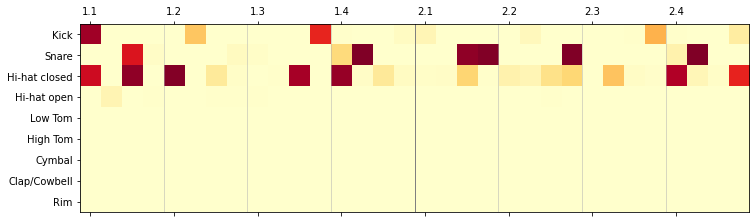

epoch: 377
m_d_loss: 0.1999279510974884     m_g_loss: 6.133972275013826


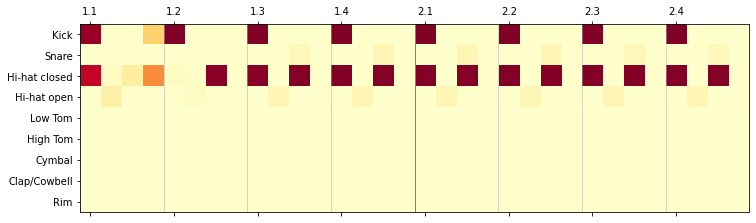

epoch: 378
m_d_loss: 0.1944086973865827     m_g_loss: 6.86156144434092


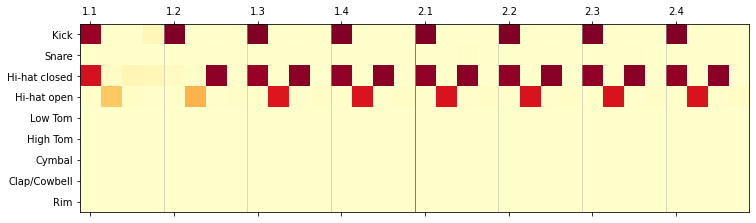

epoch: 379
m_d_loss: 0.19973333525657652     m_g_loss: 6.529967794612962


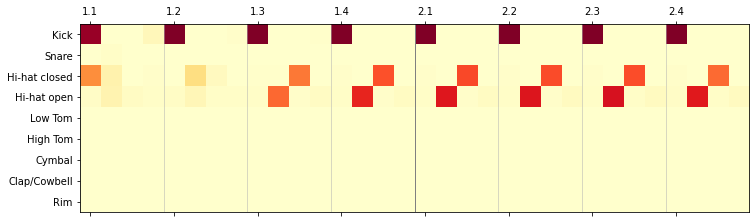

epoch: 380
m_d_loss: 0.21434142813086507     m_g_loss: 6.132784055203808


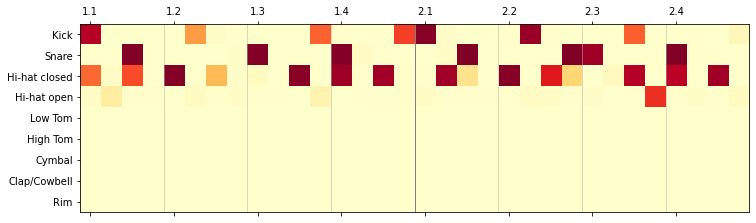

epoch: 381
m_d_loss: 0.21813549423217776     m_g_loss: 5.846607072012765


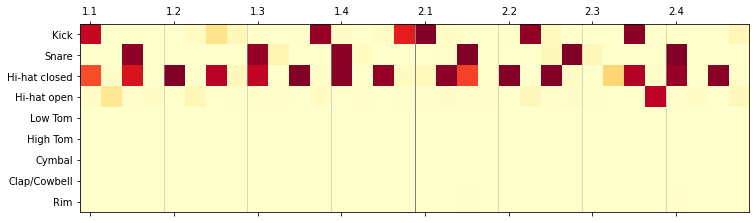

epoch: 382
m_d_loss: 0.19708869978785518     m_g_loss: 6.379331092445218


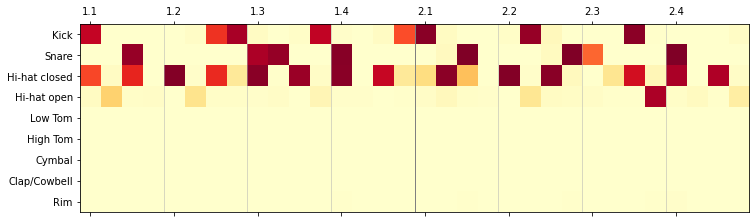

epoch: 383
m_d_loss: 0.20345281910896293     m_g_loss: 7.311446481821489


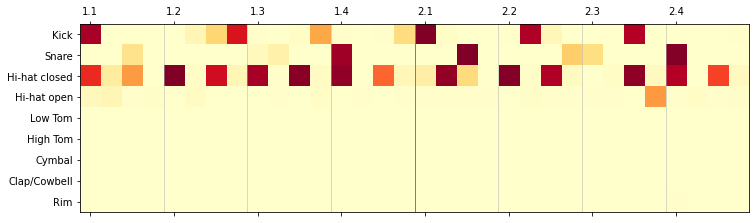

epoch: 384
m_d_loss: 0.21243279936412965     m_g_loss: 6.7759789252767755


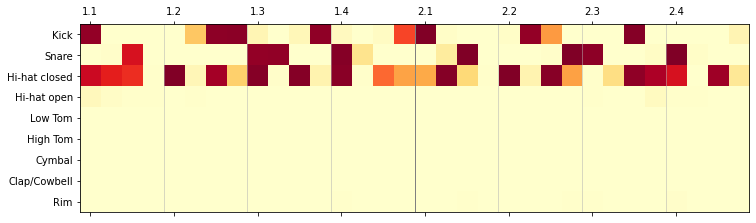

epoch: 385
m_d_loss: 0.21892235088348386     m_g_loss: 5.360346463261818


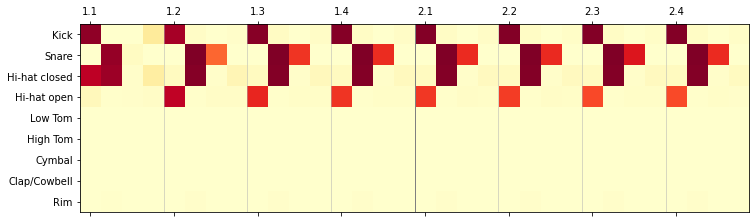

epoch: 386
m_d_loss: 0.17358839822312197     m_g_loss: 7.94616851028131


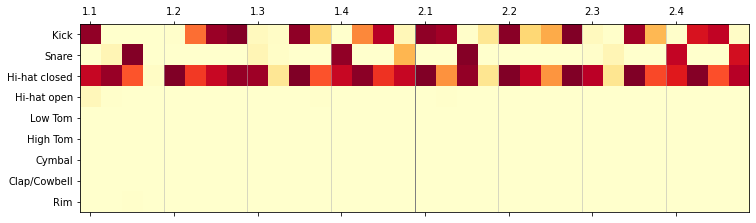

epoch: 387
m_d_loss: 0.22383363497257228     m_g_loss: 6.248021646421783


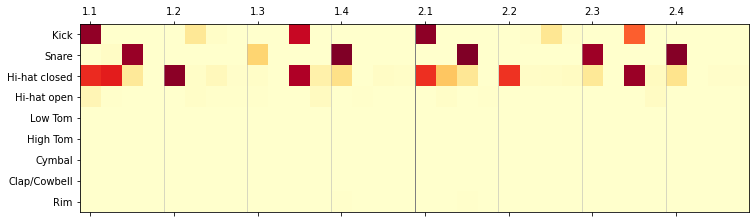

epoch: 388
m_d_loss: 0.20773220807313922     m_g_loss: 5.263968477443773


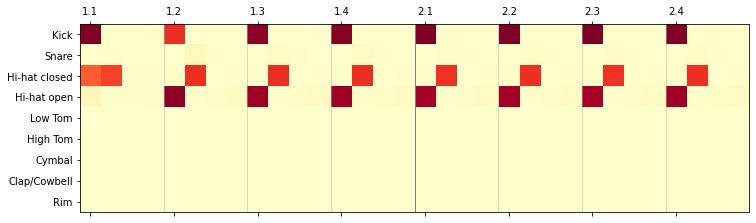

epoch: 389
m_d_loss: 0.19802395021915437     m_g_loss: 5.893417981206154


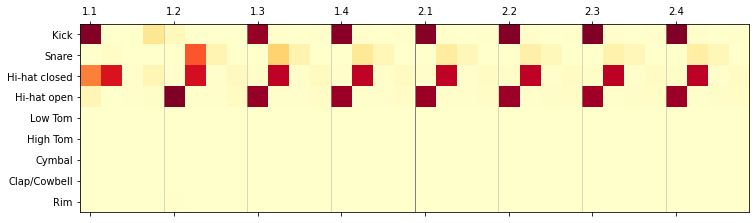

epoch: 390
m_d_loss: 0.18025567258397743     m_g_loss: 7.273412753124626


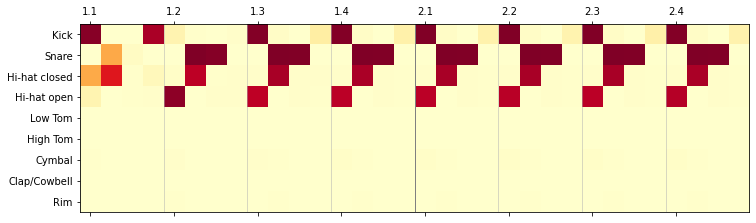

epoch: 391
m_d_loss: 0.20516313922405238     m_g_loss: 7.518402089878005


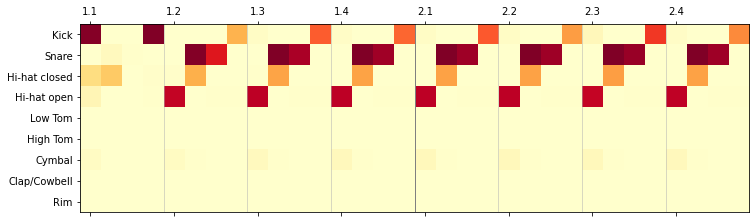

epoch: 392
m_d_loss: 0.2076781534900268     m_g_loss: 5.788783433486004


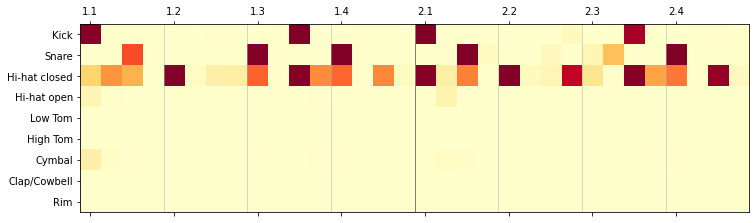

epoch: 393
m_d_loss: 0.1899464359283447     m_g_loss: 6.602392099341568


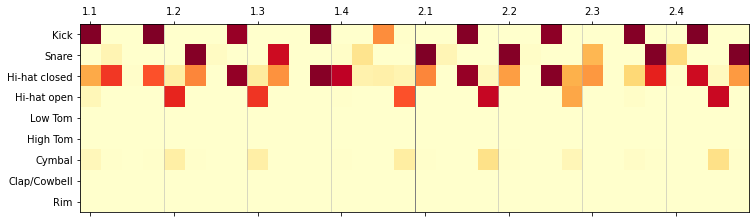

epoch: 394
m_d_loss: 0.1958463254074256     m_g_loss: 7.081588122309471


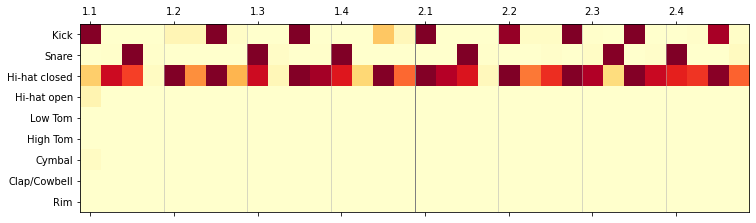

epoch: 395
m_d_loss: 0.20096377956867223     m_g_loss: 7.3722292063187576


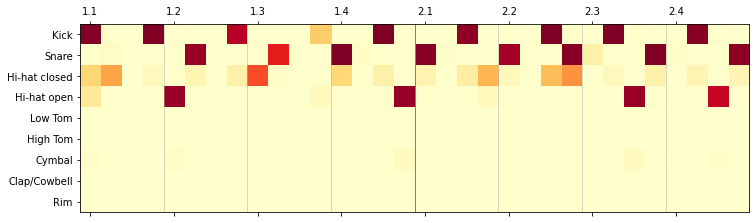

epoch: 396
m_d_loss: 0.23712242928644023     m_g_loss: 6.646739881865832


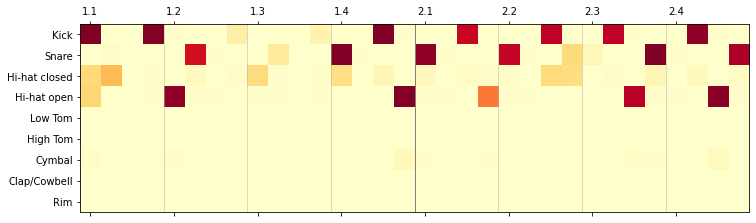

epoch: 397
m_d_loss: 0.21259957194328308     m_g_loss: 5.258955974968112


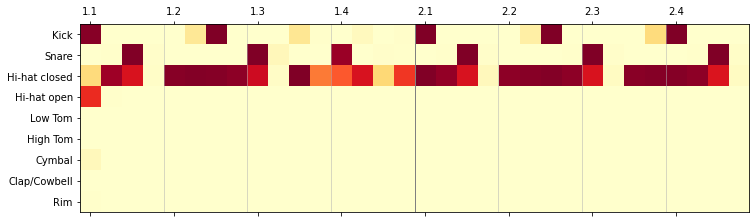

epoch: 398
m_d_loss: 0.1998902293543021     m_g_loss: 5.207002342963706


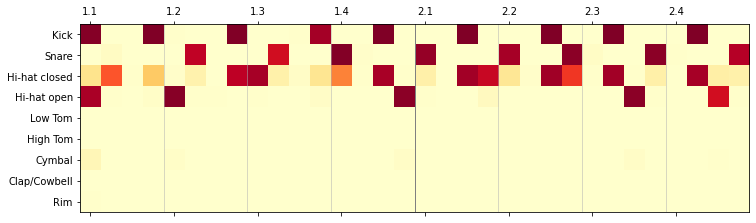

epoch: 399
m_d_loss: 0.17496569561958317     m_g_loss: 6.576004962531888


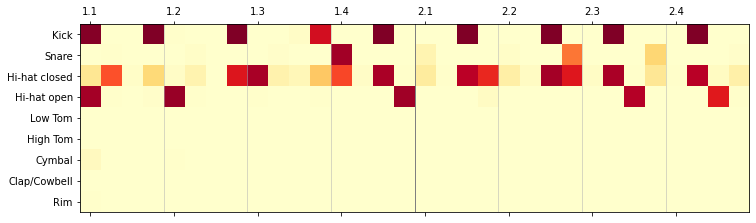

epoch: 400
m_d_loss: 0.18138700425624846     m_g_loss: 7.723730914446772


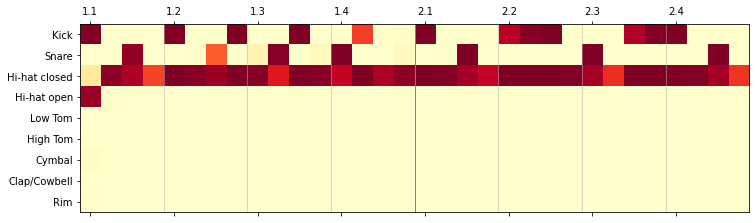

epoch: 401
m_d_loss: 0.1773832968473434     m_g_loss: 8.378824642726354


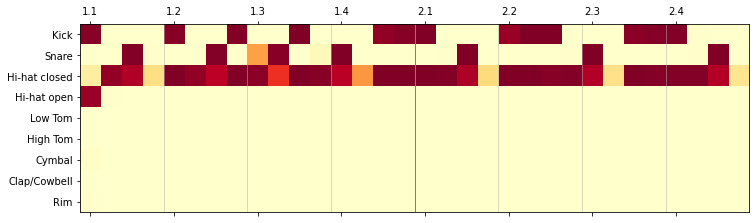

epoch: 402
m_d_loss: 0.19643305925031504     m_g_loss: 7.204008530597298


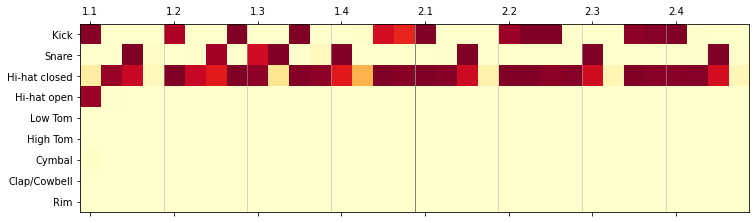

epoch: 403
m_d_loss: 0.17975193166732786     m_g_loss: 7.734916910833242


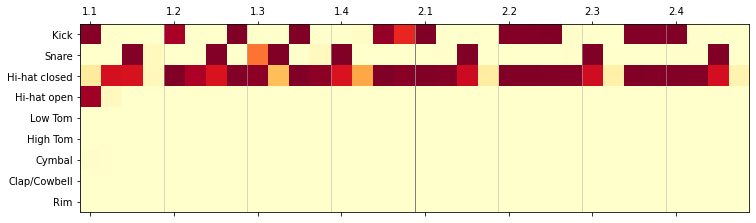

epoch: 404
m_d_loss: 0.18918907940387727     m_g_loss: 8.504367098516347


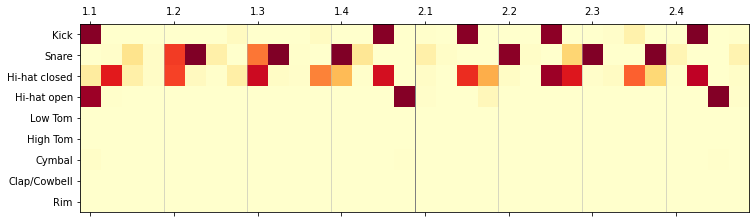

epoch: 405
m_d_loss: 0.19636195909976958     m_g_loss: 6.923970601996597


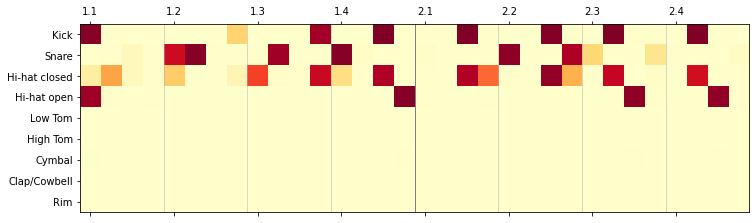

epoch: 406
m_d_loss: 0.1885202663640181     m_g_loss: 7.125477868683484


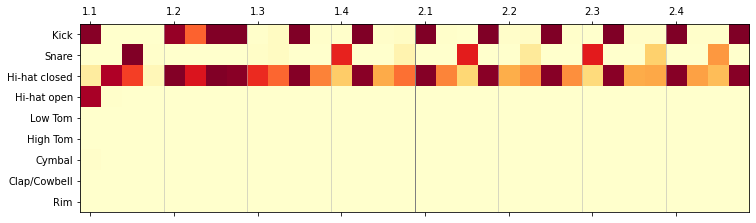

epoch: 407
m_d_loss: 0.19408553707599632     m_g_loss: 6.28235674877556


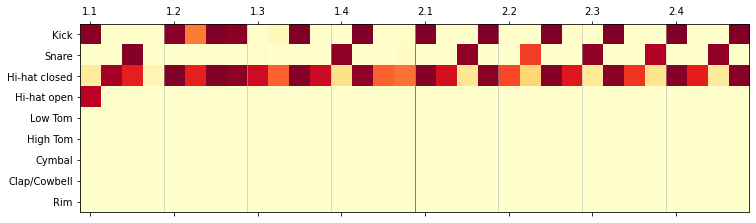

epoch: 408
m_d_loss: 0.17736891942719624     m_g_loss: 6.459500711791369


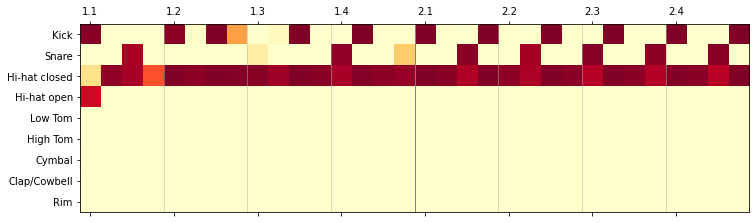

epoch: 409
m_d_loss: 0.17707869195938106     m_g_loss: 7.3359949150863955


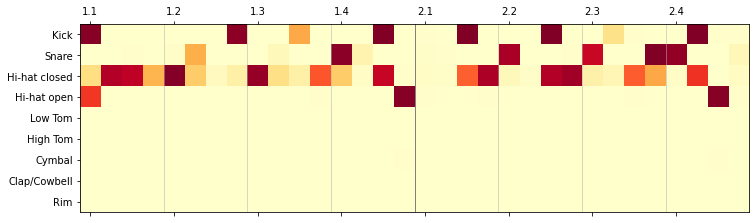

epoch: 410
m_d_loss: 0.2626710674415032     m_g_loss: 6.378443182731162


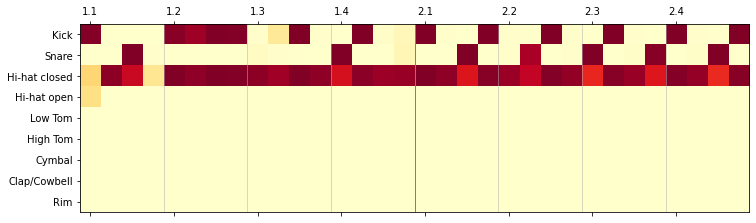

epoch: 411
m_d_loss: 0.24579107689857482     m_g_loss: 5.783778511748022


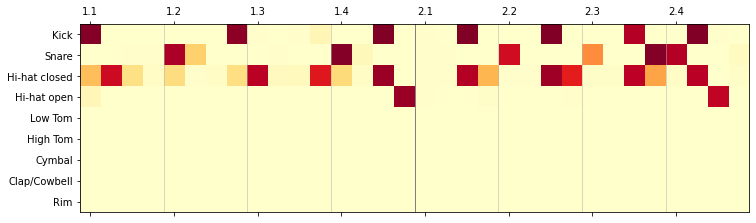

epoch: 412
m_d_loss: 0.20519183812042074     m_g_loss: 5.915219618349659


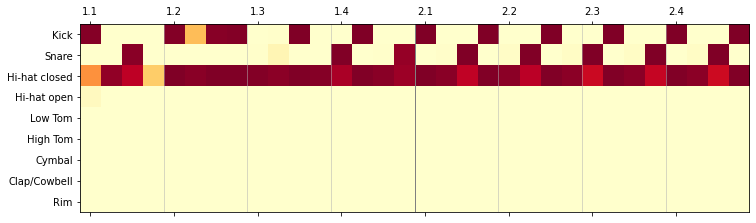

epoch: 413
m_d_loss: 0.2012834141254425     m_g_loss: 6.187873811137919


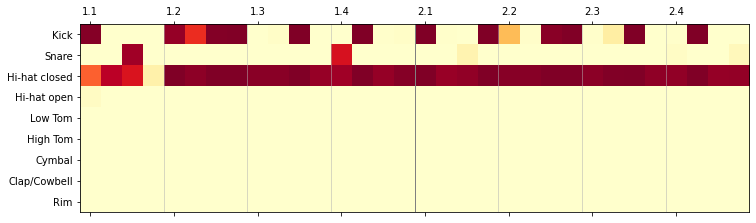

epoch: 414
m_d_loss: 0.19630271593729653     m_g_loss: 6.43791829323282


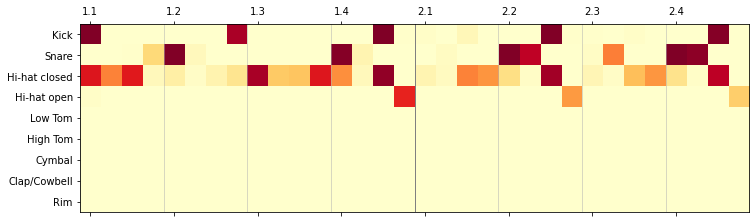

epoch: 415
m_d_loss: 0.20053052330017085     m_g_loss: 6.326852457863944


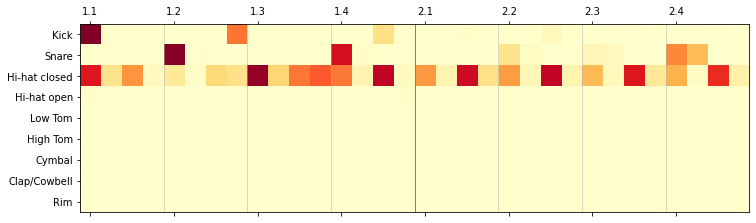

epoch: 416
m_d_loss: 0.20160355381667613     m_g_loss: 6.65045200075422


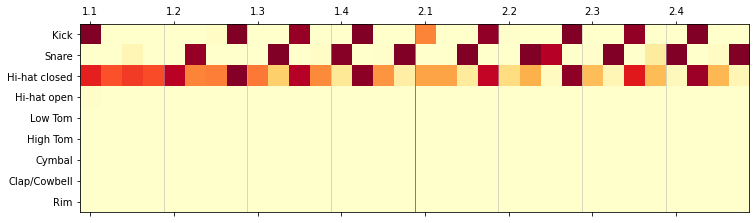

epoch: 417
m_d_loss: 0.20995447635650635     m_g_loss: 6.034868736656344


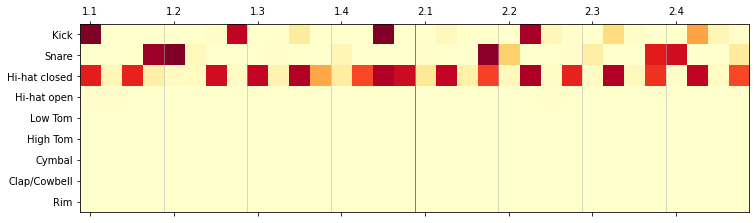

epoch: 418
m_d_loss: 0.21713895785311854     m_g_loss: 5.153267120828434


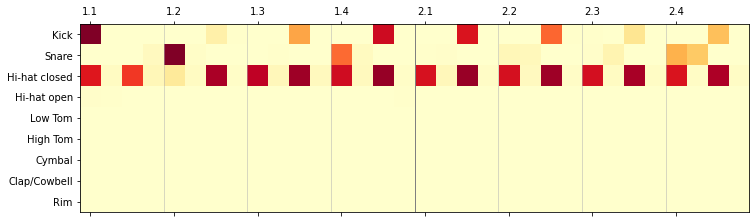

epoch: 419
m_d_loss: 0.21294565939903257     m_g_loss: 5.363335891645782


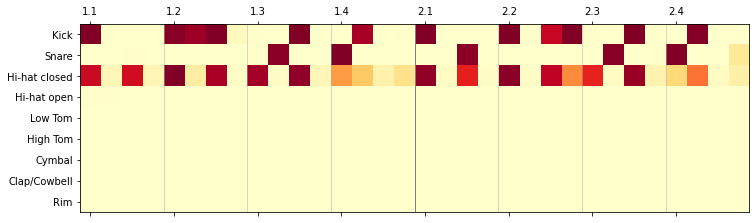

epoch: 420
m_d_loss: 0.221939039354523     m_g_loss: 5.3855191250236665


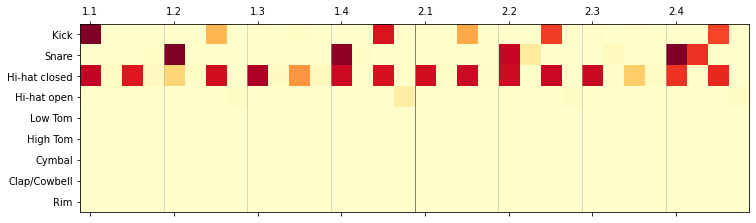

epoch: 421
m_d_loss: 0.19171816623210908     m_g_loss: 6.03447319536793


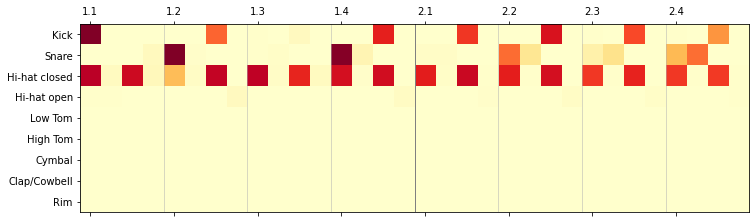

epoch: 422
m_d_loss: 0.2057048551738262     m_g_loss: 5.639382128812829


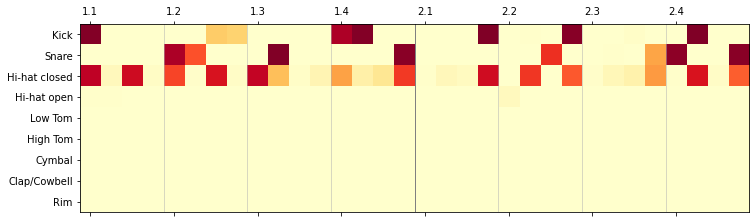

epoch: 423
m_d_loss: 0.24796829056739805     m_g_loss: 4.748135834324117


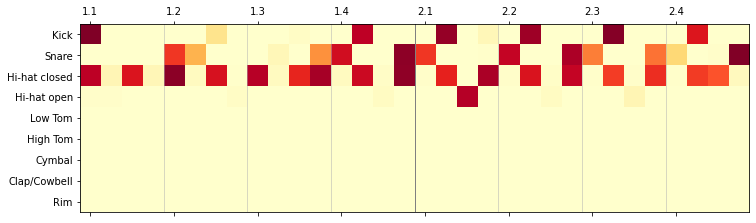

epoch: 424
m_d_loss: 0.22562132055560744     m_g_loss: 4.939459576898692


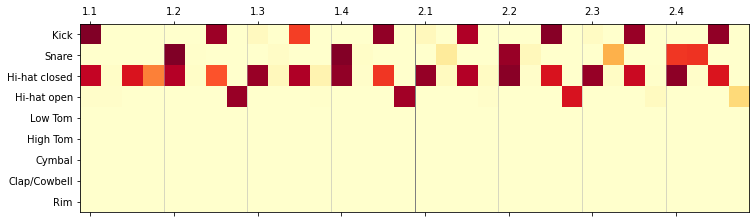

epoch: 425
m_d_loss: 0.2147148146629333     m_g_loss: 5.501628632448157


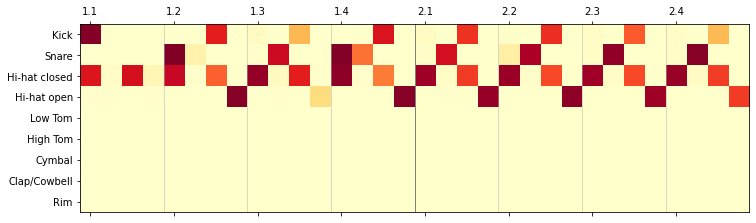

epoch: 426
m_d_loss: 0.2170813969026009     m_g_loss: 5.449078112232442


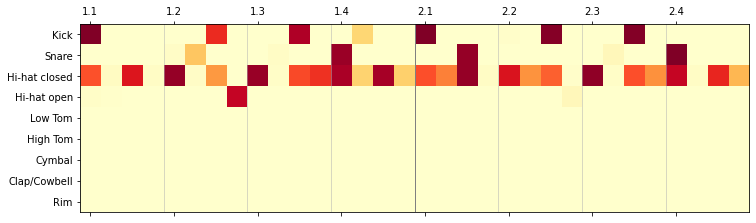

epoch: 427
m_d_loss: 0.22411322379112245     m_g_loss: 4.900891819778754


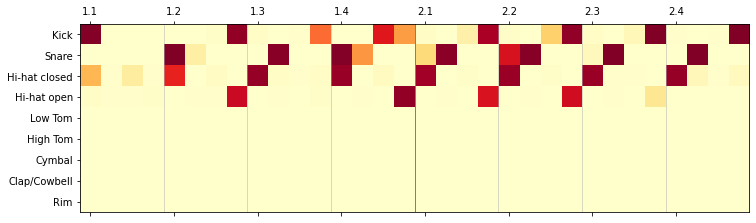

epoch: 428
m_d_loss: 0.2190002684791883     m_g_loss: 5.612808986585968


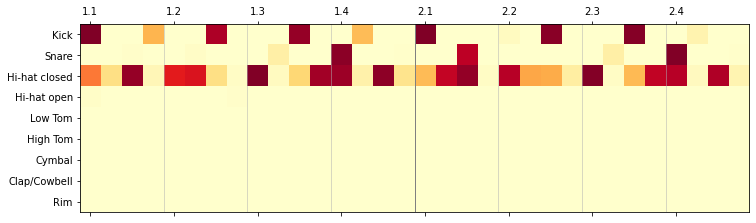

epoch: 429
m_d_loss: 0.20660099720954897     m_g_loss: 5.764824901308332


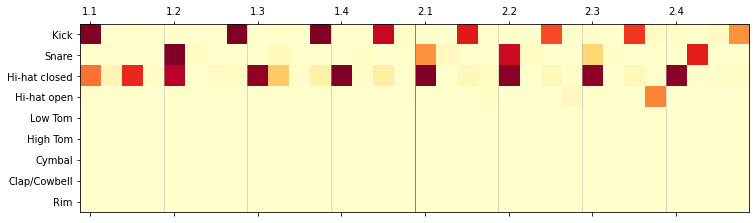

epoch: 430
m_d_loss: 0.2247579970707496     m_g_loss: 5.855568467354288


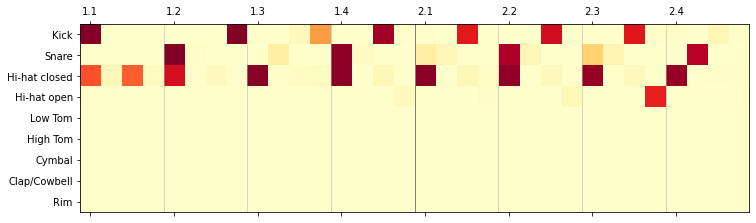

epoch: 431
m_d_loss: 0.20665485751628876     m_g_loss: 6.490101707224944


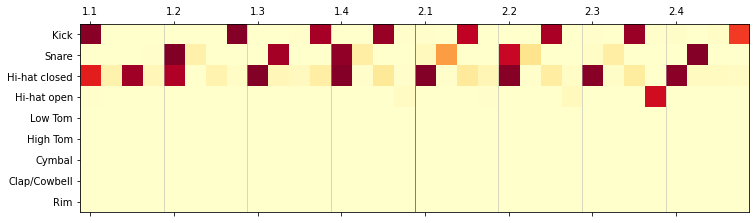

epoch: 432
m_d_loss: 0.19971172685424485     m_g_loss: 6.6460457529340475


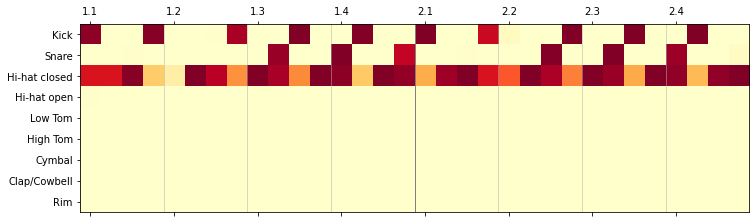

epoch: 433
m_d_loss: 0.21900631213188174     m_g_loss: 5.612973154807578


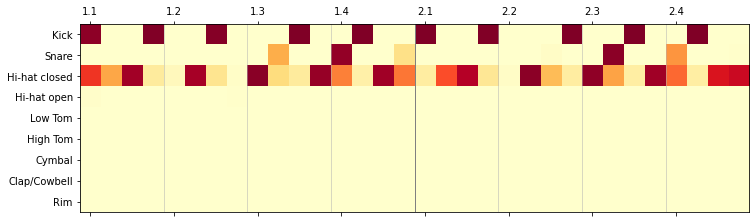

epoch: 434
m_d_loss: 0.22483980270723503     m_g_loss: 4.886986927110321


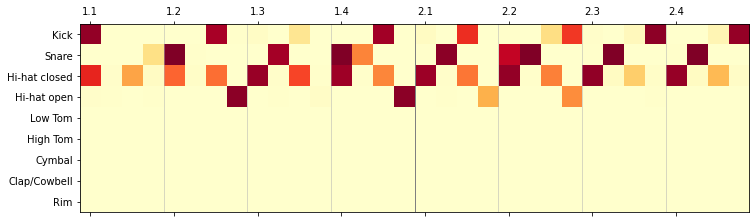

epoch: 435
m_d_loss: 0.2039948890209198     m_g_loss: 5.553405576822709


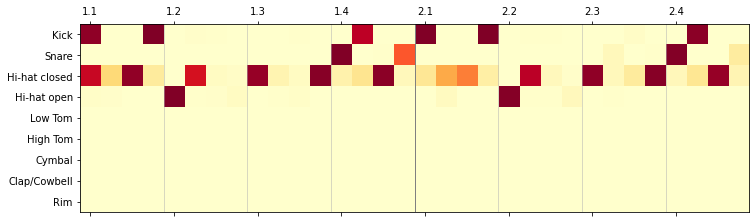

epoch: 436
m_d_loss: 0.1972806878387928     m_g_loss: 6.388805058537697


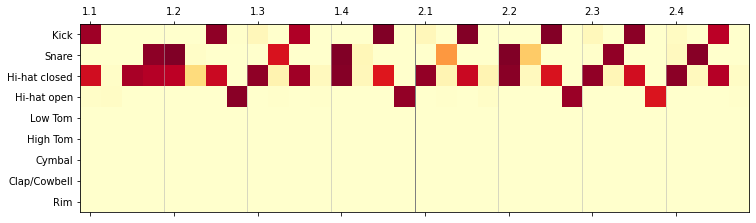

epoch: 437
m_d_loss: 0.193777245759964     m_g_loss: 6.606882757070113


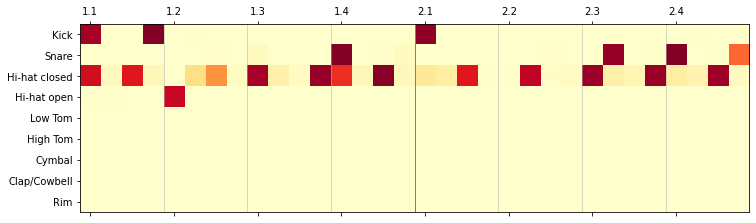

epoch: 438
m_d_loss: 0.20834910832345485     m_g_loss: 6.570297182822714


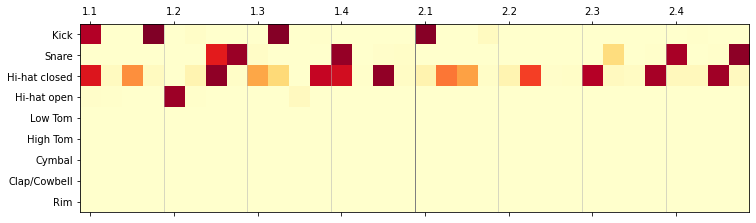

epoch: 439
m_d_loss: 0.19697614634037017     m_g_loss: 6.470576013837542


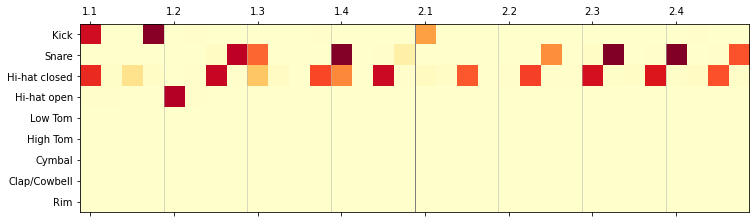

epoch: 440
m_d_loss: 0.196814190223813     m_g_loss: 6.694988834614656


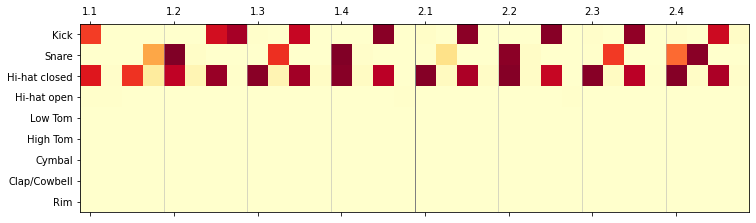

epoch: 441
m_d_loss: 0.20649710965156562     m_g_loss: 6.047095668559172


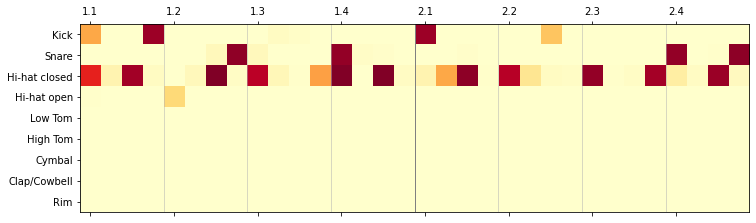

epoch: 442
m_d_loss: 0.19056771571437517     m_g_loss: 6.758995610840467


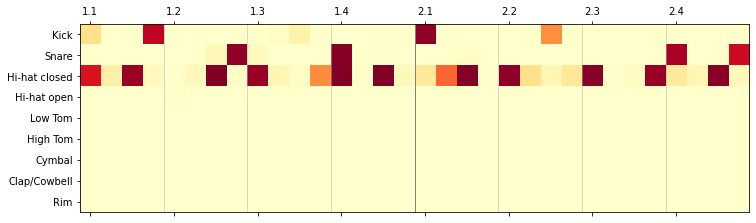

epoch: 443
m_d_loss: 0.1830799509286881     m_g_loss: 7.698748209038559


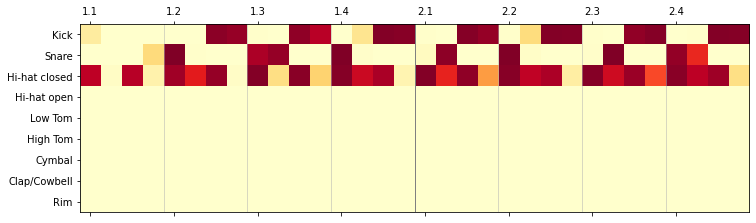

epoch: 444
m_d_loss: 0.1795852031558752     m_g_loss: 7.721488689889713


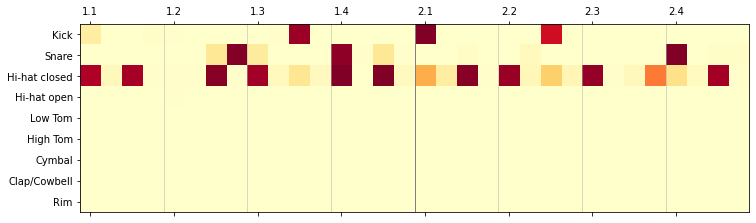

epoch: 445
m_d_loss: 0.17971986877918242     m_g_loss: 8.399483174693827


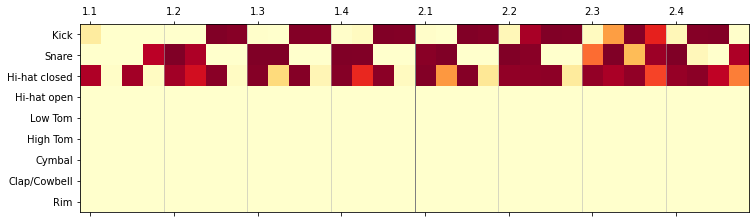

epoch: 446
m_d_loss: 0.18385345426698527     m_g_loss: 7.061748251623037


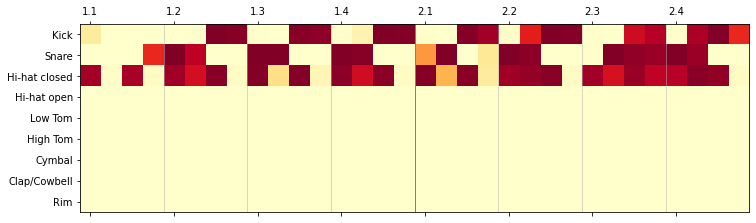

epoch: 447
m_d_loss: 0.2012034853696823     m_g_loss: 7.058964349785629


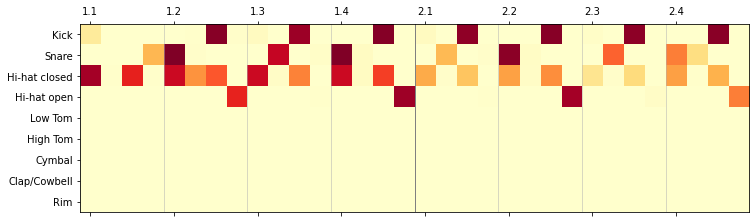

epoch: 448
m_d_loss: 0.17796300003925958     m_g_loss: 6.619460718972342


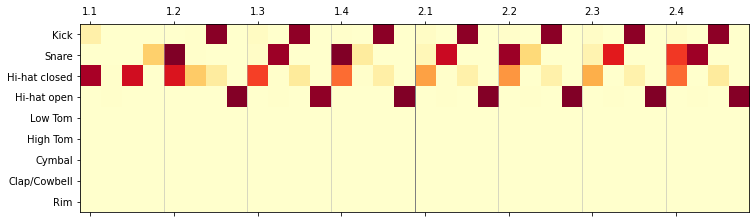

epoch: 449
m_d_loss: 0.17448204398155212     m_g_loss: 8.507177888130656


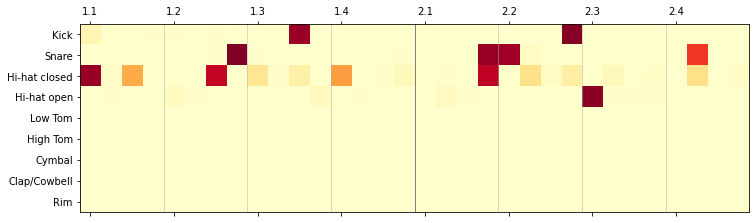

epoch: 450
m_d_loss: 0.18030259720981123     m_g_loss: 8.70285974230085


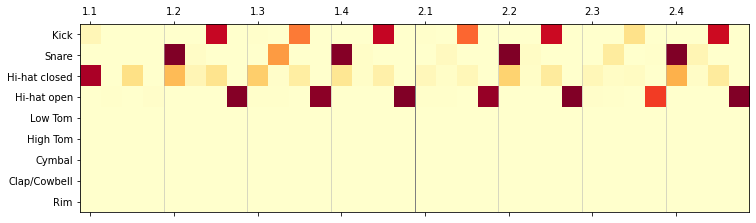

epoch: 451
m_d_loss: 0.19402983117103578     m_g_loss: 7.369422717970245


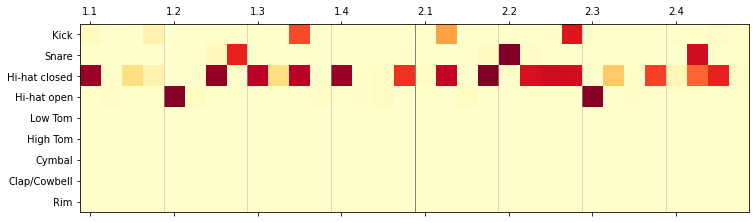

epoch: 452
m_d_loss: 0.1800602198888858     m_g_loss: 8.349518688357605


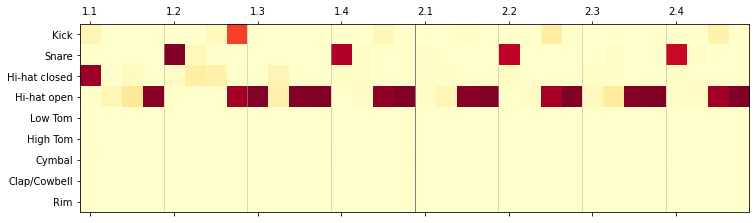

epoch: 453
m_d_loss: 0.17900456631183626     m_g_loss: 9.233540398733956


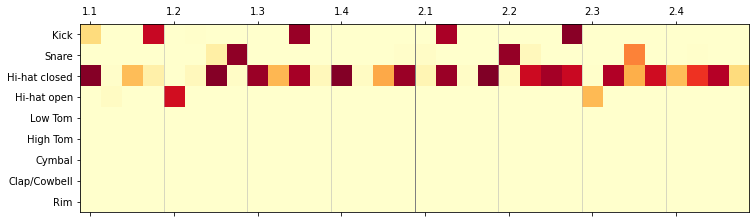

epoch: 454
m_d_loss: 0.20652198654909926     m_g_loss: 7.023009524053457


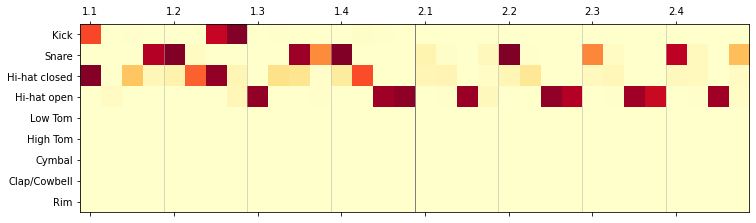

epoch: 455
m_d_loss: 0.1827961221933365     m_g_loss: 6.9966570503857675


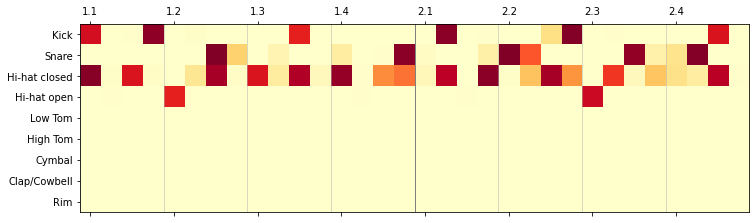

epoch: 456
m_d_loss: 0.20331230685114857     m_g_loss: 6.88417691600566


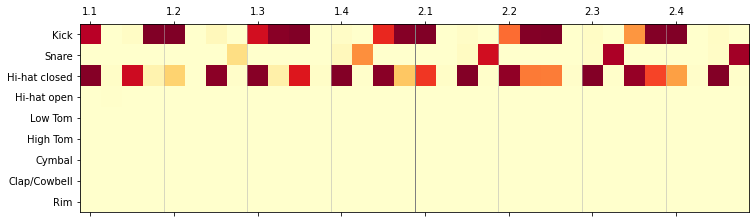

epoch: 457
m_d_loss: 0.19061895942687987     m_g_loss: 6.593406993515638


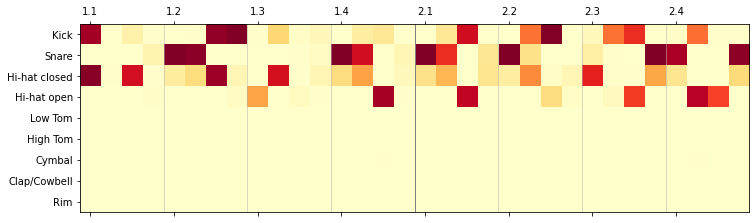

epoch: 458
m_d_loss: 0.1889611604313056     m_g_loss: 7.251119876394466


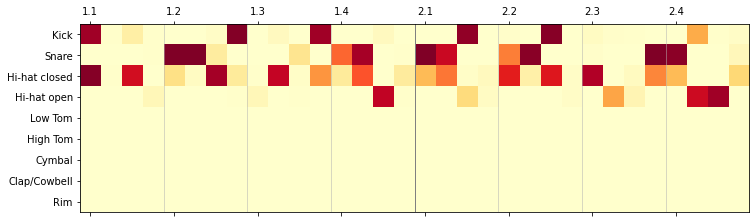

epoch: 459
m_d_loss: 0.19928623652458188     m_g_loss: 6.806830240755665


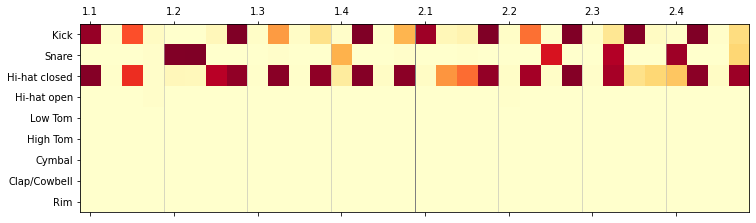

epoch: 460
m_d_loss: 0.1886651328454415     m_g_loss: 6.8346666705851655


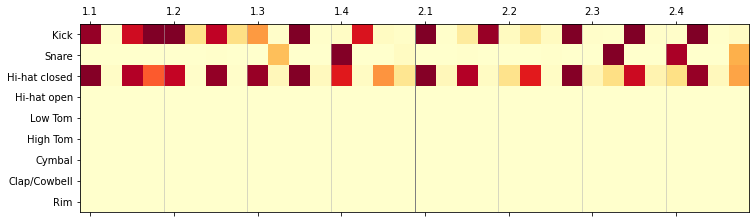

epoch: 461
m_d_loss: 0.1850401272773743     m_g_loss: 6.750232268352898


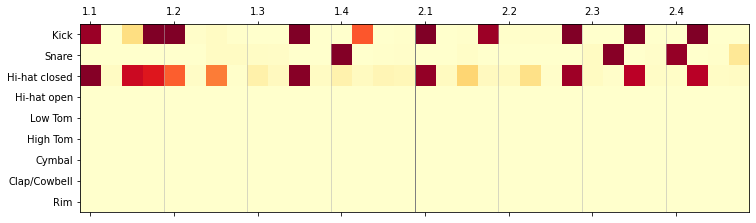

epoch: 462
m_d_loss: 0.19062456985314682     m_g_loss: 6.52751365973025


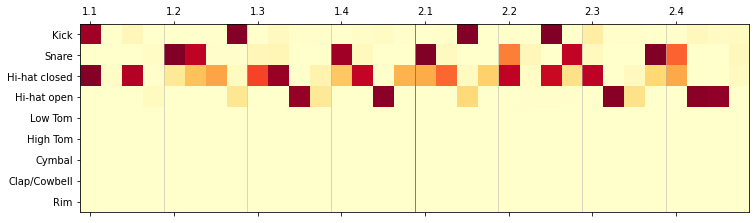

epoch: 463
m_d_loss: 0.20006494557857513     m_g_loss: 6.820277564379634


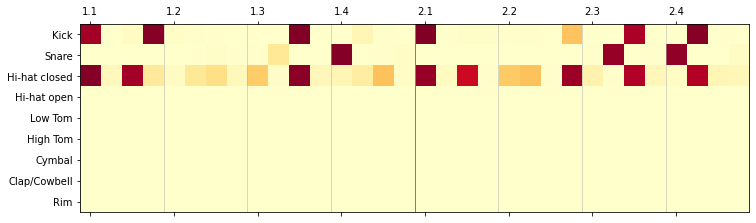

epoch: 464
m_d_loss: 0.1977046777804692     m_g_loss: 6.2229028721244966


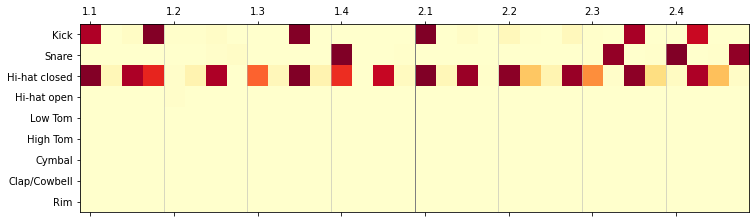

epoch: 465
m_d_loss: 0.23181931591033936     m_g_loss: 5.228238329595449


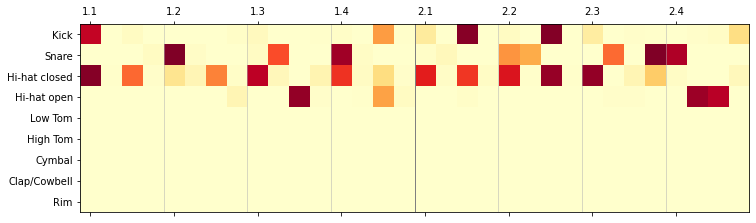

epoch: 466
m_d_loss: 0.2148715157061815     m_g_loss: 5.480736761677022


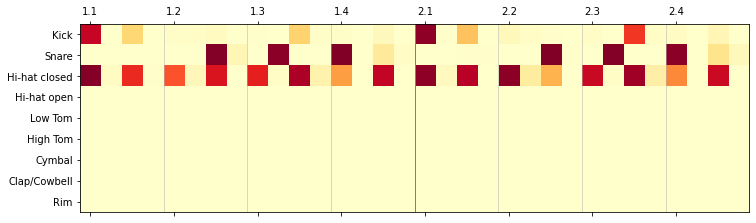

epoch: 467
m_d_loss: 0.24193922853469843     m_g_loss: 5.548293833829919


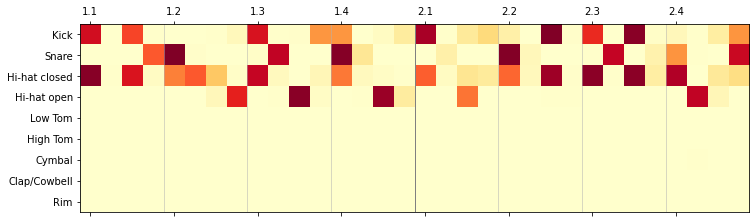

epoch: 468
m_d_loss: 0.2581402347733576     m_g_loss: 4.65110733071152


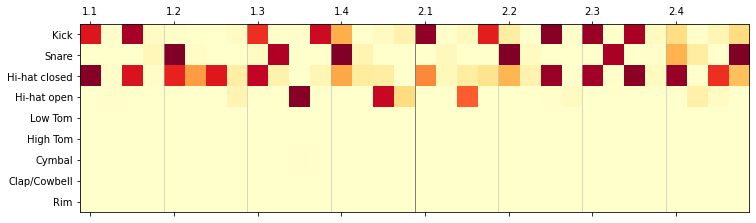

epoch: 469
m_d_loss: 0.2376908936500549     m_g_loss: 5.162903240748814


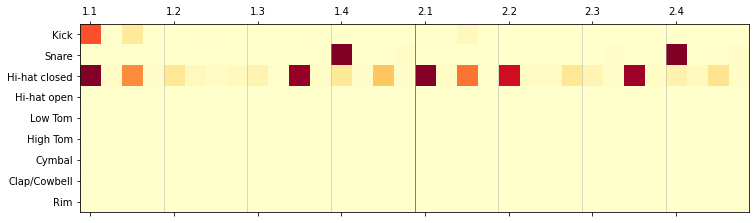

epoch: 470
m_d_loss: 0.2632730503877004     m_g_loss: 4.482179894739268


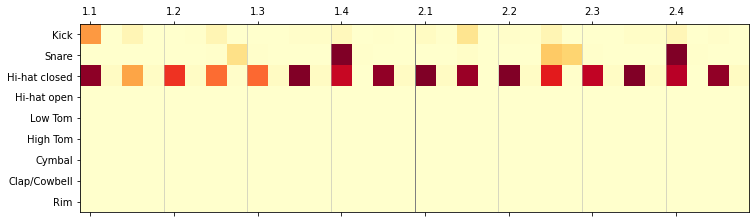

epoch: 471
m_d_loss: 0.23589260435104364     m_g_loss: 5.110547459855372


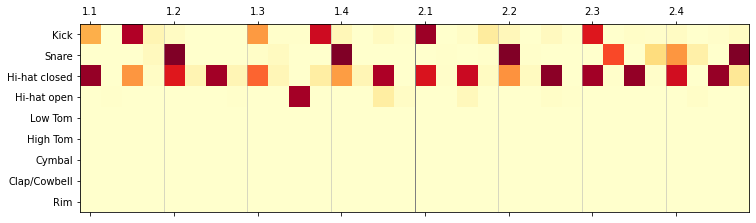

epoch: 472
m_d_loss: 0.20711316602925464     m_g_loss: 6.226643241181666


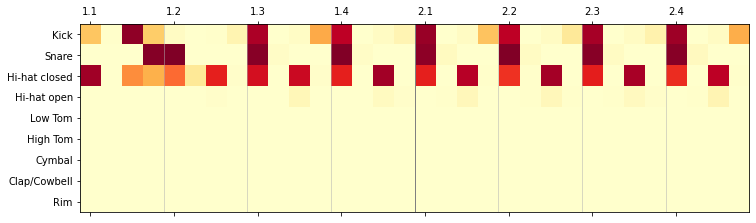

epoch: 473
m_d_loss: 0.2285125172138214     m_g_loss: 5.458795450171646


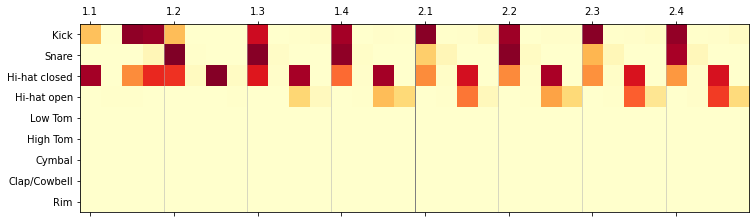

epoch: 474
m_d_loss: 0.2133902442951997     m_g_loss: 5.554348089257065


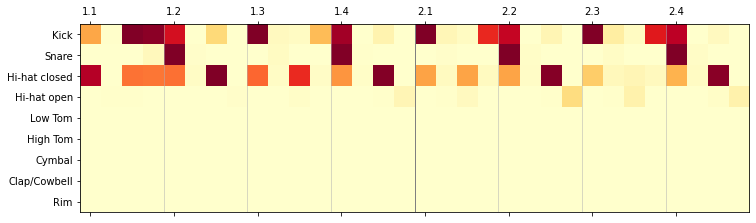

epoch: 475
m_d_loss: 0.22732756686210628     m_g_loss: 5.935390618382668


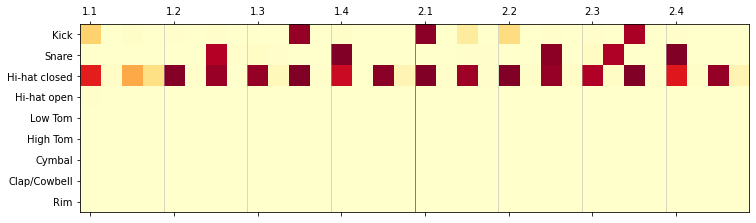

epoch: 476
m_d_loss: 0.22764626058439416     m_g_loss: 5.46216479126288


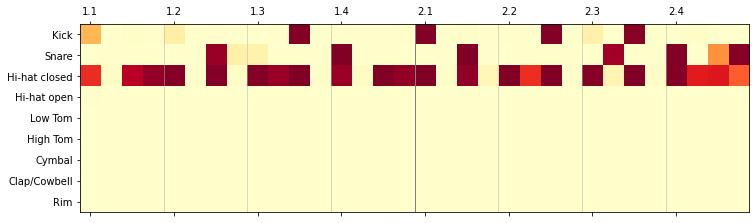

epoch: 477
m_d_loss: 0.2141158916950225     m_g_loss: 6.199243273053851


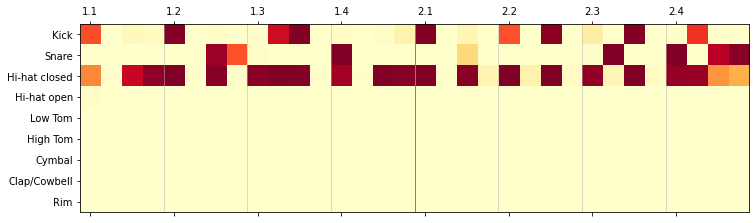

epoch: 478
m_d_loss: 0.21634960298736894     m_g_loss: 6.4879811345314495


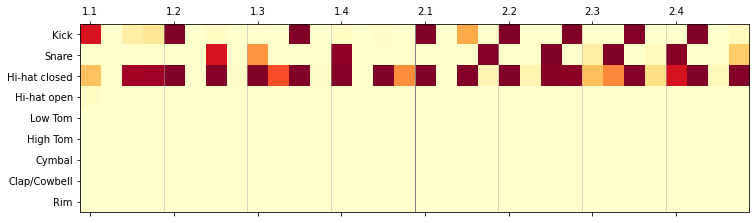

epoch: 479
m_d_loss: 0.20521476817131043     m_g_loss: 6.699472476025017


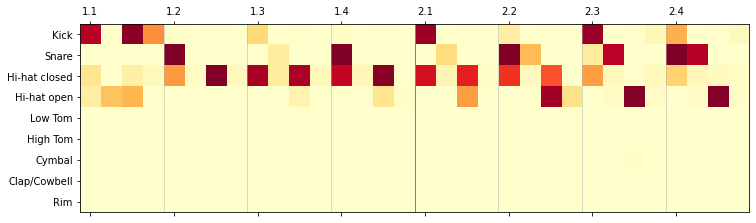

epoch: 480
m_d_loss: 0.23681973243753118     m_g_loss: 5.042842509795208


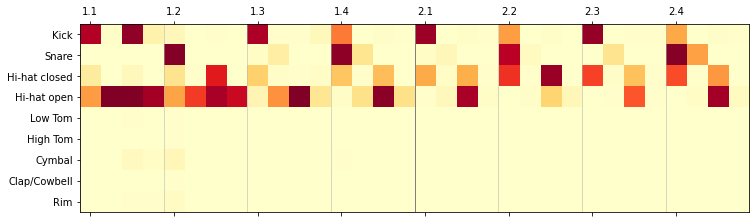

epoch: 481
m_d_loss: 0.1905326948165893     m_g_loss: 6.177396550470469


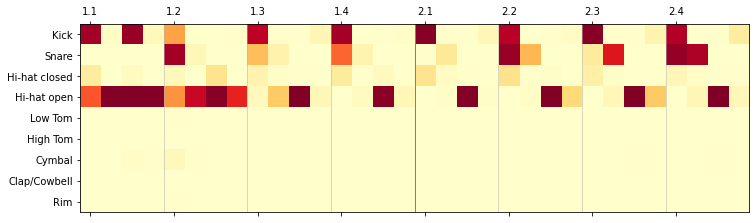

epoch: 482
m_d_loss: 0.21273172808190186     m_g_loss: 6.100241807042336


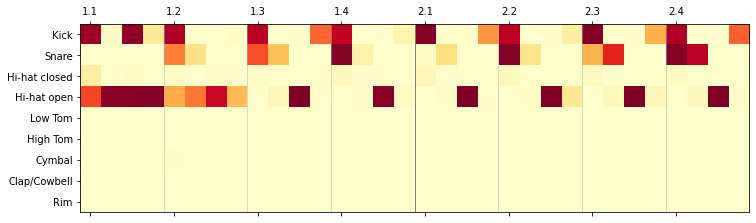

epoch: 483
m_d_loss: 0.1913009570837021     m_g_loss: 6.978802651775126


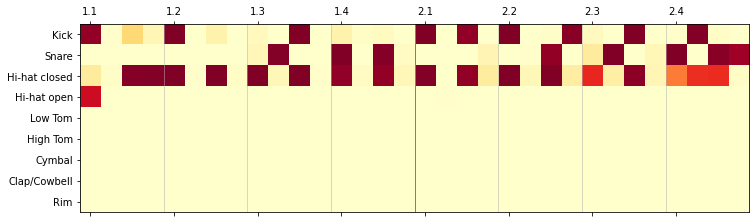

epoch: 484
m_d_loss: 0.20154124287267527     m_g_loss: 6.168411566286671


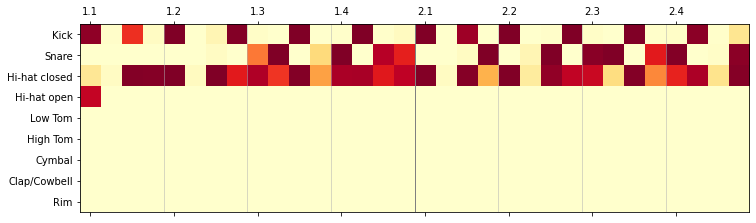

epoch: 485
m_d_loss: 0.2391265654563904     m_g_loss: 5.971098865781512


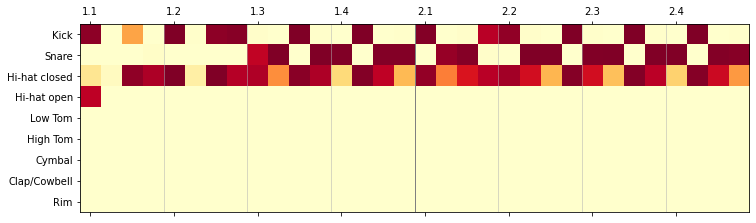

epoch: 486
m_d_loss: 0.20611163427432375     m_g_loss: 5.548090954216159


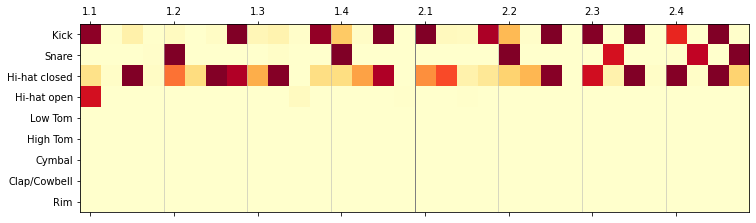

epoch: 487
m_d_loss: 0.1814953547716141     m_g_loss: 7.030870797682781


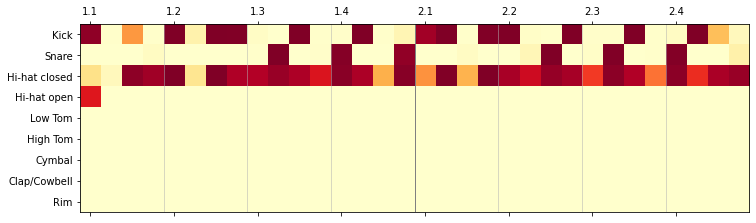

epoch: 488
m_d_loss: 0.20850252956151957     m_g_loss: 6.017198572353441


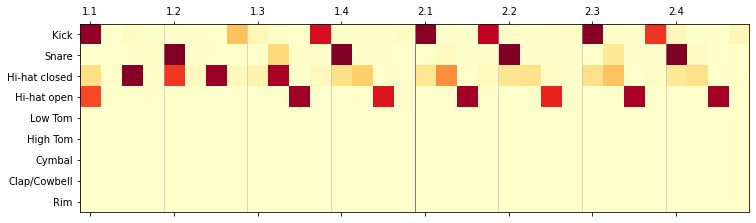

epoch: 489
m_d_loss: 0.2191246700286865     m_g_loss: 5.646128907495616


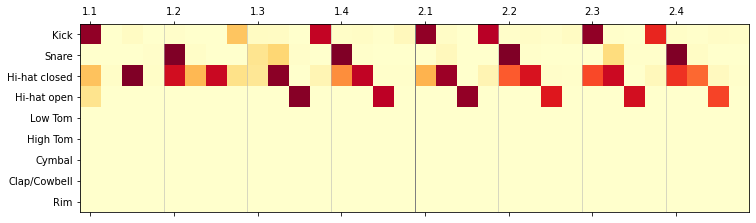

epoch: 490
m_d_loss: 0.20568825925389922     m_g_loss: 5.878929284154152


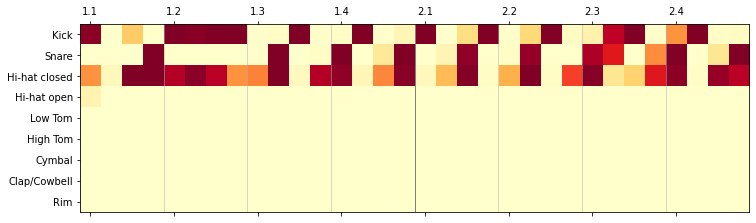

epoch: 491
m_d_loss: 0.17937771821022036     m_g_loss: 7.425553175867821


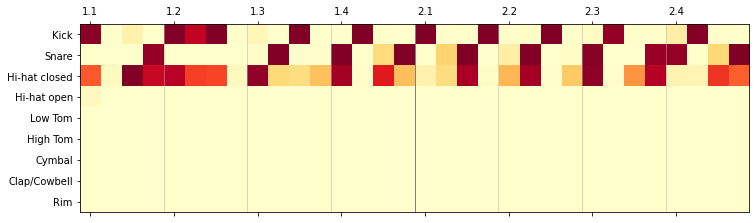

epoch: 492
m_d_loss: 0.2079631927112738     m_g_loss: 6.805844968679


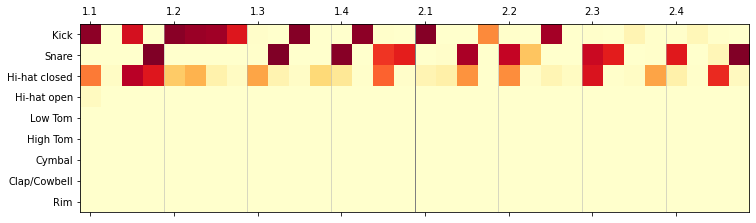

epoch: 493
m_d_loss: 0.22809668838977815     m_g_loss: 5.494047077334657


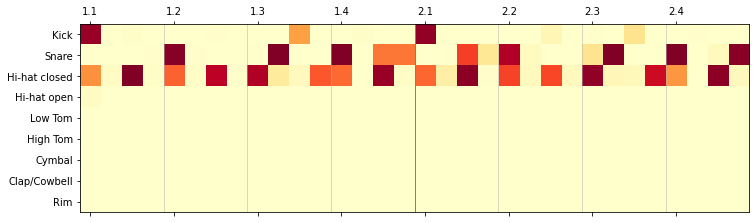

epoch: 494
m_d_loss: 0.22819415715833505     m_g_loss: 5.060835614496348


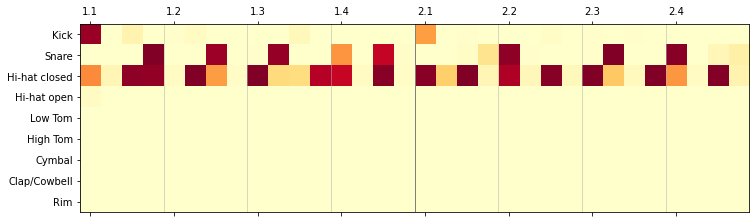

epoch: 495
m_d_loss: 0.2078979820013046     m_g_loss: 6.001769834635209


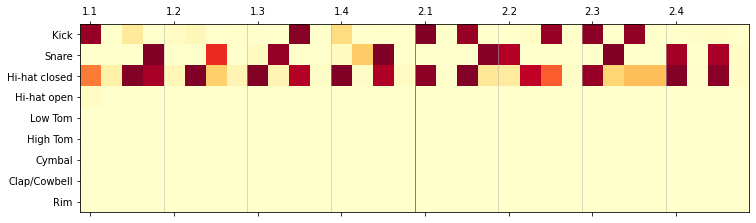

epoch: 496
m_d_loss: 0.19829183258116242     m_g_loss: 6.316830080382678


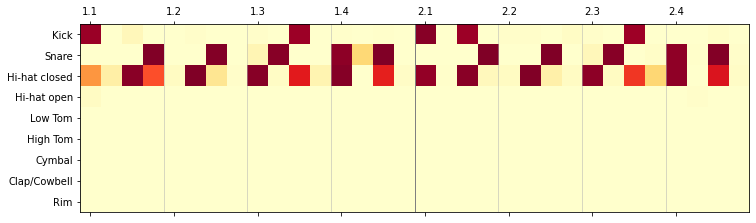

epoch: 497
m_d_loss: 0.20037430322170258     m_g_loss: 6.79961685258515


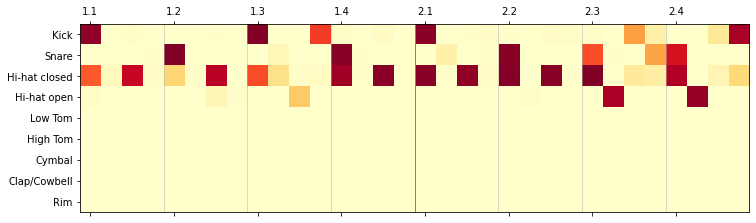

epoch: 498
m_d_loss: 0.2282210774719716     m_g_loss: 5.264467706485671


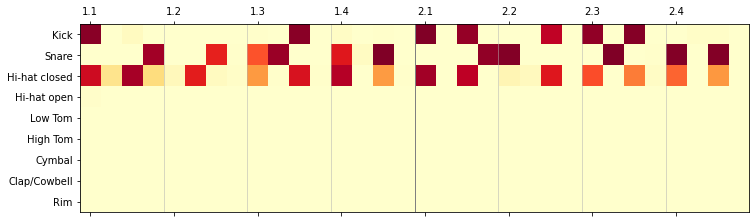

epoch: 499
m_d_loss: 0.21656050741672522     m_g_loss: 5.802076076974674


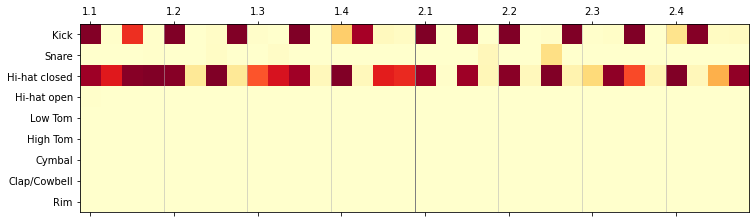

In [ ]:
generator_model = generator(batch_size=batch_size).to(device)
discriminator_model = discriminator().to(device)
optimizer_d = optim.Adam(discriminator_model.parameters(), lr=0.0001,betas=(0.9, 0.999),eps=1e-07)
optimizer_g = optim.Adam(generator_model.parameters(), lr=0.0001,betas=(0.9, 0.999),eps=1e-07)
scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=10)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=10)

for epoch in range(0,MAX_EPOCH):
  generator_model.train()
  generator_model.train()
  manager_train.reset()
      # for i, (drum,label) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
  nb_steps = int(len(drum_dataset)/batch_size)
  for repeat in range(nb_steps):
    #Train D
    if(train_d):
      m_d_loss = 0.0
      for i in range(K_unrolled_d):
        subset_indices = np.random.randint(low = 0, high= len(drum_dataset), size=batch_size)            

        drum,label = drum_dataset.__getitem__(subset_indices)
        drum,label = drum.to(device),label.to(device)
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)* 0.9 # one-sided soft labeling
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        optimizer_d.zero_grad()
        d_pred_real = discriminator_model(drum,label) 
        d_loss_real = f_loss(d_pred_real, valid)
        d_loss_real.backward()
        optimizer_d.step()

        optimizer_d.zero_grad()
        noise = np.random.normal(0.0, 1, size=(batch_size,100))
        noise = torch.FloatTensor(noise).to(device)
        generator_model.init_hidden()
        drum_fake = generator_model(noise,label)  
        d_pred_fake = discriminator_model(drum_fake.detach(),label) # detach to avoid training G on these labels

        d_loss_fake = f_loss(d_pred_fake, fake)
        d_loss_fake.backward()
        optimizer_d.step()

        d_loss = (d_loss_fake + d_loss_real) / 2
        m_d_loss += d_loss.item()

      m_d_loss /= float(K_unrolled_d)
      manager_train.update('discriminator_loss',m_d_loss)

    #Train G
    if(train_g):
      m_g_loss = 0.0
      for p in discriminator_model.parameters():
        p.requires_grad = False
      for i in range(K_unrolled_g):
          optimizer_g.zero_grad()
          noise = np.random.normal(0.0, 1, size=(batch_size,100))
          noise = torch.FloatTensor(noise).to(device)

          label_random = torch.LongTensor(np.random.randint(0, NB_GENRES, (batch_size,1))).to(device)
          valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)

          generator_model.init_hidden()
          drum_fake = generator_model(noise,label_random)

          d_pred_fake = discriminator_model(drum_fake,label_random)

          g_loss = f_loss(d_pred_fake, valid)
          m_g_loss += g_loss.item()
          g_loss.backward()
          optimizer_g.step()
      for p in discriminator_model.parameters():
        p.requires_grad = True
      m_g_loss /= float(K_unrolled_g)
      manager_train.update('generator_loss',m_g_loss)



    if train_d and train_g:
      if(m_g_loss != 0 and m_d_loss != 0):
        if m_g_loss / m_d_loss > MAX_LOSS_RATIO:
            train_d = False
      #                print ("Pausing D")
        elif m_d_loss / m_g_loss > MAX_LOSS_RATIO:
            train_g = False
      #                print ("Pausing G")
      else:
        if(m_g_loss == 0):
            train_g = False
        if(m_d_loss == 0):
            train_d = False
    else:
        train_d = True
        train_g = True


  scheduler_d.step()
  scheduler_g.step()
  summery_dict = manager_train.summary()    
  print("epoch:",epoch)
  print("m_d_loss:",summery_dict['discriminator_loss'],"    m_g_loss:",summery_dict['generator_loss'])
  manager_train.reset()

  #Sample output
  noise = np.random.normal(0.0, 1, size=(batch_size,100))
  noise = torch.FloatTensor(noise).to(device)
  label_random = torch.LongTensor(np.random.randint(0, NB_GENRES, (batch_size,1))).to(device)
  generator_model.init_hidden()
  drum_generated = generator_model(noise,label_random)
  drum_generated = drum_generated[0,:,:]
  drum_generated = drum_generated.cpu().data.numpy()
  plot_drum_matrix(drum_generated)



